## **1. Check OS Path**
---

In [1]:
#Using local drive
import os
path = os.getcwd()
print(path)

D:\MyLab\GAN\DCGAN


## **2. Import the necessary libraries**
---

In [2]:
import time, multiprocessing
import numpy as np
import tensorflow as tf
import tensorlayer as tl
import matplotlib
import matplotlib.pyplot as plt
from tensorlayer.layers import Input, Dense, DeConv2d, Reshape, BatchNorm2d, Conv2d, Flatten
from glob import glob
import h5py
## enable debug logging
tl.logging.set_verbosity(tl.logging.DEBUG)

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("tensorlayer: ", tl.__version__)
print("matplotlib: ", matplotlib.__version__)
print("numpy: ", np.__version__)

Versions of key libraries
---
tensorflow:  2.2.0
tensorlayer:  2.2.3
matplotlib:  3.2.2
numpy:  1.19.1


## **3. Define initial hyper parameters object**
---

In [3]:
class FLAGS(object):
    def __init__(self):
        self.n_epoch = 10 # "Epoch to train [25]"
        self.z_dim = 100 # "Num of noise value]"
        self.lr = 0.0002 # "Learning rate of for adam [0.0002]")
        self.beta1 = 0.5 # "Momentum term of adam [0.5]")
        self.batch_size = 64 # "The number of batch images [64]")
        self.output_size = 128 # "The size of the output images to produce [64]")
        self.sample_size = 64 # "The number of sample images [64]")
        self.c_dim = 3 # "Number of image channels. [3]")
        self.save_every_epoch = 1 # "The interval of saveing checkpoints.")
        self.checkpoint_dir = "checkpoint" # "Directory name to save the checkpoints")
        self.trian_dir = "result/trian" # "Directory name to save the training result "
        self.test_dir = "result/test" # "Directory name to save the test results")
        self.data_cartoon_dir = "data/cartoon" # Directory name for learning data - cartoon
        self.data_human_dir = "data/human" # Directory name for learning data - human
        assert np.sqrt(self.sample_size) % 1 == 0., 'Flag `sample_size` needs to be a perfect square'

flags = FLAGS()
flags

## **4. CheckPoint and Output directory**
---

In [4]:
cp_dir = tl.files.exists_or_mkdir(flags.checkpoint_dir) # saved model
trian_dir = tl.files.exists_or_mkdir(flags.trian_dir) #  generated image
test_dir = tl.files.exists_or_mkdir(flags.test_dir) #  generated image
print(cp_dir)
print(trian_dir)
print(test_dir)

[TL] [!] checkpoint exists ...
[TL] [!] result/trian exists ...
[TL] [!] result/test exists ...
True
True
True


## **5. Define function for data pre-processing**
---

In [5]:
def preprocess_data(data,output_size, n_epoch, batch_size):
    # dataset API and augmentation
    images_path = tl.files.load_file_list(data, regx='.*.jpg', keep_prefix=True, printable=False)
    def generator_train():
        for image_path in images_path:
            yield image_path.encode('utf-8')
    def _map_fn(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # get RGB with 0~1
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        #image = image[45:173, 25:153, :] # central crop
        image = tf.image.resize([image], (output_size, output_size))[0]
        image = tf.image.random_flip_left_right(image)
        image = image * 2 - 1
        return image
    train_ds = tf.data.Dataset.from_generator(generator_train, output_types=tf.string)
    ds = train_ds.shuffle(buffer_size=4096)
    ds = ds.map(_map_fn, num_parallel_calls=4)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=2)
    return ds, images_path
    
print(preprocess_data)

<function preprocess_data at 0x000002A43C3B8D90>


## **6. Define the Generator model**
___

In [6]:
def get_generator(shape,modelName,gf_dim=64): # Dimension of gen filters in first conv layer. [64]
    image_size = 128
    s16 = image_size // 16
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)

    ni = Input(shape)
    nn = Dense(n_units=(gf_dim * 8 * s16 * s16), W_init=w_init, b_init=None)(ni)
    nn = Reshape(shape=[-1, s16, s16, gf_dim*8])(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init, name=None)(nn)
    nn = DeConv2d(gf_dim * 4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d( decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim * 2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(3, (5, 5), (2, 2), act=tf.nn.tanh, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn, name=modelName)

import pprint
G = get_generator([None, flags.z_dim],'generator')
Gtest = get_generator([None, flags.z_dim],'generatorTest')
pprint.pprint(G.config)

[TL] Input  _inputlayer_1: [None, 100]
[TL] Dense  dense_1: 32768 No Activation
[TL] Reshape reshape_1
[TL] BatchNorm batchnorm2d_1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] DeConv2d deconv2d_1: n_filters: 256 strides: (2, 2) padding: SAME act: No Activation dilation: (1, 1)
[TL] BatchNorm batchnorm2d_2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] DeConv2d deconv2d_2: n_filters: 128 strides: (2, 2) padding: SAME act: No Activation dilation: (1, 1)
[TL] BatchNorm batchnorm2d_3: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] DeConv2d deconv2d_3: n_filters: 64 strides: (2, 2) padding: SAME act: No Activation dilation: (1, 1)
[TL] BatchNorm batchnorm2d_4: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] DeConv2d deconv2d_4: n_filters: 3 strides: (2, 2) padding: SAME act: tanh dilation: (1, 1)
[TL] Input  _inputlayer_2: [None, 100]
[TL] Dense  dense_2: 32768 No Activation
[TL] Reshape reshape_2
[TL] BatchNorm bat

## **7. Define descriminator model**
---

In [7]:
def get_discriminator(shape, modelName,df_dim=64): # Dimension of discrim filters in first conv layer. [64]
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    lrelu = lambda x : tf.nn.leaky_relu(x, 0.2)

    ni = Input(shape)
    nn = Conv2d(df_dim, (5, 5), (2, 2), act=lrelu, W_init=w_init)(ni)
    nn = Conv2d(df_dim*2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*8, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Flatten()(nn)
    nn = Dense(n_units=1, act=tf.identity, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn, name=modelName)

D = get_discriminator([None, flags.output_size, flags.output_size, flags.c_dim],'discriminator')
pprint.pprint(D.config)

[TL] Input  _inputlayer_3: [None, 128, 128, 3]
[TL] Conv2d conv2d_1: n_filter: 64 filter_size: (5, 5) strides: (2, 2) pad: SAME act: <lambda>
[TL] Conv2d conv2d_2: n_filter: 128 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_9: decay: 0.900000 epsilon: 0.000010 act: <lambda> is_train: False
[TL] Conv2d conv2d_3: n_filter: 256 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_10: decay: 0.900000 epsilon: 0.000010 act: <lambda> is_train: False
[TL] Conv2d conv2d_4: n_filter: 512 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_11: decay: 0.900000 epsilon: 0.000010 act: <lambda> is_train: False
[TL] Flatten flatten_1:
[TL] Dense  dense_3: 1 identity
{'inputs': '_inputlayer_3_node_0',
 'model_architecture': [{'args': {'dtype': 'tf.float32',
                                  'layer_type': 'normal',
                                  'name': '_inputlayer_3',
      

## **8. Load the Checkpoint**
___

In [8]:
try:
    if cp_dir:
        print("CheckPoint Exits!")
        G.load_weights('{}/G_human.npz'.format(flags.checkpoint_dir), format='npz')
        D.load_weights('{}/D_human.npz'.format(flags.checkpoint_dir), format='npz')
        print("Weight Loaded")
    else:
        print("CheckPoint Folder doesn't exist")
except:
    print("Weight files doesn't exist")

CheckPoint Exits!
[TL] [*] Load checkpoint/G_human.npz SUCCESS!
[TL] [*] Load checkpoint/D_human.npz SUCCESS!
Weight Loaded


## **9. Define model training method**
---

In [9]:
num_tiles = int(np.sqrt(flags.sample_size))

def save_epoch_history(passed_epoch): 
    try:
        f = h5py.File('{}/epoch_history_human.h5'.format(flags.checkpoint_dir),'a')
        
        prev_epoch = 0
        curr_epoch = 0
        
        if "epoch_history" not in f.keys():
            f.create_dataset("epoch_history",(1,1))
        
        if "prev_epoch" in f['epoch_history'].attrs.keys():
            prev_epoch = f['epoch_history'].attrs["prev_epoch"]
            f['epoch_history'].attrs["current_epoch"] = prev_epoch + passed_epoch
            curr_epoch = f['epoch_history'].attrs["current_epoch"]
            print("Epoch History - Previous Epoch: ",prev_epoch)
            print("Epoch History - Current Epoch: ",curr_epoch)
            f['epoch_history'].attrs["prev_epoch"] = curr_epoch
            return curr_epoch
        else:
            f['epoch_history'].attrs["prev_epoch"] = passed_epoch
            print("Epoch History - Previous Epoch: ",prev_epoch)
            return  prev_epoch 
        
        f.close()
    except:
        f.close()
    
def train(data):
    images, images_path = preprocess_data(data,flags.output_size, flags.n_epoch, flags.batch_size)
    
    G.train()
    D.train()

    d_optimizer = tf.optimizers.Adam(flags.lr, beta_1=flags.beta1)
    g_optimizer = tf.optimizers.Adam(flags.lr, beta_1=flags.beta1)

    n_step_epoch = int(len(images_path) // flags.batch_size)
    
    # Z = tf.distributions.Normal(0., 1.)
    for epoch in range(flags.n_epoch):
        for step, batch_images in enumerate(images):
            if batch_images.shape[0] != flags.batch_size: # if the remaining data in this epoch < batch_size
                break
            step_time = time.time()
            with tf.GradientTape(persistent=True) as tape:
                # z = Z.sample([flags.batch_size, flags.z_dim]) 
                z = np.random.normal(loc=0.0, scale=1.0, size=[flags.batch_size, flags.z_dim]).astype(np.float32)
                d_logits = D(G(z))
                d2_logits = D(batch_images)
                # discriminator: real images are labelled as 1
                d_loss_real = tl.cost.sigmoid_cross_entropy(d2_logits, tf.ones_like(d2_logits), name='dreal')
                # discriminator: images from generator (fake) are labelled as 0
                d_loss_fake = tl.cost.sigmoid_cross_entropy(d_logits, tf.zeros_like(d_logits), name='dfake')
                # combined loss for updating discriminator
                d_loss = d_loss_real + d_loss_fake
                # generator: try to fool discriminator to output 1
                g_loss = tl.cost.sigmoid_cross_entropy(d_logits, tf.ones_like(d_logits), name='gfake')

            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))
            del tape

            print("Epoch: [{}/{}] [{}/{}] took: {:.3f}, d_loss: {:.5f}, g_loss: {:.5f}".format(epoch, \
                  flags.n_epoch, step, n_step_epoch, time.time()-step_time, d_loss, g_loss))
        
        if np.mod(epoch, flags.save_every_epoch) == 0:
            G.save_weights('{}/G_human.npz'.format(flags.checkpoint_dir), format='npz')
            D.save_weights('{}/D_human.npz'.format(flags.checkpoint_dir), format='npz')
            G.save('{}/G_human_DCGAN_1.h5'.format(flags.checkpoint_dir),save_weights=True)
            D.save('{}/D_human_DCGAN_1.h5'.format(flags.checkpoint_dir),save_weights=True)
            historic_epoch = save_epoch_history(flags.save_every_epoch)
            G.eval()
            result = G(z)
            G.train()
            tl.visualize.save_images(result.numpy(), [num_tiles, num_tiles], '{}/train_{}.png'.format(flags.trian_dir, historic_epoch))
            
print(num_tiles)
print(train)

8
<function train at 0x000002A42C8F6E18>


## **10. Train the model**
---
* Step 1: train both the Generator and Descriminator
* Step 2: Save new weights
* Step 3: Generate new image summary

In [11]:
train(flags.data_human_dir)

Epoch: [0/10] [0/2136] took: 2.732, d_loss: 0.60491, g_loss: 5.08866
Epoch: [0/10] [1/2136] took: 0.741, d_loss: 1.59959, g_loss: 0.68019
Epoch: [0/10] [2/2136] took: 0.739, d_loss: 0.64097, g_loss: 1.55853
Epoch: [0/10] [3/2136] took: 0.742, d_loss: 0.87644, g_loss: 5.81807
Epoch: [0/10] [4/2136] took: 0.743, d_loss: 0.13648, g_loss: 3.73661
Epoch: [0/10] [5/2136] took: 0.740, d_loss: 1.32122, g_loss: 0.70342
Epoch: [0/10] [6/2136] took: 0.745, d_loss: 0.78553, g_loss: 3.24208
Epoch: [0/10] [7/2136] took: 0.745, d_loss: 0.51873, g_loss: 3.70019
Epoch: [0/10] [8/2136] took: 0.746, d_loss: 0.85486, g_loss: 1.83805
Epoch: [0/10] [9/2136] took: 0.748, d_loss: 0.51550, g_loss: 2.82947
Epoch: [0/10] [10/2136] took: 0.747, d_loss: 0.49188, g_loss: 4.69876
Epoch: [0/10] [11/2136] took: 0.747, d_loss: 0.27541, g_loss: 3.98099
Epoch: [0/10] [12/2136] took: 0.748, d_loss: 0.24519, g_loss: 3.64899
Epoch: [0/10] [13/2136] took: 0.747, d_loss: 0.19249, g_loss: 4.19830
Epoch: [0/10] [14/2136] took: 

Epoch: [0/10] [117/2136] took: 0.760, d_loss: 4.07047, g_loss: 0.26355
Epoch: [0/10] [118/2136] took: 0.757, d_loss: 0.24254, g_loss: 7.97118
Epoch: [0/10] [119/2136] took: 0.762, d_loss: 0.72221, g_loss: 7.24874
Epoch: [0/10] [120/2136] took: 0.764, d_loss: 0.46951, g_loss: 2.30442
Epoch: [0/10] [121/2136] took: 0.756, d_loss: 0.24044, g_loss: 3.44635
Epoch: [0/10] [122/2136] took: 0.764, d_loss: 0.14999, g_loss: 4.99946
Epoch: [0/10] [123/2136] took: 0.760, d_loss: 0.18004, g_loss: 3.73391
Epoch: [0/10] [124/2136] took: 0.758, d_loss: 0.17467, g_loss: 5.07449
Epoch: [0/10] [125/2136] took: 0.764, d_loss: 0.14404, g_loss: 6.13305
Epoch: [0/10] [126/2136] took: 0.758, d_loss: 0.10093, g_loss: 4.37723
Epoch: [0/10] [127/2136] took: 0.757, d_loss: 0.09845, g_loss: 3.81531
Epoch: [0/10] [128/2136] took: 0.761, d_loss: 0.04785, g_loss: 5.75176
Epoch: [0/10] [129/2136] took: 0.758, d_loss: 0.05637, g_loss: 4.31593
Epoch: [0/10] [130/2136] took: 0.763, d_loss: 0.16972, g_loss: 4.88684
Epoch:

Epoch: [0/10] [233/2136] took: 0.764, d_loss: 0.06371, g_loss: 9.69351
Epoch: [0/10] [234/2136] took: 0.764, d_loss: 0.03701, g_loss: 5.89592
Epoch: [0/10] [235/2136] took: 0.763, d_loss: 0.04089, g_loss: 6.11828
Epoch: [0/10] [236/2136] took: 0.761, d_loss: 0.05481, g_loss: 8.12136
Epoch: [0/10] [237/2136] took: 0.762, d_loss: 0.01439, g_loss: 9.77425
Epoch: [0/10] [238/2136] took: 0.766, d_loss: 0.14163, g_loss: 4.39369
Epoch: [0/10] [239/2136] took: 0.767, d_loss: 0.04710, g_loss: 8.63881
Epoch: [0/10] [240/2136] took: 0.766, d_loss: 0.04448, g_loss: 11.39786
Epoch: [0/10] [241/2136] took: 0.764, d_loss: 0.00895, g_loss: 7.53104
Epoch: [0/10] [242/2136] took: 0.761, d_loss: 0.01027, g_loss: 7.26643
Epoch: [0/10] [243/2136] took: 0.761, d_loss: 0.00611, g_loss: 8.66267
Epoch: [0/10] [244/2136] took: 0.765, d_loss: 0.00646, g_loss: 10.29428
Epoch: [0/10] [245/2136] took: 0.765, d_loss: 0.05356, g_loss: 5.06586
Epoch: [0/10] [246/2136] took: 0.765, d_loss: 0.02078, g_loss: 13.32700
Epo

Epoch: [0/10] [349/2136] took: 0.766, d_loss: 0.19890, g_loss: 5.05919
Epoch: [0/10] [350/2136] took: 0.762, d_loss: 0.24966, g_loss: 6.31489
Epoch: [0/10] [351/2136] took: 0.761, d_loss: 0.28030, g_loss: 3.35113
Epoch: [0/10] [352/2136] took: 0.764, d_loss: 0.06952, g_loss: 4.96168
Epoch: [0/10] [353/2136] took: 0.766, d_loss: 0.36514, g_loss: 4.60178
Epoch: [0/10] [354/2136] took: 0.765, d_loss: 0.16802, g_loss: 4.72181
Epoch: [0/10] [355/2136] took: 0.765, d_loss: 0.11949, g_loss: 5.75632
Epoch: [0/10] [356/2136] took: 0.762, d_loss: 0.04681, g_loss: 6.12465
Epoch: [0/10] [357/2136] took: 0.763, d_loss: 0.08226, g_loss: 6.24224
Epoch: [0/10] [358/2136] took: 0.766, d_loss: 0.18721, g_loss: 4.43437
Epoch: [0/10] [359/2136] took: 0.764, d_loss: 0.06619, g_loss: 7.03249
Epoch: [0/10] [360/2136] took: 0.764, d_loss: 0.11097, g_loss: 7.65046
Epoch: [0/10] [361/2136] took: 0.765, d_loss: 0.11684, g_loss: 4.95308
Epoch: [0/10] [362/2136] took: 0.766, d_loss: 0.05790, g_loss: 6.79716
Epoch:

Epoch: [0/10] [465/2136] took: 0.763, d_loss: 0.03789, g_loss: 6.34778
Epoch: [0/10] [466/2136] took: 0.761, d_loss: 0.06813, g_loss: 6.40815
Epoch: [0/10] [467/2136] took: 0.764, d_loss: 0.05139, g_loss: 6.91421
Epoch: [0/10] [468/2136] took: 0.766, d_loss: 0.00876, g_loss: 8.07670
Epoch: [0/10] [469/2136] took: 0.765, d_loss: 0.13516, g_loss: 5.11824
Epoch: [0/10] [470/2136] took: 0.765, d_loss: 0.05317, g_loss: 11.42862
Epoch: [0/10] [471/2136] took: 0.764, d_loss: 0.02416, g_loss: 6.31118
Epoch: [0/10] [472/2136] took: 0.760, d_loss: 0.08046, g_loss: 6.80716
Epoch: [0/10] [473/2136] took: 0.764, d_loss: 0.04656, g_loss: 6.39784
Epoch: [0/10] [474/2136] took: 0.764, d_loss: 0.05746, g_loss: 5.61032
Epoch: [0/10] [475/2136] took: 0.767, d_loss: 0.05052, g_loss: 5.55722
Epoch: [0/10] [476/2136] took: 0.765, d_loss: 0.03973, g_loss: 8.39803
Epoch: [0/10] [477/2136] took: 0.764, d_loss: 0.03035, g_loss: 9.57819
Epoch: [0/10] [478/2136] took: 0.762, d_loss: 0.00600, g_loss: 9.87227
Epoch

Epoch: [0/10] [581/2136] took: 0.762, d_loss: 0.12047, g_loss: 5.88228
Epoch: [0/10] [582/2136] took: 0.765, d_loss: 0.10825, g_loss: 4.73474
Epoch: [0/10] [583/2136] took: 0.765, d_loss: 0.04925, g_loss: 7.36643
Epoch: [0/10] [584/2136] took: 0.766, d_loss: 0.08821, g_loss: 6.73523
Epoch: [0/10] [585/2136] took: 0.768, d_loss: 0.05052, g_loss: 6.56832
Epoch: [0/10] [586/2136] took: 0.765, d_loss: 0.04982, g_loss: 5.70895
Epoch: [0/10] [587/2136] took: 0.773, d_loss: 0.03144, g_loss: 7.03970
Epoch: [0/10] [588/2136] took: 0.763, d_loss: 0.04642, g_loss: 6.17378
Epoch: [0/10] [589/2136] took: 0.765, d_loss: 0.12503, g_loss: 6.56256
Epoch: [0/10] [590/2136] took: 0.767, d_loss: 0.09700, g_loss: 5.79991
Epoch: [0/10] [591/2136] took: 0.766, d_loss: 0.12109, g_loss: 7.18262
Epoch: [0/10] [592/2136] took: 0.765, d_loss: 0.05316, g_loss: 6.66340
Epoch: [0/10] [593/2136] took: 0.765, d_loss: 0.04672, g_loss: 6.21598
Epoch: [0/10] [594/2136] took: 0.763, d_loss: 0.22883, g_loss: 4.80989
Epoch:

Epoch: [0/10] [697/2136] took: 0.766, d_loss: 0.00933, g_loss: 7.44396
Epoch: [0/10] [698/2136] took: 0.767, d_loss: 0.01430, g_loss: 6.98014
Epoch: [0/10] [699/2136] took: 0.766, d_loss: 0.01014, g_loss: 6.78200
Epoch: [0/10] [700/2136] took: 0.766, d_loss: 0.01240, g_loss: 7.40936
Epoch: [0/10] [701/2136] took: 0.764, d_loss: 0.01017, g_loss: 7.93790
Epoch: [0/10] [702/2136] took: 0.767, d_loss: 0.01799, g_loss: 7.01484
Epoch: [0/10] [703/2136] took: 0.762, d_loss: 0.00208, g_loss: 7.76601
Epoch: [0/10] [704/2136] took: 0.764, d_loss: 0.00644, g_loss: 7.48579
Epoch: [0/10] [705/2136] took: 0.767, d_loss: 0.00387, g_loss: 7.07299
Epoch: [0/10] [706/2136] took: 0.766, d_loss: 0.00542, g_loss: 7.08868
Epoch: [0/10] [707/2136] took: 0.767, d_loss: 0.00515, g_loss: 6.83770
Epoch: [0/10] [708/2136] took: 0.768, d_loss: 0.01628, g_loss: 7.68617
Epoch: [0/10] [709/2136] took: 0.765, d_loss: 0.00655, g_loss: 6.95991
Epoch: [0/10] [710/2136] took: 0.767, d_loss: 0.00470, g_loss: 7.65071
Epoch:

Epoch: [0/10] [813/2136] took: 0.764, d_loss: 0.23434, g_loss: 3.74450
Epoch: [0/10] [814/2136] took: 0.766, d_loss: 0.13675, g_loss: 6.05968
Epoch: [0/10] [815/2136] took: 0.766, d_loss: 0.07749, g_loss: 7.37500
Epoch: [0/10] [816/2136] took: 0.766, d_loss: 0.15092, g_loss: 5.82393
Epoch: [0/10] [817/2136] took: 0.766, d_loss: 0.20769, g_loss: 6.23334
Epoch: [0/10] [818/2136] took: 0.766, d_loss: 0.32830, g_loss: 3.60208
Epoch: [0/10] [819/2136] took: 0.766, d_loss: 0.27873, g_loss: 6.08582
Epoch: [0/10] [820/2136] took: 0.767, d_loss: 0.25530, g_loss: 4.39631
Epoch: [0/10] [821/2136] took: 0.764, d_loss: 0.44006, g_loss: 2.58877
Epoch: [0/10] [822/2136] took: 0.762, d_loss: 0.91556, g_loss: 9.04041
Epoch: [0/10] [823/2136] took: 0.763, d_loss: 0.79894, g_loss: 1.55719
Epoch: [0/10] [824/2136] took: 0.767, d_loss: 0.03757, g_loss: 7.39246
Epoch: [0/10] [825/2136] took: 0.768, d_loss: 0.56676, g_loss: 8.58259
Epoch: [0/10] [826/2136] took: 0.770, d_loss: 0.07344, g_loss: 5.08459
Epoch:

Epoch: [0/10] [929/2136] took: 0.766, d_loss: 0.03918, g_loss: 8.45647
Epoch: [0/10] [930/2136] took: 0.769, d_loss: 0.01468, g_loss: 8.71491
Epoch: [0/10] [931/2136] took: 0.766, d_loss: 0.24503, g_loss: 3.73220
Epoch: [0/10] [932/2136] took: 0.767, d_loss: 0.18589, g_loss: 12.89845
Epoch: [0/10] [933/2136] took: 0.767, d_loss: 0.10066, g_loss: 6.67028
Epoch: [0/10] [934/2136] took: 0.766, d_loss: 0.11414, g_loss: 4.66445
Epoch: [0/10] [935/2136] took: 0.765, d_loss: 0.08815, g_loss: 5.95460
Epoch: [0/10] [936/2136] took: 0.769, d_loss: 0.15300, g_loss: 7.50343
Epoch: [0/10] [937/2136] took: 0.767, d_loss: 0.02771, g_loss: 7.80419
Epoch: [0/10] [938/2136] took: 0.766, d_loss: 0.08266, g_loss: 4.66760
Epoch: [0/10] [939/2136] took: 0.767, d_loss: 0.06545, g_loss: 5.97893
Epoch: [0/10] [940/2136] took: 0.767, d_loss: 0.05209, g_loss: 6.11304
Epoch: [0/10] [941/2136] took: 0.767, d_loss: 0.20420, g_loss: 5.55261
Epoch: [0/10] [942/2136] took: 0.766, d_loss: 0.16274, g_loss: 4.58612
Epoch

Epoch: [0/10] [1044/2136] took: 0.766, d_loss: 0.20870, g_loss: 4.24487
Epoch: [0/10] [1045/2136] took: 0.766, d_loss: 0.21528, g_loss: 5.12756
Epoch: [0/10] [1046/2136] took: 0.769, d_loss: 0.27065, g_loss: 4.86947
Epoch: [0/10] [1047/2136] took: 0.768, d_loss: 0.33438, g_loss: 3.52042
Epoch: [0/10] [1048/2136] took: 0.766, d_loss: 0.22120, g_loss: 3.75254
Epoch: [0/10] [1049/2136] took: 0.766, d_loss: 0.19275, g_loss: 5.58788
Epoch: [0/10] [1050/2136] took: 0.766, d_loss: 0.34232, g_loss: 5.08775
Epoch: [0/10] [1051/2136] took: 0.768, d_loss: 0.27373, g_loss: 3.20092
Epoch: [0/10] [1052/2136] took: 0.767, d_loss: 0.29321, g_loss: 4.38467
Epoch: [0/10] [1053/2136] took: 0.767, d_loss: 0.14499, g_loss: 6.31850
Epoch: [0/10] [1054/2136] took: 0.768, d_loss: 0.13525, g_loss: 4.67772
Epoch: [0/10] [1055/2136] took: 0.767, d_loss: 0.29725, g_loss: 6.08913
Epoch: [0/10] [1056/2136] took: 0.767, d_loss: 0.13690, g_loss: 4.64286
Epoch: [0/10] [1057/2136] took: 0.766, d_loss: 0.15082, g_loss: 

Epoch: [0/10] [1158/2136] took: 0.766, d_loss: 0.01837, g_loss: 8.96420
Epoch: [0/10] [1159/2136] took: 0.768, d_loss: 0.02657, g_loss: 6.72335
Epoch: [0/10] [1160/2136] took: 0.766, d_loss: 0.00289, g_loss: 9.31474
Epoch: [0/10] [1161/2136] took: 0.766, d_loss: 0.00862, g_loss: 8.76516
Epoch: [0/10] [1162/2136] took: 0.770, d_loss: 0.00426, g_loss: 9.97251
Epoch: [0/10] [1163/2136] took: 0.767, d_loss: 0.00491, g_loss: 11.00679
Epoch: [0/10] [1164/2136] took: 0.767, d_loss: 0.01189, g_loss: 9.65714
Epoch: [0/10] [1165/2136] took: 0.770, d_loss: 0.01396, g_loss: 12.41925
Epoch: [0/10] [1166/2136] took: 0.766, d_loss: 0.00151, g_loss: 11.57714
Epoch: [0/10] [1167/2136] took: 0.767, d_loss: 0.04440, g_loss: 11.82955
Epoch: [0/10] [1168/2136] took: 0.767, d_loss: 0.00480, g_loss: 9.21382
Epoch: [0/10] [1169/2136] took: 0.765, d_loss: 0.03092, g_loss: 9.54898
Epoch: [0/10] [1170/2136] took: 0.767, d_loss: 0.00070, g_loss: 10.59758
Epoch: [0/10] [1171/2136] took: 0.767, d_loss: 0.00090, g_l

Epoch: [0/10] [1272/2136] took: 0.763, d_loss: 0.07829, g_loss: 5.18019
Epoch: [0/10] [1273/2136] took: 0.765, d_loss: 0.08587, g_loss: 6.39240
Epoch: [0/10] [1274/2136] took: 0.766, d_loss: 0.42104, g_loss: 3.44820
Epoch: [0/10] [1275/2136] took: 0.766, d_loss: 0.40658, g_loss: 7.83937
Epoch: [0/10] [1276/2136] took: 0.767, d_loss: 0.97730, g_loss: 1.85287
Epoch: [0/10] [1277/2136] took: 0.768, d_loss: 3.41444, g_loss: 17.83281
Epoch: [0/10] [1278/2136] took: 0.768, d_loss: 0.08747, g_loss: 5.56006
Epoch: [0/10] [1279/2136] took: 0.768, d_loss: 2.35672, g_loss: 0.70589
Epoch: [0/10] [1280/2136] took: 0.767, d_loss: 0.48533, g_loss: 12.72690
Epoch: [0/10] [1281/2136] took: 0.767, d_loss: 0.45654, g_loss: 12.00414
Epoch: [0/10] [1282/2136] took: 0.768, d_loss: 0.04913, g_loss: 7.49971
Epoch: [0/10] [1283/2136] took: 0.767, d_loss: 0.29285, g_loss: 3.26955
Epoch: [0/10] [1284/2136] took: 0.766, d_loss: 0.14985, g_loss: 3.53724
Epoch: [0/10] [1285/2136] took: 0.767, d_loss: 0.16055, g_los

Epoch: [0/10] [1386/2136] took: 0.768, d_loss: 0.14746, g_loss: 10.45245
Epoch: [0/10] [1387/2136] took: 0.767, d_loss: 0.04545, g_loss: 8.96247
Epoch: [0/10] [1388/2136] took: 0.766, d_loss: 0.07046, g_loss: 7.23981
Epoch: [0/10] [1389/2136] took: 0.767, d_loss: 0.11288, g_loss: 5.08325
Epoch: [0/10] [1390/2136] took: 0.770, d_loss: 0.01746, g_loss: 9.62486
Epoch: [0/10] [1391/2136] took: 0.766, d_loss: 0.05843, g_loss: 6.39882
Epoch: [0/10] [1392/2136] took: 0.766, d_loss: 0.08219, g_loss: 6.00820
Epoch: [0/10] [1393/2136] took: 0.768, d_loss: 0.00394, g_loss: 9.43511
Epoch: [0/10] [1394/2136] took: 0.766, d_loss: 0.05224, g_loss: 10.32581
Epoch: [0/10] [1395/2136] took: 0.767, d_loss: 0.02365, g_loss: 6.49501
Epoch: [0/10] [1396/2136] took: 0.767, d_loss: 0.01084, g_loss: 8.12946
Epoch: [0/10] [1397/2136] took: 0.767, d_loss: 0.04831, g_loss: 5.69681
Epoch: [0/10] [1398/2136] took: 0.767, d_loss: 0.05058, g_loss: 6.10715
Epoch: [0/10] [1399/2136] took: 0.767, d_loss: 0.03917, g_loss

Epoch: [0/10] [1500/2136] took: 0.767, d_loss: 0.06402, g_loss: 7.22929
Epoch: [0/10] [1501/2136] took: 0.768, d_loss: 0.33758, g_loss: 6.28329
Epoch: [0/10] [1502/2136] took: 0.768, d_loss: 0.08101, g_loss: 5.47407
Epoch: [0/10] [1503/2136] took: 0.767, d_loss: 0.22259, g_loss: 3.57485
Epoch: [0/10] [1504/2136] took: 0.767, d_loss: 0.35196, g_loss: 7.45538
Epoch: [0/10] [1505/2136] took: 0.766, d_loss: 0.27478, g_loss: 4.16523
Epoch: [0/10] [1506/2136] took: 0.767, d_loss: 0.30396, g_loss: 3.94393
Epoch: [0/10] [1507/2136] took: 0.768, d_loss: 0.16066, g_loss: 3.99172
Epoch: [0/10] [1508/2136] took: 0.767, d_loss: 0.25202, g_loss: 6.49550
Epoch: [0/10] [1509/2136] took: 0.767, d_loss: 0.09096, g_loss: 6.83348
Epoch: [0/10] [1510/2136] took: 0.768, d_loss: 0.12230, g_loss: 4.60956
Epoch: [0/10] [1511/2136] took: 0.767, d_loss: 0.10206, g_loss: 5.65550
Epoch: [0/10] [1512/2136] took: 0.771, d_loss: 0.03441, g_loss: 9.44917
Epoch: [0/10] [1513/2136] took: 0.769, d_loss: 0.06647, g_loss: 

Epoch: [0/10] [1614/2136] took: 0.768, d_loss: 0.37669, g_loss: 11.20672
Epoch: [0/10] [1615/2136] took: 0.771, d_loss: 0.00630, g_loss: 9.23646
Epoch: [0/10] [1616/2136] took: 0.766, d_loss: 0.07821, g_loss: 5.49233
Epoch: [0/10] [1617/2136] took: 0.767, d_loss: 0.77725, g_loss: 2.19586
Epoch: [0/10] [1618/2136] took: 0.768, d_loss: 4.39306, g_loss: 11.07840
Epoch: [0/10] [1619/2136] took: 0.769, d_loss: 0.50119, g_loss: 2.21893
Epoch: [0/10] [1620/2136] took: 0.770, d_loss: 0.42859, g_loss: 1.87550
Epoch: [0/10] [1621/2136] took: 0.764, d_loss: 0.13801, g_loss: 6.10536
Epoch: [0/10] [1622/2136] took: 0.763, d_loss: 1.61128, g_loss: 4.51844
Epoch: [0/10] [1623/2136] took: 0.766, d_loss: 5.31816, g_loss: 0.03422
Epoch: [0/10] [1624/2136] took: 0.766, d_loss: 0.48847, g_loss: 3.11549
Epoch: [0/10] [1625/2136] took: 0.767, d_loss: 0.86936, g_loss: 5.54250
Epoch: [0/10] [1626/2136] took: 0.766, d_loss: 0.32283, g_loss: 2.68261
Epoch: [0/10] [1627/2136] took: 0.767, d_loss: 0.21656, g_loss

Epoch: [0/10] [1728/2136] took: 0.767, d_loss: 0.00720, g_loss: 9.86518
Epoch: [0/10] [1729/2136] took: 0.767, d_loss: 0.03008, g_loss: 7.63651
Epoch: [0/10] [1730/2136] took: 0.767, d_loss: 0.01500, g_loss: 12.03975
Epoch: [0/10] [1731/2136] took: 0.766, d_loss: 0.05510, g_loss: 6.24035
Epoch: [0/10] [1732/2136] took: 0.767, d_loss: 0.06512, g_loss: 5.81786
Epoch: [0/10] [1733/2136] took: 0.767, d_loss: 0.13215, g_loss: 6.08069
Epoch: [0/10] [1734/2136] took: 0.767, d_loss: 0.02649, g_loss: 6.17872
Epoch: [0/10] [1735/2136] took: 0.767, d_loss: 0.02457, g_loss: 6.05343
Epoch: [0/10] [1736/2136] took: 0.767, d_loss: 0.00252, g_loss: 10.74685
Epoch: [0/10] [1737/2136] took: 0.766, d_loss: 0.08958, g_loss: 5.38633
Epoch: [0/10] [1738/2136] took: 0.768, d_loss: 0.05158, g_loss: 11.46710
Epoch: [0/10] [1739/2136] took: 0.768, d_loss: 0.02021, g_loss: 7.42758
Epoch: [0/10] [1740/2136] took: 0.766, d_loss: 0.07090, g_loss: 6.53449
Epoch: [0/10] [1741/2136] took: 0.765, d_loss: 0.02427, g_los

Epoch: [0/10] [1842/2136] took: 0.769, d_loss: 0.16490, g_loss: 8.37946
Epoch: [0/10] [1843/2136] took: 0.767, d_loss: 0.19829, g_loss: 7.69839
Epoch: [0/10] [1844/2136] took: 0.767, d_loss: 0.06904, g_loss: 5.56584
Epoch: [0/10] [1845/2136] took: 0.767, d_loss: 0.08565, g_loss: 4.96968
Epoch: [0/10] [1846/2136] took: 0.767, d_loss: 0.17777, g_loss: 3.90168
Epoch: [0/10] [1847/2136] took: 0.767, d_loss: 0.08895, g_loss: 6.56692
Epoch: [0/10] [1848/2136] took: 0.766, d_loss: 0.20329, g_loss: 4.84934
Epoch: [0/10] [1849/2136] took: 0.765, d_loss: 0.24237, g_loss: 4.84759
Epoch: [0/10] [1850/2136] took: 0.769, d_loss: 0.17052, g_loss: 2.88324
Epoch: [0/10] [1851/2136] took: 0.767, d_loss: 0.17782, g_loss: 3.88179
Epoch: [0/10] [1852/2136] took: 0.768, d_loss: 0.22039, g_loss: 5.14892
Epoch: [0/10] [1853/2136] took: 0.767, d_loss: 0.15178, g_loss: 4.12104
Epoch: [0/10] [1854/2136] took: 0.767, d_loss: 0.07222, g_loss: 4.67483
Epoch: [0/10] [1855/2136] took: 0.765, d_loss: 0.08784, g_loss: 

Epoch: [0/10] [1956/2136] took: 0.768, d_loss: 0.55553, g_loss: 1.56771
Epoch: [0/10] [1957/2136] took: 0.767, d_loss: 0.48803, g_loss: 2.63944
Epoch: [0/10] [1958/2136] took: 0.768, d_loss: 0.34685, g_loss: 2.17219
Epoch: [0/10] [1959/2136] took: 0.767, d_loss: 0.51356, g_loss: 1.69151
Epoch: [0/10] [1960/2136] took: 0.766, d_loss: 0.40010, g_loss: 2.62366
Epoch: [0/10] [1961/2136] took: 0.767, d_loss: 0.28878, g_loss: 2.53017
Epoch: [0/10] [1962/2136] took: 0.769, d_loss: 0.34604, g_loss: 2.53076
Epoch: [0/10] [1963/2136] took: 0.767, d_loss: 0.32331, g_loss: 2.22252
Epoch: [0/10] [1964/2136] took: 0.766, d_loss: 0.44494, g_loss: 3.40162
Epoch: [0/10] [1965/2136] took: 0.768, d_loss: 0.41765, g_loss: 1.89714
Epoch: [0/10] [1966/2136] took: 0.767, d_loss: 0.36126, g_loss: 3.51548
Epoch: [0/10] [1967/2136] took: 0.766, d_loss: 0.18883, g_loss: 3.14573
Epoch: [0/10] [1968/2136] took: 0.769, d_loss: 0.22296, g_loss: 2.59442
Epoch: [0/10] [1969/2136] took: 0.766, d_loss: 0.26162, g_loss: 

Epoch: [0/10] [2070/2136] took: 0.766, d_loss: 0.18548, g_loss: 4.91617
Epoch: [0/10] [2071/2136] took: 0.766, d_loss: 0.17659, g_loss: 4.90092
Epoch: [0/10] [2072/2136] took: 0.777, d_loss: 0.35018, g_loss: 3.33737
Epoch: [0/10] [2073/2136] took: 0.766, d_loss: 0.11547, g_loss: 4.73324
Epoch: [0/10] [2074/2136] took: 0.767, d_loss: 0.23749, g_loss: 5.42880
Epoch: [0/10] [2075/2136] took: 0.767, d_loss: 0.08444, g_loss: 5.17550
Epoch: [0/10] [2076/2136] took: 0.767, d_loss: 0.17934, g_loss: 5.11109
Epoch: [0/10] [2077/2136] took: 0.767, d_loss: 0.09561, g_loss: 6.29911
Epoch: [0/10] [2078/2136] took: 0.766, d_loss: 0.10860, g_loss: 5.99780
Epoch: [0/10] [2079/2136] took: 0.766, d_loss: 0.10981, g_loss: 5.42792
Epoch: [0/10] [2080/2136] took: 0.766, d_loss: 0.07694, g_loss: 5.41758
Epoch: [0/10] [2081/2136] took: 0.767, d_loss: 0.09065, g_loss: 5.16833
Epoch: [0/10] [2082/2136] took: 0.767, d_loss: 0.06506, g_loss: 5.45754
Epoch: [0/10] [2083/2136] took: 0.766, d_loss: 0.14937, g_loss: 

D:\MyApp\anaconda3\envs\MyGPU\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


[TL] [*] Saved
[TL] [*] Saving TL model into checkpoint/G_human_DCGAN_1.h5, saving weights=True
[TL] [*] Saved TL model into checkpoint/G_human_DCGAN_1.h5, saving weights=True
[TL] [*] Saving TL model into checkpoint/D_human_DCGAN_1.h5, saving weights=True
[TL] [*] Saved TL model into checkpoint/D_human_DCGAN_1.h5, saving weights=True
Epoch History - Previous Epoch:  96
Epoch History - Current Epoch:  97
Epoch: [1/10] [0/2136] took: 0.768, d_loss: 4.36797, g_loss: 17.01823
Epoch: [1/10] [1/2136] took: 0.768, d_loss: 1.08461, g_loss: 1.52096
Epoch: [1/10] [2/2136] took: 0.766, d_loss: 0.15410, g_loss: 3.61879
Epoch: [1/10] [3/2136] took: 0.768, d_loss: 0.95186, g_loss: 4.96631
Epoch: [1/10] [4/2136] took: 0.767, d_loss: 0.77875, g_loss: 1.48491
Epoch: [1/10] [5/2136] took: 0.766, d_loss: 0.13046, g_loss: 3.81130
Epoch: [1/10] [6/2136] took: 0.768, d_loss: 0.15319, g_loss: 5.63105
Epoch: [1/10] [7/2136] took: 0.766, d_loss: 0.22273, g_loss: 4.29144
Epoch: [1/10] [8/2136] took: 0.768, d_l

Epoch: [1/10] [112/2136] took: 0.773, d_loss: 0.27027, g_loss: 6.87291
Epoch: [1/10] [113/2136] took: 0.769, d_loss: 0.07089, g_loss: 6.49207
Epoch: [1/10] [114/2136] took: 0.768, d_loss: 0.13296, g_loss: 5.75308
Epoch: [1/10] [115/2136] took: 0.769, d_loss: 0.24743, g_loss: 4.68144
Epoch: [1/10] [116/2136] took: 0.767, d_loss: 0.09898, g_loss: 5.13063
Epoch: [1/10] [117/2136] took: 0.769, d_loss: 0.07961, g_loss: 7.54135
Epoch: [1/10] [118/2136] took: 0.767, d_loss: 0.20243, g_loss: 4.26668
Epoch: [1/10] [119/2136] took: 0.768, d_loss: 0.15331, g_loss: 6.70805
Epoch: [1/10] [120/2136] took: 0.766, d_loss: 0.19491, g_loss: 3.54002
Epoch: [1/10] [121/2136] took: 0.767, d_loss: 0.20991, g_loss: 6.69668
Epoch: [1/10] [122/2136] took: 0.766, d_loss: 0.26565, g_loss: 3.40356
Epoch: [1/10] [123/2136] took: 0.767, d_loss: 0.18688, g_loss: 6.03421
Epoch: [1/10] [124/2136] took: 0.767, d_loss: 0.17826, g_loss: 3.69675
Epoch: [1/10] [125/2136] took: 0.769, d_loss: 0.15899, g_loss: 5.64863
Epoch:

Epoch: [1/10] [228/2136] took: 0.771, d_loss: 0.42284, g_loss: 2.21238
Epoch: [1/10] [229/2136] took: 0.770, d_loss: 0.51383, g_loss: 3.30987
Epoch: [1/10] [230/2136] took: 0.769, d_loss: 0.37704, g_loss: 1.72728
Epoch: [1/10] [231/2136] took: 0.770, d_loss: 0.25292, g_loss: 2.93402
Epoch: [1/10] [232/2136] took: 0.769, d_loss: 0.50890, g_loss: 2.82375
Epoch: [1/10] [233/2136] took: 0.769, d_loss: 0.45159, g_loss: 1.49473
Epoch: [1/10] [234/2136] took: 0.767, d_loss: 0.45231, g_loss: 3.92772
Epoch: [1/10] [235/2136] took: 0.768, d_loss: 0.24898, g_loss: 2.36435
Epoch: [1/10] [236/2136] took: 0.768, d_loss: 0.42697, g_loss: 1.77121
Epoch: [1/10] [237/2136] took: 0.767, d_loss: 0.38256, g_loss: 3.61520
Epoch: [1/10] [238/2136] took: 0.767, d_loss: 0.46668, g_loss: 1.96741
Epoch: [1/10] [239/2136] took: 0.767, d_loss: 0.55503, g_loss: 3.20369
Epoch: [1/10] [240/2136] took: 0.769, d_loss: 0.80553, g_loss: 1.26097
Epoch: [1/10] [241/2136] took: 0.768, d_loss: 1.06968, g_loss: 4.38169
Epoch:

Epoch: [1/10] [344/2136] took: 0.772, d_loss: 0.36463, g_loss: 4.25005
Epoch: [1/10] [345/2136] took: 0.767, d_loss: 0.25814, g_loss: 3.59219
Epoch: [1/10] [346/2136] took: 0.769, d_loss: 0.19364, g_loss: 4.32385
Epoch: [1/10] [347/2136] took: 0.769, d_loss: 0.09478, g_loss: 5.95926
Epoch: [1/10] [348/2136] took: 0.772, d_loss: 0.11129, g_loss: 5.62952
Epoch: [1/10] [349/2136] took: 0.772, d_loss: 0.17754, g_loss: 6.13529
Epoch: [1/10] [350/2136] took: 0.772, d_loss: 0.23133, g_loss: 4.05228
Epoch: [1/10] [351/2136] took: 0.769, d_loss: 0.19396, g_loss: 5.04340
Epoch: [1/10] [352/2136] took: 0.768, d_loss: 0.24586, g_loss: 8.99807
Epoch: [1/10] [353/2136] took: 0.768, d_loss: 0.06380, g_loss: 5.37626
Epoch: [1/10] [354/2136] took: 0.767, d_loss: 0.22009, g_loss: 4.73313
Epoch: [1/10] [355/2136] took: 0.768, d_loss: 0.17391, g_loss: 7.28101
Epoch: [1/10] [356/2136] took: 0.768, d_loss: 0.04346, g_loss: 6.47573
Epoch: [1/10] [357/2136] took: 0.769, d_loss: 0.14522, g_loss: 5.57142
Epoch:

Epoch: [1/10] [460/2136] took: 0.767, d_loss: 0.01837, g_loss: 7.68587
Epoch: [1/10] [461/2136] took: 0.768, d_loss: 0.03257, g_loss: 6.88158
Epoch: [1/10] [462/2136] took: 0.768, d_loss: 0.14938, g_loss: 6.57134
Epoch: [1/10] [463/2136] took: 0.767, d_loss: 0.09527, g_loss: 5.58551
Epoch: [1/10] [464/2136] took: 0.768, d_loss: 0.04577, g_loss: 5.44111
Epoch: [1/10] [465/2136] took: 0.767, d_loss: 0.05718, g_loss: 6.02235
Epoch: [1/10] [466/2136] took: 0.766, d_loss: 0.05922, g_loss: 6.67844
Epoch: [1/10] [467/2136] took: 0.767, d_loss: 0.02036, g_loss: 7.44716
Epoch: [1/10] [468/2136] took: 0.768, d_loss: 0.08617, g_loss: 6.99189
Epoch: [1/10] [469/2136] took: 0.768, d_loss: 0.03030, g_loss: 7.66903
Epoch: [1/10] [470/2136] took: 0.768, d_loss: 0.02456, g_loss: 7.37326
Epoch: [1/10] [471/2136] took: 0.768, d_loss: 0.01825, g_loss: 8.30681
Epoch: [1/10] [472/2136] took: 0.766, d_loss: 0.01490, g_loss: 8.18167
Epoch: [1/10] [473/2136] took: 0.768, d_loss: 0.06855, g_loss: 5.76186
Epoch:

Epoch: [1/10] [576/2136] took: 0.772, d_loss: 0.10549, g_loss: 4.61483
Epoch: [1/10] [577/2136] took: 0.772, d_loss: 0.13798, g_loss: 11.16135
Epoch: [1/10] [578/2136] took: 0.770, d_loss: 0.08276, g_loss: 7.20164
Epoch: [1/10] [579/2136] took: 0.774, d_loss: 0.02166, g_loss: 9.45922
Epoch: [1/10] [580/2136] took: 0.774, d_loss: 0.25589, g_loss: 3.87205
Epoch: [1/10] [581/2136] took: 0.769, d_loss: 0.24967, g_loss: 15.20786
Epoch: [1/10] [582/2136] took: 0.770, d_loss: 0.03855, g_loss: 6.78255
Epoch: [1/10] [583/2136] took: 0.772, d_loss: 0.06193, g_loss: 6.06110
Epoch: [1/10] [584/2136] took: 0.774, d_loss: 0.02155, g_loss: 8.43007
Epoch: [1/10] [585/2136] took: 0.770, d_loss: 0.09909, g_loss: 10.91791
Epoch: [1/10] [586/2136] took: 0.769, d_loss: 0.10875, g_loss: 4.02061
Epoch: [1/10] [587/2136] took: 0.770, d_loss: 0.08725, g_loss: 4.61689
Epoch: [1/10] [588/2136] took: 0.771, d_loss: 0.09097, g_loss: 8.60661
Epoch: [1/10] [589/2136] took: 0.774, d_loss: 0.03339, g_loss: 8.55506
Epo

Epoch: [1/10] [692/2136] took: 0.769, d_loss: 0.01749, g_loss: 7.56367
Epoch: [1/10] [693/2136] took: 0.770, d_loss: 0.34306, g_loss: 3.47735
Epoch: [1/10] [694/2136] took: 0.775, d_loss: 0.77174, g_loss: 11.62670
Epoch: [1/10] [695/2136] took: 0.771, d_loss: 0.02841, g_loss: 7.66958
Epoch: [1/10] [696/2136] took: 0.771, d_loss: 0.59489, g_loss: 2.35675
Epoch: [1/10] [697/2136] took: 0.768, d_loss: 0.84402, g_loss: 9.64177
Epoch: [1/10] [698/2136] took: 0.772, d_loss: 0.59180, g_loss: 2.57222
Epoch: [1/10] [699/2136] took: 0.771, d_loss: 0.03461, g_loss: 5.95447
Epoch: [1/10] [700/2136] took: 0.769, d_loss: 0.17134, g_loss: 4.74345
Epoch: [1/10] [701/2136] took: 0.770, d_loss: 0.07323, g_loss: 6.97711
Epoch: [1/10] [702/2136] took: 0.767, d_loss: 0.04532, g_loss: 7.21420
Epoch: [1/10] [703/2136] took: 0.768, d_loss: 0.03673, g_loss: 6.30788
Epoch: [1/10] [704/2136] took: 0.767, d_loss: 0.05412, g_loss: 5.22943
Epoch: [1/10] [705/2136] took: 0.767, d_loss: 0.01638, g_loss: 6.68227
Epoch

Epoch: [1/10] [808/2136] took: 0.773, d_loss: 1.15985, g_loss: 0.60576
Epoch: [1/10] [809/2136] took: 0.773, d_loss: 2.46980, g_loss: 3.51001
Epoch: [1/10] [810/2136] took: 0.771, d_loss: 2.61041, g_loss: 0.12727
Epoch: [1/10] [811/2136] took: 0.768, d_loss: 0.92733, g_loss: 1.57035
Epoch: [1/10] [812/2136] took: 0.769, d_loss: 1.15652, g_loss: 2.30652
Epoch: [1/10] [813/2136] took: 0.768, d_loss: 1.03600, g_loss: 1.09208
Epoch: [1/10] [814/2136] took: 0.767, d_loss: 0.51262, g_loss: 1.62525
Epoch: [1/10] [815/2136] took: 0.767, d_loss: 0.56510, g_loss: 2.76034
Epoch: [1/10] [816/2136] took: 0.769, d_loss: 0.63711, g_loss: 1.55893
Epoch: [1/10] [817/2136] took: 0.771, d_loss: 0.40012, g_loss: 2.39003
Epoch: [1/10] [818/2136] took: 0.773, d_loss: 0.70990, g_loss: 2.14701
Epoch: [1/10] [819/2136] took: 0.770, d_loss: 0.50527, g_loss: 1.65203
Epoch: [1/10] [820/2136] took: 0.769, d_loss: 0.44980, g_loss: 2.57211
Epoch: [1/10] [821/2136] took: 0.769, d_loss: 0.82906, g_loss: 1.45247
Epoch:

Epoch: [1/10] [924/2136] took: 0.769, d_loss: 0.19472, g_loss: 4.78681
Epoch: [1/10] [925/2136] took: 0.773, d_loss: 0.05749, g_loss: 6.97841
Epoch: [1/10] [926/2136] took: 0.773, d_loss: 0.07815, g_loss: 7.85670
Epoch: [1/10] [927/2136] took: 0.769, d_loss: 0.07290, g_loss: 6.15684
Epoch: [1/10] [928/2136] took: 0.769, d_loss: 0.16898, g_loss: 5.68653
Epoch: [1/10] [929/2136] took: 0.768, d_loss: 0.05507, g_loss: 5.40628
Epoch: [1/10] [930/2136] took: 0.770, d_loss: 0.04099, g_loss: 7.96503
Epoch: [1/10] [931/2136] took: 0.768, d_loss: 0.03153, g_loss: 7.66100
Epoch: [1/10] [932/2136] took: 0.766, d_loss: 0.05022, g_loss: 7.94103
Epoch: [1/10] [933/2136] took: 0.767, d_loss: 0.10931, g_loss: 5.14683
Epoch: [1/10] [934/2136] took: 0.770, d_loss: 0.07868, g_loss: 6.36543
Epoch: [1/10] [935/2136] took: 0.769, d_loss: 0.07958, g_loss: 7.28528
Epoch: [1/10] [936/2136] took: 0.770, d_loss: 0.01897, g_loss: 6.76651
Epoch: [1/10] [937/2136] took: 0.770, d_loss: 0.01638, g_loss: 8.87947
Epoch:

Epoch: [1/10] [1039/2136] took: 0.778, d_loss: 0.20631, g_loss: 3.14231
Epoch: [1/10] [1040/2136] took: 0.768, d_loss: 0.18716, g_loss: 3.57198
Epoch: [1/10] [1041/2136] took: 0.772, d_loss: 0.11169, g_loss: 4.14013
Epoch: [1/10] [1042/2136] took: 0.774, d_loss: 0.15919, g_loss: 4.26660
Epoch: [1/10] [1043/2136] took: 0.769, d_loss: 0.15509, g_loss: 4.70281
Epoch: [1/10] [1044/2136] took: 0.768, d_loss: 0.10330, g_loss: 4.66265
Epoch: [1/10] [1045/2136] took: 0.769, d_loss: 0.20766, g_loss: 4.50213
Epoch: [1/10] [1046/2136] took: 0.770, d_loss: 0.14044, g_loss: 4.26348
Epoch: [1/10] [1047/2136] took: 0.772, d_loss: 0.11848, g_loss: 4.53700
Epoch: [1/10] [1048/2136] took: 0.774, d_loss: 0.07845, g_loss: 4.61046
Epoch: [1/10] [1049/2136] took: 0.770, d_loss: 0.10642, g_loss: 5.32304
Epoch: [1/10] [1050/2136] took: 0.772, d_loss: 0.08279, g_loss: 4.78243
Epoch: [1/10] [1051/2136] took: 0.771, d_loss: 0.05504, g_loss: 5.33046
Epoch: [1/10] [1052/2136] took: 0.771, d_loss: 0.10052, g_loss: 

Epoch: [1/10] [1153/2136] took: 0.773, d_loss: 0.06276, g_loss: 5.14053
Epoch: [1/10] [1154/2136] took: 0.770, d_loss: 0.04243, g_loss: 5.91329
Epoch: [1/10] [1155/2136] took: 0.769, d_loss: 0.02653, g_loss: 6.44360
Epoch: [1/10] [1156/2136] took: 0.770, d_loss: 0.09584, g_loss: 5.47998
Epoch: [1/10] [1157/2136] took: 0.775, d_loss: 0.39602, g_loss: 9.32553
Epoch: [1/10] [1158/2136] took: 0.772, d_loss: 0.11508, g_loss: 4.25041
Epoch: [1/10] [1159/2136] took: 0.770, d_loss: 0.09908, g_loss: 4.35438
Epoch: [1/10] [1160/2136] took: 0.772, d_loss: 0.03558, g_loss: 6.31964
Epoch: [1/10] [1161/2136] took: 0.772, d_loss: 0.20148, g_loss: 7.65482
Epoch: [1/10] [1162/2136] took: 0.774, d_loss: 0.13906, g_loss: 4.69800
Epoch: [1/10] [1163/2136] took: 0.773, d_loss: 0.07152, g_loss: 5.21549
Epoch: [1/10] [1164/2136] took: 0.771, d_loss: 0.04461, g_loss: 5.89644
Epoch: [1/10] [1165/2136] took: 0.772, d_loss: 0.01897, g_loss: 7.15857
Epoch: [1/10] [1166/2136] took: 0.771, d_loss: 0.04605, g_loss: 

Epoch: [1/10] [1267/2136] took: 0.776, d_loss: 0.00150, g_loss: 10.48053
Epoch: [1/10] [1268/2136] took: 0.774, d_loss: 0.03647, g_loss: 5.67975
Epoch: [1/10] [1269/2136] took: 0.775, d_loss: 0.06796, g_loss: 6.76005
Epoch: [1/10] [1270/2136] took: 0.774, d_loss: 0.06227, g_loss: 10.99757
Epoch: [1/10] [1271/2136] took: 0.769, d_loss: 0.06658, g_loss: 9.46465
Epoch: [1/10] [1272/2136] took: 0.766, d_loss: 0.03500, g_loss: 5.22735
Epoch: [1/10] [1273/2136] took: 0.770, d_loss: 0.04890, g_loss: 6.15082
Epoch: [1/10] [1274/2136] took: 0.776, d_loss: 0.03400, g_loss: 7.04544
Epoch: [1/10] [1275/2136] took: 0.771, d_loss: 0.07403, g_loss: 9.60955
Epoch: [1/10] [1276/2136] took: 0.769, d_loss: 0.01910, g_loss: 6.76496
Epoch: [1/10] [1277/2136] took: 0.775, d_loss: 0.07216, g_loss: 5.07667
Epoch: [1/10] [1278/2136] took: 0.774, d_loss: 0.02919, g_loss: 7.84325
Epoch: [1/10] [1279/2136] took: 0.772, d_loss: 0.08721, g_loss: 7.43252
Epoch: [1/10] [1280/2136] took: 0.772, d_loss: 0.01960, g_loss

Epoch: [1/10] [1381/2136] took: 0.768, d_loss: 0.01206, g_loss: 12.73054
Epoch: [1/10] [1382/2136] took: 0.768, d_loss: 0.01766, g_loss: 8.39801
Epoch: [1/10] [1383/2136] took: 0.768, d_loss: 0.00788, g_loss: 12.09832
Epoch: [1/10] [1384/2136] took: 0.769, d_loss: 0.09248, g_loss: 5.45374
Epoch: [1/10] [1385/2136] took: 0.768, d_loss: 0.12140, g_loss: 11.72407
Epoch: [1/10] [1386/2136] took: 0.768, d_loss: 0.01013, g_loss: 7.69855
Epoch: [1/10] [1387/2136] took: 0.768, d_loss: 0.00588, g_loss: 8.39741
Epoch: [1/10] [1388/2136] took: 0.768, d_loss: 0.26343, g_loss: 3.93443
Epoch: [1/10] [1389/2136] took: 0.768, d_loss: 1.17588, g_loss: 12.34638
Epoch: [1/10] [1390/2136] took: 0.771, d_loss: 1.97565, g_loss: 0.76149
Epoch: [1/10] [1391/2136] took: 0.774, d_loss: 3.22142, g_loss: 9.53658
Epoch: [1/10] [1392/2136] took: 0.773, d_loss: 1.57890, g_loss: 0.47713
Epoch: [1/10] [1393/2136] took: 0.769, d_loss: 0.40766, g_loss: 4.73191
Epoch: [1/10] [1394/2136] took: 0.770, d_loss: 0.45062, g_lo

Epoch: [1/10] [1495/2136] took: 0.769, d_loss: 0.10350, g_loss: 15.55590
Epoch: [1/10] [1496/2136] took: 0.774, d_loss: 0.03301, g_loss: 13.39991
Epoch: [1/10] [1497/2136] took: 0.773, d_loss: 0.00335, g_loss: 9.11496
Epoch: [1/10] [1498/2136] took: 0.772, d_loss: 1.14509, g_loss: 1.86493
Epoch: [1/10] [1499/2136] took: 0.769, d_loss: 8.53529, g_loss: 28.84917
Epoch: [1/10] [1500/2136] took: 0.768, d_loss: 8.96567, g_loss: 0.20537
Epoch: [1/10] [1501/2136] took: 0.769, d_loss: 1.92603, g_loss: 5.06738
Epoch: [1/10] [1502/2136] took: 0.769, d_loss: 1.23783, g_loss: 0.73456
Epoch: [1/10] [1503/2136] took: 0.768, d_loss: 1.10245, g_loss: 2.37505
Epoch: [1/10] [1504/2136] took: 0.768, d_loss: 1.37153, g_loss: 0.95637
Epoch: [1/10] [1505/2136] took: 0.771, d_loss: 1.08825, g_loss: 3.02764
Epoch: [1/10] [1506/2136] took: 0.771, d_loss: 0.76175, g_loss: 1.03426
Epoch: [1/10] [1507/2136] took: 0.771, d_loss: 0.81189, g_loss: 3.08414
Epoch: [1/10] [1508/2136] took: 0.771, d_loss: 0.79512, g_los

Epoch: [1/10] [1609/2136] took: 0.769, d_loss: 0.09517, g_loss: 9.58796
Epoch: [1/10] [1610/2136] took: 0.772, d_loss: 0.12187, g_loss: 6.93326
Epoch: [1/10] [1611/2136] took: 0.768, d_loss: 0.07721, g_loss: 5.51130
Epoch: [1/10] [1612/2136] took: 0.774, d_loss: 0.15374, g_loss: 4.21809
Epoch: [1/10] [1613/2136] took: 0.772, d_loss: 0.19890, g_loss: 6.61860
Epoch: [1/10] [1614/2136] took: 0.772, d_loss: 0.16702, g_loss: 5.07478
Epoch: [1/10] [1615/2136] took: 0.768, d_loss: 0.13801, g_loss: 5.22744
Epoch: [1/10] [1616/2136] took: 0.767, d_loss: 0.03082, g_loss: 9.17945
Epoch: [1/10] [1617/2136] took: 0.767, d_loss: 0.10442, g_loss: 8.93398
Epoch: [1/10] [1618/2136] took: 0.768, d_loss: 0.16332, g_loss: 8.03093
Epoch: [1/10] [1619/2136] took: 0.770, d_loss: 0.09639, g_loss: 5.31302
Epoch: [1/10] [1620/2136] took: 0.766, d_loss: 0.10614, g_loss: 4.71319
Epoch: [1/10] [1621/2136] took: 0.768, d_loss: 0.13427, g_loss: 4.75958
Epoch: [1/10] [1622/2136] took: 0.769, d_loss: 0.54351, g_loss: 

Epoch: [1/10] [1723/2136] took: 0.776, d_loss: 0.09945, g_loss: 6.09227
Epoch: [1/10] [1724/2136] took: 0.774, d_loss: 0.07630, g_loss: 5.41625
Epoch: [1/10] [1725/2136] took: 0.770, d_loss: 0.00835, g_loss: 8.35523
Epoch: [1/10] [1726/2136] took: 0.773, d_loss: 0.02959, g_loss: 8.48927
Epoch: [1/10] [1727/2136] took: 0.774, d_loss: 0.06084, g_loss: 6.97236
Epoch: [1/10] [1728/2136] took: 0.775, d_loss: 0.01440, g_loss: 7.20907
Epoch: [1/10] [1729/2136] took: 0.769, d_loss: 0.01363, g_loss: 10.68911
Epoch: [1/10] [1730/2136] took: 0.777, d_loss: 0.13186, g_loss: 5.34188
Epoch: [1/10] [1731/2136] took: 0.772, d_loss: 0.04494, g_loss: 11.76038
Epoch: [1/10] [1732/2136] took: 0.773, d_loss: 0.03341, g_loss: 7.27154
Epoch: [1/10] [1733/2136] took: 0.773, d_loss: 0.03237, g_loss: 9.62169
Epoch: [1/10] [1734/2136] took: 0.773, d_loss: 0.11527, g_loss: 4.99119
Epoch: [1/10] [1735/2136] took: 0.771, d_loss: 0.03706, g_loss: 9.68256
Epoch: [1/10] [1736/2136] took: 0.768, d_loss: 0.03422, g_loss

Epoch: [1/10] [1837/2136] took: 0.772, d_loss: 0.18513, g_loss: 4.21297
Epoch: [1/10] [1838/2136] took: 0.773, d_loss: 0.16376, g_loss: 3.61876
Epoch: [1/10] [1839/2136] took: 0.773, d_loss: 0.12263, g_loss: 4.12901
Epoch: [1/10] [1840/2136] took: 0.773, d_loss: 0.25072, g_loss: 6.38255
Epoch: [1/10] [1841/2136] took: 0.772, d_loss: 0.14662, g_loss: 5.34997
Epoch: [1/10] [1842/2136] took: 0.770, d_loss: 0.10342, g_loss: 5.34327
Epoch: [1/10] [1843/2136] took: 0.774, d_loss: 0.15090, g_loss: 5.32997
Epoch: [1/10] [1844/2136] took: 0.777, d_loss: 0.08725, g_loss: 5.46958
Epoch: [1/10] [1845/2136] took: 0.769, d_loss: 0.05609, g_loss: 6.73855
Epoch: [1/10] [1846/2136] took: 0.768, d_loss: 0.09674, g_loss: 5.85815
Epoch: [1/10] [1847/2136] took: 0.772, d_loss: 0.01412, g_loss: 7.16276
Epoch: [1/10] [1848/2136] took: 0.772, d_loss: 0.03659, g_loss: 5.85281
Epoch: [1/10] [1849/2136] took: 0.773, d_loss: 0.03682, g_loss: 5.94273
Epoch: [1/10] [1850/2136] took: 0.769, d_loss: 0.10024, g_loss: 

Epoch: [1/10] [1951/2136] took: 0.769, d_loss: 0.00060, g_loss: 9.99373
Epoch: [1/10] [1952/2136] took: 0.766, d_loss: 0.06386, g_loss: 5.68924
Epoch: [1/10] [1953/2136] took: 0.773, d_loss: 0.01821, g_loss: 7.42856
Epoch: [1/10] [1954/2136] took: 0.772, d_loss: 0.02490, g_loss: 8.85583
Epoch: [1/10] [1955/2136] took: 0.774, d_loss: 0.01476, g_loss: 13.82402
Epoch: [1/10] [1956/2136] took: 0.767, d_loss: 0.00545, g_loss: 10.06655
Epoch: [1/10] [1957/2136] took: 0.768, d_loss: 0.01606, g_loss: 12.61962
Epoch: [1/10] [1958/2136] took: 0.770, d_loss: 0.02521, g_loss: 5.40933
Epoch: [1/10] [1959/2136] took: 0.767, d_loss: 0.00254, g_loss: 9.96853
Epoch: [1/10] [1960/2136] took: 0.768, d_loss: 0.10758, g_loss: 5.79890
Epoch: [1/10] [1961/2136] took: 0.768, d_loss: 0.07594, g_loss: 14.11729
Epoch: [1/10] [1962/2136] took: 0.769, d_loss: 0.04383, g_loss: 8.93501
Epoch: [1/10] [1963/2136] took: 0.772, d_loss: 0.02155, g_loss: 6.93720
Epoch: [1/10] [1964/2136] took: 0.771, d_loss: 0.03684, g_lo

Epoch: [1/10] [2065/2136] took: 0.768, d_loss: 0.03120, g_loss: 6.48174
Epoch: [1/10] [2066/2136] took: 0.769, d_loss: 0.03496, g_loss: 5.73729
Epoch: [1/10] [2067/2136] took: 0.769, d_loss: 0.08490, g_loss: 6.65732
Epoch: [1/10] [2068/2136] took: 0.767, d_loss: 0.04128, g_loss: 10.11475
Epoch: [1/10] [2069/2136] took: 0.768, d_loss: 0.08841, g_loss: 5.76565
Epoch: [1/10] [2070/2136] took: 0.768, d_loss: 0.00317, g_loss: 10.46015
Epoch: [1/10] [2071/2136] took: 0.767, d_loss: 0.03350, g_loss: 8.34742
Epoch: [1/10] [2072/2136] took: 0.766, d_loss: 0.02867, g_loss: 6.98218
Epoch: [1/10] [2073/2136] took: 0.767, d_loss: 0.03608, g_loss: 7.27472
Epoch: [1/10] [2074/2136] took: 0.767, d_loss: 0.04250, g_loss: 9.05351
Epoch: [1/10] [2075/2136] took: 0.767, d_loss: 0.06024, g_loss: 8.83683
Epoch: [1/10] [2076/2136] took: 0.768, d_loss: 0.10361, g_loss: 4.25480
Epoch: [1/10] [2077/2136] took: 0.767, d_loss: 0.02904, g_loss: 6.71422
Epoch: [1/10] [2078/2136] took: 0.768, d_loss: 0.06438, g_loss

Epoch: [2/10] [37/2136] took: 0.774, d_loss: 0.00889, g_loss: 7.10482
Epoch: [2/10] [38/2136] took: 0.776, d_loss: 0.04190, g_loss: 7.34880
Epoch: [2/10] [39/2136] took: 0.771, d_loss: 0.00927, g_loss: 6.92526
Epoch: [2/10] [40/2136] took: 0.770, d_loss: 0.02392, g_loss: 6.72470
Epoch: [2/10] [41/2136] took: 0.767, d_loss: 0.03266, g_loss: 6.30581
Epoch: [2/10] [42/2136] took: 0.774, d_loss: 0.01697, g_loss: 6.73817
Epoch: [2/10] [43/2136] took: 0.772, d_loss: 0.03757, g_loss: 5.96314
Epoch: [2/10] [44/2136] took: 0.769, d_loss: 0.01095, g_loss: 6.92674
Epoch: [2/10] [45/2136] took: 0.771, d_loss: 0.01614, g_loss: 7.18448
Epoch: [2/10] [46/2136] took: 0.784, d_loss: 0.01392, g_loss: 6.98528
Epoch: [2/10] [47/2136] took: 0.769, d_loss: 0.06291, g_loss: 6.68468
Epoch: [2/10] [48/2136] took: 0.770, d_loss: 0.01325, g_loss: 6.52270
Epoch: [2/10] [49/2136] took: 0.772, d_loss: 0.01431, g_loss: 6.28934
Epoch: [2/10] [50/2136] took: 0.772, d_loss: 0.00739, g_loss: 6.89068
Epoch: [2/10] [51/21

Epoch: [2/10] [154/2136] took: 0.775, d_loss: 0.00061, g_loss: 11.24375
Epoch: [2/10] [155/2136] took: 0.775, d_loss: 0.00044, g_loss: 11.10886
Epoch: [2/10] [156/2136] took: 0.771, d_loss: 0.00034, g_loss: 9.98698
Epoch: [2/10] [157/2136] took: 0.772, d_loss: 0.00173, g_loss: 8.90654
Epoch: [2/10] [158/2136] took: 0.768, d_loss: 0.00091, g_loss: 9.13465
Epoch: [2/10] [159/2136] took: 0.777, d_loss: 0.00110, g_loss: 9.19473
Epoch: [2/10] [160/2136] took: 0.772, d_loss: 0.00233, g_loss: 7.96510
Epoch: [2/10] [161/2136] took: 0.772, d_loss: 0.00476, g_loss: 7.47741
Epoch: [2/10] [162/2136] took: 0.769, d_loss: 0.00873, g_loss: 7.13751
Epoch: [2/10] [163/2136] took: 0.770, d_loss: 0.00150, g_loss: 8.77299
Epoch: [2/10] [164/2136] took: 0.772, d_loss: 0.00049, g_loss: 9.41782
Epoch: [2/10] [165/2136] took: 0.772, d_loss: 0.00190, g_loss: 8.70928
Epoch: [2/10] [166/2136] took: 0.772, d_loss: 0.01686, g_loss: 8.70263
Epoch: [2/10] [167/2136] took: 0.770, d_loss: 0.00047, g_loss: 9.96913
Epoc

Epoch: [2/10] [269/2136] took: 0.767, d_loss: 0.00347, g_loss: 8.26425
Epoch: [2/10] [270/2136] took: 0.769, d_loss: 0.00307, g_loss: 8.17272
Epoch: [2/10] [271/2136] took: 0.767, d_loss: 0.00800, g_loss: 7.26389
Epoch: [2/10] [272/2136] took: 0.768, d_loss: 0.00465, g_loss: 7.50438
Epoch: [2/10] [273/2136] took: 0.768, d_loss: 0.00229, g_loss: 8.33463
Epoch: [2/10] [274/2136] took: 0.767, d_loss: 0.00159, g_loss: 8.18595
Epoch: [2/10] [275/2136] took: 0.766, d_loss: 0.00272, g_loss: 7.37579
Epoch: [2/10] [276/2136] took: 0.767, d_loss: 0.01607, g_loss: 5.75660
Epoch: [2/10] [277/2136] took: 0.766, d_loss: 0.00000, g_loss: 14.55877
Epoch: [2/10] [278/2136] took: 0.769, d_loss: 0.00000, g_loss: 17.16854
Epoch: [2/10] [279/2136] took: 0.770, d_loss: 0.00000, g_loss: 19.21391
Epoch: [2/10] [280/2136] took: 0.771, d_loss: 0.00000, g_loss: 17.47890
Epoch: [2/10] [281/2136] took: 0.772, d_loss: 0.00000, g_loss: 13.20834
Epoch: [2/10] [282/2136] took: 0.772, d_loss: 0.00008, g_loss: 10.19552


Epoch: [2/10] [384/2136] took: 0.768, d_loss: 0.00048, g_loss: 7.71151
Epoch: [2/10] [385/2136] took: 0.768, d_loss: 0.00044, g_loss: 7.73274
Epoch: [2/10] [386/2136] took: 0.767, d_loss: 0.00042, g_loss: 7.79423
Epoch: [2/10] [387/2136] took: 0.767, d_loss: 0.00042, g_loss: 7.77572
Epoch: [2/10] [388/2136] took: 0.768, d_loss: 0.00043, g_loss: 7.77171
Epoch: [2/10] [389/2136] took: 0.768, d_loss: 0.00041, g_loss: 7.81190
Epoch: [2/10] [390/2136] took: 0.767, d_loss: 0.00045, g_loss: 7.80815
Epoch: [2/10] [391/2136] took: 0.768, d_loss: 0.00042, g_loss: 7.79242
Epoch: [2/10] [392/2136] took: 0.767, d_loss: 0.00041, g_loss: 7.82044
Epoch: [2/10] [393/2136] took: 0.767, d_loss: 0.00041, g_loss: 7.84571
Epoch: [2/10] [394/2136] took: 0.768, d_loss: 0.00038, g_loss: 7.89129
Epoch: [2/10] [395/2136] took: 0.768, d_loss: 0.00039, g_loss: 7.87301
Epoch: [2/10] [396/2136] took: 0.768, d_loss: 0.00038, g_loss: 7.88480
Epoch: [2/10] [397/2136] took: 0.766, d_loss: 0.00039, g_loss: 7.85970
Epoch:

Epoch: [2/10] [500/2136] took: 0.767, d_loss: 0.00020, g_loss: 8.54891
Epoch: [2/10] [501/2136] took: 0.767, d_loss: 0.00020, g_loss: 8.56423
Epoch: [2/10] [502/2136] took: 0.767, d_loss: 0.00021, g_loss: 8.54265
Epoch: [2/10] [503/2136] took: 0.767, d_loss: 0.00020, g_loss: 8.54573
Epoch: [2/10] [504/2136] took: 0.768, d_loss: 0.00027, g_loss: 8.55233
Epoch: [2/10] [505/2136] took: 0.770, d_loss: 0.00021, g_loss: 8.57866
Epoch: [2/10] [506/2136] took: 0.770, d_loss: 0.00020, g_loss: 8.54826
Epoch: [2/10] [507/2136] took: 0.771, d_loss: 0.00034, g_loss: 8.59316
Epoch: [2/10] [508/2136] took: 0.771, d_loss: 0.00020, g_loss: 8.56073
Epoch: [2/10] [509/2136] took: 0.770, d_loss: 0.00019, g_loss: 8.58300
Epoch: [2/10] [510/2136] took: 0.770, d_loss: 0.00019, g_loss: 8.61273
Epoch: [2/10] [511/2136] took: 0.769, d_loss: 0.00019, g_loss: 8.57726
Epoch: [2/10] [512/2136] took: 0.769, d_loss: 0.00038, g_loss: 8.56410
Epoch: [2/10] [513/2136] took: 0.768, d_loss: 0.00019, g_loss: 8.59630
Epoch:

Epoch: [2/10] [616/2136] took: 0.772, d_loss: 0.19650, g_loss: 3.84130
Epoch: [2/10] [617/2136] took: 0.770, d_loss: 0.29659, g_loss: 3.56350
Epoch: [2/10] [618/2136] took: 0.769, d_loss: 0.55080, g_loss: 2.30118
Epoch: [2/10] [619/2136] took: 0.773, d_loss: 0.47162, g_loss: 3.75580
Epoch: [2/10] [620/2136] took: 0.774, d_loss: 0.68168, g_loss: 2.22141
Epoch: [2/10] [621/2136] took: 0.771, d_loss: 0.77467, g_loss: 2.10833
Epoch: [2/10] [622/2136] took: 0.768, d_loss: 0.44971, g_loss: 3.06562
Epoch: [2/10] [623/2136] took: 0.769, d_loss: 0.34738, g_loss: 2.34945
Epoch: [2/10] [624/2136] took: 0.773, d_loss: 0.54912, g_loss: 2.60221
Epoch: [2/10] [625/2136] took: 0.771, d_loss: 0.29979, g_loss: 2.32589
Epoch: [2/10] [626/2136] took: 0.769, d_loss: 0.36830, g_loss: 3.50438
Epoch: [2/10] [627/2136] took: 0.771, d_loss: 0.57132, g_loss: 2.26391
Epoch: [2/10] [628/2136] took: 0.773, d_loss: 0.21396, g_loss: 2.40280
Epoch: [2/10] [629/2136] took: 0.776, d_loss: 0.31474, g_loss: 3.40965
Epoch:

Epoch: [2/10] [732/2136] took: 0.771, d_loss: 0.20765, g_loss: 3.95565
Epoch: [2/10] [733/2136] took: 0.769, d_loss: 0.20703, g_loss: 2.73896
Epoch: [2/10] [734/2136] took: 0.769, d_loss: 0.16590, g_loss: 2.76993
Epoch: [2/10] [735/2136] took: 0.769, d_loss: 0.45762, g_loss: 3.84843
Epoch: [2/10] [736/2136] took: 0.771, d_loss: 0.75724, g_loss: 0.93161
Epoch: [2/10] [737/2136] took: 0.775, d_loss: 1.47394, g_loss: 7.53166
Epoch: [2/10] [738/2136] took: 0.773, d_loss: 1.74278, g_loss: 0.48732
Epoch: [2/10] [739/2136] took: 0.773, d_loss: 0.33871, g_loss: 5.14511
Epoch: [2/10] [740/2136] took: 0.770, d_loss: 0.31728, g_loss: 4.82086
Epoch: [2/10] [741/2136] took: 0.772, d_loss: 0.27674, g_loss: 2.11550
Epoch: [2/10] [742/2136] took: 0.773, d_loss: 0.25738, g_loss: 2.33580
Epoch: [2/10] [743/2136] took: 0.771, d_loss: 0.10381, g_loss: 4.24623
Epoch: [2/10] [744/2136] took: 0.770, d_loss: 0.17939, g_loss: 3.99192
Epoch: [2/10] [745/2136] took: 0.767, d_loss: 0.19664, g_loss: 3.08255
Epoch:

Epoch: [2/10] [848/2136] took: 0.770, d_loss: 0.32942, g_loss: 2.84769
Epoch: [2/10] [849/2136] took: 0.776, d_loss: 0.42821, g_loss: 3.56716
Epoch: [2/10] [850/2136] took: 0.772, d_loss: 0.51541, g_loss: 1.87272
Epoch: [2/10] [851/2136] took: 0.770, d_loss: 0.80975, g_loss: 5.90248
Epoch: [2/10] [852/2136] took: 0.769, d_loss: 0.90763, g_loss: 1.38214
Epoch: [2/10] [853/2136] took: 0.769, d_loss: 0.46397, g_loss: 5.68372
Epoch: [2/10] [854/2136] took: 0.773, d_loss: 0.28066, g_loss: 3.53048
Epoch: [2/10] [855/2136] took: 0.772, d_loss: 0.40068, g_loss: 2.83503
Epoch: [2/10] [856/2136] took: 0.773, d_loss: 0.58338, g_loss: 4.92562
Epoch: [2/10] [857/2136] took: 0.771, d_loss: 0.49813, g_loss: 1.93806
Epoch: [2/10] [858/2136] took: 0.768, d_loss: 0.19148, g_loss: 5.24293
Epoch: [2/10] [859/2136] took: 0.771, d_loss: 0.26531, g_loss: 4.34430
Epoch: [2/10] [860/2136] took: 0.775, d_loss: 0.25788, g_loss: 3.01242
Epoch: [2/10] [861/2136] took: 0.773, d_loss: 0.17356, g_loss: 3.49754
Epoch:

Epoch: [2/10] [964/2136] took: 0.770, d_loss: 0.28586, g_loss: 2.77087
Epoch: [2/10] [965/2136] took: 0.772, d_loss: 0.54854, g_loss: 3.58112
Epoch: [2/10] [966/2136] took: 0.773, d_loss: 0.59829, g_loss: 2.65495
Epoch: [2/10] [967/2136] took: 0.771, d_loss: 0.26607, g_loss: 2.68990
Epoch: [2/10] [968/2136] took: 0.772, d_loss: 0.18323, g_loss: 3.83579
Epoch: [2/10] [969/2136] took: 0.775, d_loss: 0.35229, g_loss: 3.44593
Epoch: [2/10] [970/2136] took: 0.771, d_loss: 0.33182, g_loss: 2.60098
Epoch: [2/10] [971/2136] took: 0.771, d_loss: 0.40568, g_loss: 3.58690
Epoch: [2/10] [972/2136] took: 0.768, d_loss: 0.74525, g_loss: 1.63852
Epoch: [2/10] [973/2136] took: 0.767, d_loss: 2.09339, g_loss: 6.67583
Epoch: [2/10] [974/2136] took: 0.768, d_loss: 2.05035, g_loss: 0.73167
Epoch: [2/10] [975/2136] took: 0.768, d_loss: 0.47473, g_loss: 17.16863
Epoch: [2/10] [976/2136] took: 0.769, d_loss: 0.44811, g_loss: 12.72795
Epoch: [2/10] [977/2136] took: 0.769, d_loss: 0.37006, g_loss: 3.12323
Epoc

Epoch: [2/10] [1079/2136] took: 0.772, d_loss: 0.36512, g_loss: 3.00541
Epoch: [2/10] [1080/2136] took: 0.771, d_loss: 0.58200, g_loss: 2.43521
Epoch: [2/10] [1081/2136] took: 0.774, d_loss: 0.60012, g_loss: 4.66953
Epoch: [2/10] [1082/2136] took: 0.769, d_loss: 0.63985, g_loss: 2.06887
Epoch: [2/10] [1083/2136] took: 0.772, d_loss: 0.37821, g_loss: 4.81422
Epoch: [2/10] [1084/2136] took: 0.769, d_loss: 0.39496, g_loss: 4.23209
Epoch: [2/10] [1085/2136] took: 0.774, d_loss: 0.25874, g_loss: 2.85825
Epoch: [2/10] [1086/2136] took: 0.773, d_loss: 0.32216, g_loss: 3.32012
Epoch: [2/10] [1087/2136] took: 0.771, d_loss: 0.33328, g_loss: 3.64032
Epoch: [2/10] [1088/2136] took: 0.770, d_loss: 0.32942, g_loss: 3.52846
Epoch: [2/10] [1089/2136] took: 0.769, d_loss: 0.36647, g_loss: 3.41066
Epoch: [2/10] [1090/2136] took: 0.772, d_loss: 0.75679, g_loss: 4.05026
Epoch: [2/10] [1091/2136] took: 0.773, d_loss: 2.13607, g_loss: 0.66313
Epoch: [2/10] [1092/2136] took: 0.774, d_loss: 4.27961, g_loss: 

Epoch: [2/10] [1193/2136] took: 0.773, d_loss: 2.27021, g_loss: 11.95534
Epoch: [2/10] [1194/2136] took: 0.771, d_loss: 0.63770, g_loss: 2.86929
Epoch: [2/10] [1195/2136] took: 0.769, d_loss: 0.19362, g_loss: 3.43398
Epoch: [2/10] [1196/2136] took: 0.767, d_loss: 0.36379, g_loss: 4.70484
Epoch: [2/10] [1197/2136] took: 0.767, d_loss: 0.19334, g_loss: 4.62437
Epoch: [2/10] [1198/2136] took: 0.769, d_loss: 0.32009, g_loss: 3.43663
Epoch: [2/10] [1199/2136] took: 0.768, d_loss: 0.51773, g_loss: 5.87854
Epoch: [2/10] [1200/2136] took: 0.767, d_loss: 0.38880, g_loss: 3.03773
Epoch: [2/10] [1201/2136] took: 0.769, d_loss: 0.28489, g_loss: 2.58929
Epoch: [2/10] [1202/2136] took: 0.775, d_loss: 0.84871, g_loss: 6.62753
Epoch: [2/10] [1203/2136] took: 0.770, d_loss: 0.76343, g_loss: 2.24007
Epoch: [2/10] [1204/2136] took: 0.770, d_loss: 0.32922, g_loss: 3.99984
Epoch: [2/10] [1205/2136] took: 0.768, d_loss: 0.74047, g_loss: 6.65663
Epoch: [2/10] [1206/2136] took: 0.769, d_loss: 1.35215, g_loss:

Epoch: [2/10] [1307/2136] took: 0.768, d_loss: 0.23602, g_loss: 5.48968
Epoch: [2/10] [1308/2136] took: 0.769, d_loss: 0.34187, g_loss: 3.63289
Epoch: [2/10] [1309/2136] took: 0.771, d_loss: 0.34530, g_loss: 3.94628
Epoch: [2/10] [1310/2136] took: 0.774, d_loss: 0.30551, g_loss: 6.39454
Epoch: [2/10] [1311/2136] took: 0.771, d_loss: 0.32193, g_loss: 2.98878
Epoch: [2/10] [1312/2136] took: 0.770, d_loss: 0.24643, g_loss: 6.40145
Epoch: [2/10] [1313/2136] took: 0.767, d_loss: 0.21122, g_loss: 5.21760
Epoch: [2/10] [1314/2136] took: 0.770, d_loss: 0.22184, g_loss: 4.42765
Epoch: [2/10] [1315/2136] took: 0.769, d_loss: 0.09261, g_loss: 6.10398
Epoch: [2/10] [1316/2136] took: 0.769, d_loss: 0.11446, g_loss: 7.11096
Epoch: [2/10] [1317/2136] took: 0.772, d_loss: 0.28093, g_loss: 3.76392
Epoch: [2/10] [1318/2136] took: 0.772, d_loss: 0.24581, g_loss: 5.72695
Epoch: [2/10] [1319/2136] took: 0.772, d_loss: 0.54790, g_loss: 2.56233
Epoch: [2/10] [1320/2136] took: 0.768, d_loss: 1.39979, g_loss: 

Epoch: [2/10] [1421/2136] took: 0.772, d_loss: 0.21231, g_loss: 5.57513
Epoch: [2/10] [1422/2136] took: 0.772, d_loss: 0.27795, g_loss: 4.40316
Epoch: [2/10] [1423/2136] took: 0.772, d_loss: 0.15026, g_loss: 5.23341
Epoch: [2/10] [1424/2136] took: 0.771, d_loss: 0.10945, g_loss: 4.27751
Epoch: [2/10] [1425/2136] took: 0.770, d_loss: 0.12671, g_loss: 5.35543
Epoch: [2/10] [1426/2136] took: 0.769, d_loss: 0.10380, g_loss: 5.03275
Epoch: [2/10] [1427/2136] took: 0.774, d_loss: 0.07231, g_loss: 5.15020
Epoch: [2/10] [1428/2136] took: 0.774, d_loss: 0.16609, g_loss: 4.77822
Epoch: [2/10] [1429/2136] took: 0.771, d_loss: 0.11751, g_loss: 5.34698
Epoch: [2/10] [1430/2136] took: 0.768, d_loss: 0.21168, g_loss: 5.61551
Epoch: [2/10] [1431/2136] took: 0.771, d_loss: 0.45920, g_loss: 2.53214
Epoch: [2/10] [1432/2136] took: 0.773, d_loss: 0.28654, g_loss: 8.44118
Epoch: [2/10] [1433/2136] took: 0.773, d_loss: 0.10326, g_loss: 7.26720
Epoch: [2/10] [1434/2136] took: 0.770, d_loss: 0.29319, g_loss: 

Epoch: [2/10] [1535/2136] took: 0.770, d_loss: 0.20823, g_loss: 4.38269
Epoch: [2/10] [1536/2136] took: 0.773, d_loss: 0.20519, g_loss: 5.36327
Epoch: [2/10] [1537/2136] took: 0.771, d_loss: 0.29285, g_loss: 5.06074
Epoch: [2/10] [1538/2136] took: 0.772, d_loss: 0.24532, g_loss: 3.81924
Epoch: [2/10] [1539/2136] took: 0.770, d_loss: 0.12821, g_loss: 4.80926
Epoch: [2/10] [1540/2136] took: 0.770, d_loss: 0.08494, g_loss: 5.41851
Epoch: [2/10] [1541/2136] took: 0.769, d_loss: 0.14404, g_loss: 5.80845
Epoch: [2/10] [1542/2136] took: 0.770, d_loss: 0.05372, g_loss: 5.79244
Epoch: [2/10] [1543/2136] took: 0.772, d_loss: 0.18462, g_loss: 4.30239
Epoch: [2/10] [1544/2136] took: 0.773, d_loss: 0.09242, g_loss: 5.95453
Epoch: [2/10] [1545/2136] took: 0.774, d_loss: 0.05629, g_loss: 6.12917
Epoch: [2/10] [1546/2136] took: 0.770, d_loss: 0.05705, g_loss: 9.15128
Epoch: [2/10] [1547/2136] took: 0.772, d_loss: 0.20859, g_loss: 4.17706
Epoch: [2/10] [1548/2136] took: 0.772, d_loss: 0.13087, g_loss: 

Epoch: [2/10] [1649/2136] took: 0.770, d_loss: 0.12506, g_loss: 5.00014
Epoch: [2/10] [1650/2136] took: 0.769, d_loss: 0.14549, g_loss: 5.63146
Epoch: [2/10] [1651/2136] took: 0.770, d_loss: 0.04401, g_loss: 7.04469
Epoch: [2/10] [1652/2136] took: 0.772, d_loss: 0.14598, g_loss: 4.85527
Epoch: [2/10] [1653/2136] took: 0.773, d_loss: 0.07397, g_loss: 5.36173
Epoch: [2/10] [1654/2136] took: 0.773, d_loss: 0.10747, g_loss: 5.33438
Epoch: [2/10] [1655/2136] took: 0.771, d_loss: 0.06378, g_loss: 5.87267
Epoch: [2/10] [1656/2136] took: 0.770, d_loss: 0.11265, g_loss: 9.61389
Epoch: [2/10] [1657/2136] took: 0.771, d_loss: 0.19849, g_loss: 3.81715
Epoch: [2/10] [1658/2136] took: 0.774, d_loss: 0.07382, g_loss: 8.84999
Epoch: [2/10] [1659/2136] took: 0.771, d_loss: 0.03383, g_loss: 9.66347
Epoch: [2/10] [1660/2136] took: 0.770, d_loss: 0.14788, g_loss: 3.92680
Epoch: [2/10] [1661/2136] took: 0.767, d_loss: 0.03325, g_loss: 10.72406
Epoch: [2/10] [1662/2136] took: 0.773, d_loss: 0.08595, g_loss:

Epoch: [2/10] [1763/2136] took: 0.770, d_loss: 0.00706, g_loss: 9.42353
Epoch: [2/10] [1764/2136] took: 0.768, d_loss: 0.07185, g_loss: 5.53205
Epoch: [2/10] [1765/2136] took: 0.773, d_loss: 0.04279, g_loss: 5.17852
Epoch: [2/10] [1766/2136] took: 0.773, d_loss: 0.05322, g_loss: 5.86227
Epoch: [2/10] [1767/2136] took: 0.769, d_loss: 0.10986, g_loss: 12.25259
Epoch: [2/10] [1768/2136] took: 0.770, d_loss: 0.02932, g_loss: 8.22441
Epoch: [2/10] [1769/2136] took: 0.770, d_loss: 0.02828, g_loss: 8.10050
Epoch: [2/10] [1770/2136] took: 0.769, d_loss: 0.04364, g_loss: 6.27314
Epoch: [2/10] [1771/2136] took: 0.772, d_loss: 0.08841, g_loss: 6.24669
Epoch: [2/10] [1772/2136] took: 0.771, d_loss: 0.00618, g_loss: 8.14246
Epoch: [2/10] [1773/2136] took: 0.770, d_loss: 0.19566, g_loss: 4.47675
Epoch: [2/10] [1774/2136] took: 0.771, d_loss: 0.32507, g_loss: 6.03182
Epoch: [2/10] [1775/2136] took: 0.770, d_loss: 0.08124, g_loss: 6.09239
Epoch: [2/10] [1776/2136] took: 0.770, d_loss: 0.00279, g_loss:

Epoch: [2/10] [1877/2136] took: 0.772, d_loss: 0.03948, g_loss: 8.10244
Epoch: [2/10] [1878/2136] took: 0.773, d_loss: 0.02789, g_loss: 13.91490
Epoch: [2/10] [1879/2136] took: 0.772, d_loss: 0.24170, g_loss: 8.93039
Epoch: [2/10] [1880/2136] took: 0.773, d_loss: 0.00289, g_loss: 12.22098
Epoch: [2/10] [1881/2136] took: 0.771, d_loss: 0.00119, g_loss: 9.86030
Epoch: [2/10] [1882/2136] took: 0.778, d_loss: 0.31649, g_loss: 2.85762
Epoch: [2/10] [1883/2136] took: 0.774, d_loss: 0.04444, g_loss: 7.82824
Epoch: [2/10] [1884/2136] took: 0.772, d_loss: 0.09541, g_loss: 8.07577
Epoch: [2/10] [1885/2136] took: 0.774, d_loss: 0.00758, g_loss: 8.13501
Epoch: [2/10] [1886/2136] took: 0.772, d_loss: 0.03413, g_loss: 8.38332
Epoch: [2/10] [1887/2136] took: 0.773, d_loss: 0.01129, g_loss: 8.74839
Epoch: [2/10] [1888/2136] took: 0.772, d_loss: 0.02265, g_loss: 9.33959
Epoch: [2/10] [1889/2136] took: 0.771, d_loss: 0.06201, g_loss: 5.17888
Epoch: [2/10] [1890/2136] took: 0.770, d_loss: 0.04565, g_loss

Epoch: [2/10] [1991/2136] took: 0.777, d_loss: 0.01254, g_loss: 6.86720
Epoch: [2/10] [1992/2136] took: 0.775, d_loss: 0.02480, g_loss: 8.17181
Epoch: [2/10] [1993/2136] took: 0.771, d_loss: 0.70132, g_loss: 2.03027
Epoch: [2/10] [1994/2136] took: 0.780, d_loss: 0.41203, g_loss: 14.43407
Epoch: [2/10] [1995/2136] took: 0.777, d_loss: 0.19857, g_loss: 11.49391
Epoch: [2/10] [1996/2136] took: 0.776, d_loss: 0.01362, g_loss: 7.32943
Epoch: [2/10] [1997/2136] took: 0.779, d_loss: 0.22399, g_loss: 3.58279
Epoch: [2/10] [1998/2136] took: 0.781, d_loss: 0.03309, g_loss: 5.99742
Epoch: [2/10] [1999/2136] took: 0.780, d_loss: 0.01288, g_loss: 8.15917
Epoch: [2/10] [2000/2136] took: 0.779, d_loss: 0.11230, g_loss: 9.06669
Epoch: [2/10] [2001/2136] took: 0.779, d_loss: 0.02164, g_loss: 7.92601
Epoch: [2/10] [2002/2136] took: 0.776, d_loss: 0.10215, g_loss: 4.74043
Epoch: [2/10] [2003/2136] took: 0.778, d_loss: 0.04929, g_loss: 6.94937
Epoch: [2/10] [2004/2136] took: 0.775, d_loss: 0.02277, g_loss

Epoch: [2/10] [2105/2136] took: 0.768, d_loss: 0.07907, g_loss: 7.46581
Epoch: [2/10] [2106/2136] took: 0.769, d_loss: 0.21163, g_loss: 6.03329
Epoch: [2/10] [2107/2136] took: 0.768, d_loss: 0.02146, g_loss: 6.24371
Epoch: [2/10] [2108/2136] took: 0.768, d_loss: 0.12844, g_loss: 3.80414
Epoch: [2/10] [2109/2136] took: 0.771, d_loss: 0.03499, g_loss: 6.61339
Epoch: [2/10] [2110/2136] took: 0.772, d_loss: 0.07541, g_loss: 6.59805
Epoch: [2/10] [2111/2136] took: 0.772, d_loss: 0.12241, g_loss: 5.50983
Epoch: [2/10] [2112/2136] took: 0.770, d_loss: 0.02700, g_loss: 8.37094
Epoch: [2/10] [2113/2136] took: 0.769, d_loss: 0.03310, g_loss: 11.22564
Epoch: [2/10] [2114/2136] took: 0.769, d_loss: 0.01230, g_loss: 7.21325
Epoch: [2/10] [2115/2136] took: 0.768, d_loss: 0.00162, g_loss: 12.51741
Epoch: [2/10] [2116/2136] took: 0.768, d_loss: 0.00513, g_loss: 8.38253
Epoch: [2/10] [2117/2136] took: 0.770, d_loss: 0.00610, g_loss: 14.64743
Epoch: [2/10] [2118/2136] took: 0.771, d_loss: 0.00458, g_los

Epoch: [3/10] [78/2136] took: 0.776, d_loss: 0.02722, g_loss: 6.17702
Epoch: [3/10] [79/2136] took: 0.773, d_loss: 0.21078, g_loss: 4.13787
Epoch: [3/10] [80/2136] took: 0.768, d_loss: 0.10727, g_loss: 7.70101
Epoch: [3/10] [81/2136] took: 0.769, d_loss: 0.43820, g_loss: 6.67434
Epoch: [3/10] [82/2136] took: 0.774, d_loss: 0.43279, g_loss: 3.05341
Epoch: [3/10] [83/2136] took: 0.772, d_loss: 0.71758, g_loss: 8.54304
Epoch: [3/10] [84/2136] took: 0.776, d_loss: 0.06289, g_loss: 5.41352
Epoch: [3/10] [85/2136] took: 0.770, d_loss: 0.81407, g_loss: 2.15396
Epoch: [3/10] [86/2136] took: 0.769, d_loss: 1.22868, g_loss: 11.64838
Epoch: [3/10] [87/2136] took: 0.771, d_loss: 0.19177, g_loss: 5.14111
Epoch: [3/10] [88/2136] took: 0.775, d_loss: 0.41582, g_loss: 2.68705
Epoch: [3/10] [89/2136] took: 0.771, d_loss: 0.15410, g_loss: 3.45184
Epoch: [3/10] [90/2136] took: 0.769, d_loss: 0.30721, g_loss: 5.69644
Epoch: [3/10] [91/2136] took: 0.771, d_loss: 0.22309, g_loss: 4.43799
Epoch: [3/10] [92/2

Epoch: [3/10] [194/2136] took: 0.772, d_loss: 0.02290, g_loss: 4.97139
Epoch: [3/10] [195/2136] took: 0.773, d_loss: 0.01028, g_loss: 5.97251
Epoch: [3/10] [196/2136] took: 0.768, d_loss: 0.01337, g_loss: 5.52781
Epoch: [3/10] [197/2136] took: 0.772, d_loss: 0.01035, g_loss: 6.54897
Epoch: [3/10] [198/2136] took: 0.773, d_loss: 0.00872, g_loss: 7.30793
Epoch: [3/10] [199/2136] took: 0.772, d_loss: 0.00793, g_loss: 6.63370
Epoch: [3/10] [200/2136] took: 0.787, d_loss: 0.00582, g_loss: 6.39505
Epoch: [3/10] [201/2136] took: 0.774, d_loss: 0.00474, g_loss: 7.22103
Epoch: [3/10] [202/2136] took: 0.773, d_loss: 0.00212, g_loss: 7.92454
Epoch: [3/10] [203/2136] took: 0.773, d_loss: 0.00746, g_loss: 6.53821
Epoch: [3/10] [204/2136] took: 0.772, d_loss: 0.00980, g_loss: 6.41709
Epoch: [3/10] [205/2136] took: 0.770, d_loss: 0.00863, g_loss: 6.96010
Epoch: [3/10] [206/2136] took: 0.769, d_loss: 0.00858, g_loss: 6.61687
Epoch: [3/10] [207/2136] took: 0.769, d_loss: 0.00827, g_loss: 8.73874
Epoch:

Epoch: [3/10] [310/2136] took: 0.772, d_loss: 0.23665, g_loss: 3.70653
Epoch: [3/10] [311/2136] took: 0.773, d_loss: 0.12351, g_loss: 4.95142
Epoch: [3/10] [312/2136] took: 0.770, d_loss: 0.12098, g_loss: 5.31838
Epoch: [3/10] [313/2136] took: 0.773, d_loss: 0.14954, g_loss: 4.01677
Epoch: [3/10] [314/2136] took: 0.773, d_loss: 0.10369, g_loss: 3.92336
Epoch: [3/10] [315/2136] took: 0.776, d_loss: 0.21781, g_loss: 3.18010
Epoch: [3/10] [316/2136] took: 0.769, d_loss: 0.47143, g_loss: 5.76603
Epoch: [3/10] [317/2136] took: 0.775, d_loss: 0.14423, g_loss: 3.78765
Epoch: [3/10] [318/2136] took: 0.774, d_loss: 0.08394, g_loss: 4.30595
Epoch: [3/10] [319/2136] took: 0.775, d_loss: 0.07405, g_loss: 4.72319
Epoch: [3/10] [320/2136] took: 0.776, d_loss: 0.10540, g_loss: 4.88852
Epoch: [3/10] [321/2136] took: 0.775, d_loss: 0.08980, g_loss: 4.49858
Epoch: [3/10] [322/2136] took: 0.773, d_loss: 0.07860, g_loss: 5.32243
Epoch: [3/10] [323/2136] took: 0.772, d_loss: 0.12314, g_loss: 4.82026
Epoch:

Epoch: [3/10] [426/2136] took: 0.768, d_loss: 0.22077, g_loss: 2.66178
Epoch: [3/10] [427/2136] took: 0.770, d_loss: 0.17741, g_loss: 4.10676
Epoch: [3/10] [428/2136] took: 0.768, d_loss: 0.29040, g_loss: 4.80065
Epoch: [3/10] [429/2136] took: 0.773, d_loss: 0.20666, g_loss: 3.40936
Epoch: [3/10] [430/2136] took: 0.771, d_loss: 0.21597, g_loss: 3.13161
Epoch: [3/10] [431/2136] took: 0.771, d_loss: 0.66862, g_loss: 3.03380
Epoch: [3/10] [432/2136] took: 0.773, d_loss: 0.47077, g_loss: 4.26617
Epoch: [3/10] [433/2136] took: 0.767, d_loss: 0.53320, g_loss: 2.10559
Epoch: [3/10] [434/2136] took: 0.770, d_loss: 0.40478, g_loss: 3.95661
Epoch: [3/10] [435/2136] took: 0.767, d_loss: 0.47792, g_loss: 5.56708
Epoch: [3/10] [436/2136] took: 0.767, d_loss: 0.60016, g_loss: 2.48980
Epoch: [3/10] [437/2136] took: 0.770, d_loss: 0.30363, g_loss: 5.41469
Epoch: [3/10] [438/2136] took: 0.773, d_loss: 0.19455, g_loss: 4.93388
Epoch: [3/10] [439/2136] took: 0.772, d_loss: 0.19542, g_loss: 5.94319
Epoch:

Epoch: [3/10] [542/2136] took: 0.775, d_loss: 0.11720, g_loss: 5.24642
Epoch: [3/10] [543/2136] took: 0.772, d_loss: 0.12240, g_loss: 4.95703
Epoch: [3/10] [544/2136] took: 0.770, d_loss: 0.05147, g_loss: 6.01229
Epoch: [3/10] [545/2136] took: 0.769, d_loss: 0.10483, g_loss: 6.11481
Epoch: [3/10] [546/2136] took: 0.769, d_loss: 0.06978, g_loss: 6.45306
Epoch: [3/10] [547/2136] took: 0.772, d_loss: 0.06168, g_loss: 4.67558
Epoch: [3/10] [548/2136] took: 0.774, d_loss: 0.03876, g_loss: 6.56285
Epoch: [3/10] [549/2136] took: 0.771, d_loss: 0.05400, g_loss: 5.84914
Epoch: [3/10] [550/2136] took: 0.768, d_loss: 0.07175, g_loss: 6.87883
Epoch: [3/10] [551/2136] took: 0.769, d_loss: 0.04701, g_loss: 6.17028
Epoch: [3/10] [552/2136] took: 0.773, d_loss: 0.12790, g_loss: 6.19125
Epoch: [3/10] [553/2136] took: 0.772, d_loss: 0.14048, g_loss: 6.02724
Epoch: [3/10] [554/2136] took: 0.777, d_loss: 0.14212, g_loss: 4.13244
Epoch: [3/10] [555/2136] took: 0.770, d_loss: 0.03115, g_loss: 6.60363
Epoch:

Epoch: [3/10] [658/2136] took: 0.770, d_loss: 0.34850, g_loss: 5.15599
Epoch: [3/10] [659/2136] took: 0.768, d_loss: 0.29924, g_loss: 3.94378
Epoch: [3/10] [660/2136] took: 0.769, d_loss: 0.23223, g_loss: 6.01956
Epoch: [3/10] [661/2136] took: 0.772, d_loss: 0.10269, g_loss: 5.27250
Epoch: [3/10] [662/2136] took: 0.772, d_loss: 0.14522, g_loss: 6.86113
Epoch: [3/10] [663/2136] took: 0.771, d_loss: 0.18985, g_loss: 4.52693
Epoch: [3/10] [664/2136] took: 0.770, d_loss: 0.12532, g_loss: 5.06272
Epoch: [3/10] [665/2136] took: 0.768, d_loss: 0.13742, g_loss: 5.81549
Epoch: [3/10] [666/2136] took: 0.772, d_loss: 0.10059, g_loss: 4.57246
Epoch: [3/10] [667/2136] took: 0.774, d_loss: 0.17854, g_loss: 6.88241
Epoch: [3/10] [668/2136] took: 0.773, d_loss: 0.12650, g_loss: 4.17220
Epoch: [3/10] [669/2136] took: 0.772, d_loss: 0.14421, g_loss: 4.75325
Epoch: [3/10] [670/2136] took: 0.770, d_loss: 0.14525, g_loss: 5.89784
Epoch: [3/10] [671/2136] took: 0.771, d_loss: 0.06797, g_loss: 6.08914
Epoch:

Epoch: [3/10] [774/2136] took: 0.774, d_loss: 0.00915, g_loss: 10.08259
Epoch: [3/10] [775/2136] took: 0.773, d_loss: 0.02857, g_loss: 7.32078
Epoch: [3/10] [776/2136] took: 0.776, d_loss: 0.24354, g_loss: 3.46247
Epoch: [3/10] [777/2136] took: 0.775, d_loss: 0.13371, g_loss: 8.10928
Epoch: [3/10] [778/2136] took: 0.771, d_loss: 0.08872, g_loss: 9.07171
Epoch: [3/10] [779/2136] took: 0.770, d_loss: 0.06790, g_loss: 8.67081
Epoch: [3/10] [780/2136] took: 0.769, d_loss: 0.02937, g_loss: 10.08803
Epoch: [3/10] [781/2136] took: 0.773, d_loss: 0.01200, g_loss: 7.59432
Epoch: [3/10] [782/2136] took: 0.775, d_loss: 0.05271, g_loss: 5.76057
Epoch: [3/10] [783/2136] took: 0.772, d_loss: 0.05961, g_loss: 5.35932
Epoch: [3/10] [784/2136] took: 0.773, d_loss: 0.09233, g_loss: 5.30621
Epoch: [3/10] [785/2136] took: 0.773, d_loss: 0.15840, g_loss: 7.13874
Epoch: [3/10] [786/2136] took: 0.773, d_loss: 0.07496, g_loss: 6.71491
Epoch: [3/10] [787/2136] took: 0.771, d_loss: 0.01861, g_loss: 8.78837
Epoc

Epoch: [3/10] [889/2136] took: 0.772, d_loss: 0.18884, g_loss: 10.33643
Epoch: [3/10] [890/2136] took: 0.770, d_loss: 0.00033, g_loss: 11.25909
Epoch: [3/10] [891/2136] took: 0.771, d_loss: 0.02521, g_loss: 6.89414
Epoch: [3/10] [892/2136] took: 0.772, d_loss: 0.02465, g_loss: 6.40075
Epoch: [3/10] [893/2136] took: 0.774, d_loss: 0.18361, g_loss: 3.61322
Epoch: [3/10] [894/2136] took: 0.770, d_loss: 0.70706, g_loss: 8.94374
Epoch: [3/10] [895/2136] took: 0.773, d_loss: 1.09204, g_loss: 1.38943
Epoch: [3/10] [896/2136] took: 0.769, d_loss: 1.85607, g_loss: 13.66360
Epoch: [3/10] [897/2136] took: 0.772, d_loss: 0.12351, g_loss: 3.46036
Epoch: [3/10] [898/2136] took: 0.772, d_loss: 1.45933, g_loss: 0.87541
Epoch: [3/10] [899/2136] took: 0.772, d_loss: 0.45875, g_loss: 8.12584
Epoch: [3/10] [900/2136] took: 0.771, d_loss: 0.59224, g_loss: 7.05135
Epoch: [3/10] [901/2136] took: 0.774, d_loss: 0.32420, g_loss: 3.19885
Epoch: [3/10] [902/2136] took: 0.777, d_loss: 0.14400, g_loss: 4.47492
Epo

Epoch: [3/10] [1005/2136] took: 0.772, d_loss: 0.07007, g_loss: 8.34016
Epoch: [3/10] [1006/2136] took: 0.772, d_loss: 0.05075, g_loss: 6.08115
Epoch: [3/10] [1007/2136] took: 0.774, d_loss: 0.08175, g_loss: 6.29528
Epoch: [3/10] [1008/2136] took: 0.774, d_loss: 0.06394, g_loss: 6.12551
Epoch: [3/10] [1009/2136] took: 0.776, d_loss: 0.14904, g_loss: 5.13391
Epoch: [3/10] [1010/2136] took: 0.771, d_loss: 0.06177, g_loss: 9.04102
Epoch: [3/10] [1011/2136] took: 0.770, d_loss: 0.09981, g_loss: 8.53987
Epoch: [3/10] [1012/2136] took: 0.773, d_loss: 0.05747, g_loss: 6.15299
Epoch: [3/10] [1013/2136] took: 0.774, d_loss: 0.09803, g_loss: 5.39530
Epoch: [3/10] [1014/2136] took: 0.770, d_loss: 0.07127, g_loss: 6.27469
Epoch: [3/10] [1015/2136] took: 0.769, d_loss: 0.12239, g_loss: 7.21443
Epoch: [3/10] [1016/2136] took: 0.771, d_loss: 0.08281, g_loss: 7.99874
Epoch: [3/10] [1017/2136] took: 0.771, d_loss: 0.01588, g_loss: 6.77332
Epoch: [3/10] [1018/2136] took: 0.773, d_loss: 0.09823, g_loss: 

Epoch: [3/10] [1119/2136] took: 0.772, d_loss: 0.00842, g_loss: 6.92824
Epoch: [3/10] [1120/2136] took: 0.771, d_loss: 0.01498, g_loss: 6.18355
Epoch: [3/10] [1121/2136] took: 0.771, d_loss: 0.00577, g_loss: 7.49105
Epoch: [3/10] [1122/2136] took: 0.770, d_loss: 0.01311, g_loss: 7.06749
Epoch: [3/10] [1123/2136] took: 0.774, d_loss: 0.01292, g_loss: 7.64747
Epoch: [3/10] [1124/2136] took: 0.771, d_loss: 0.00946, g_loss: 7.77602
Epoch: [3/10] [1125/2136] took: 0.772, d_loss: 0.01001, g_loss: 7.56516
Epoch: [3/10] [1126/2136] took: 0.769, d_loss: 0.10085, g_loss: 6.57942
Epoch: [3/10] [1127/2136] took: 0.766, d_loss: 0.03795, g_loss: 5.98358
Epoch: [3/10] [1128/2136] took: 0.771, d_loss: 0.02236, g_loss: 7.92884
Epoch: [3/10] [1129/2136] took: 0.770, d_loss: 0.01162, g_loss: 8.06878
Epoch: [3/10] [1130/2136] took: 0.773, d_loss: 0.02903, g_loss: 6.56494
Epoch: [3/10] [1131/2136] took: 0.772, d_loss: 0.01013, g_loss: 8.70593
Epoch: [3/10] [1132/2136] took: 0.769, d_loss: 0.02029, g_loss: 

Epoch: [3/10] [1233/2136] took: 0.773, d_loss: 0.00573, g_loss: 6.57746
Epoch: [3/10] [1234/2136] took: 0.774, d_loss: 0.00884, g_loss: 6.54284
Epoch: [3/10] [1235/2136] took: 0.775, d_loss: 0.01629, g_loss: 6.56689
Epoch: [3/10] [1236/2136] took: 0.769, d_loss: 0.00591, g_loss: 6.97220
Epoch: [3/10] [1237/2136] took: 0.773, d_loss: 0.01214, g_loss: 6.37531
Epoch: [3/10] [1238/2136] took: 0.774, d_loss: 0.00702, g_loss: 6.36860
Epoch: [3/10] [1239/2136] took: 0.774, d_loss: 0.01006, g_loss: 5.98694
Epoch: [3/10] [1240/2136] took: 0.771, d_loss: 0.02006, g_loss: 5.88388
Epoch: [3/10] [1241/2136] took: 0.769, d_loss: 0.00697, g_loss: 6.50422
Epoch: [3/10] [1242/2136] took: 0.773, d_loss: 0.00653, g_loss: 6.76755
Epoch: [3/10] [1243/2136] took: 0.773, d_loss: 0.00399, g_loss: 6.92038
Epoch: [3/10] [1244/2136] took: 0.770, d_loss: 0.00390, g_loss: 6.80246
Epoch: [3/10] [1245/2136] took: 0.771, d_loss: 0.01065, g_loss: 6.13692
Epoch: [3/10] [1246/2136] took: 0.774, d_loss: 0.00673, g_loss: 

Epoch: [3/10] [1347/2136] took: 0.769, d_loss: 0.00243, g_loss: 9.50701
Epoch: [3/10] [1348/2136] took: 0.771, d_loss: 0.00284, g_loss: 8.56735
Epoch: [3/10] [1349/2136] took: 0.773, d_loss: 0.00045, g_loss: 12.14938
Epoch: [3/10] [1350/2136] took: 0.770, d_loss: 0.02562, g_loss: 6.02404
Epoch: [3/10] [1351/2136] took: 0.768, d_loss: 0.00093, g_loss: 14.35153
Epoch: [3/10] [1352/2136] took: 0.770, d_loss: 0.03172, g_loss: 19.45382
Epoch: [3/10] [1353/2136] took: 0.772, d_loss: 0.00874, g_loss: 18.25883
Epoch: [3/10] [1354/2136] took: 0.771, d_loss: 0.00022, g_loss: 15.95955
Epoch: [3/10] [1355/2136] took: 0.772, d_loss: 0.00088, g_loss: 10.73828
Epoch: [3/10] [1356/2136] took: 0.773, d_loss: 0.00798, g_loss: 8.02955
Epoch: [3/10] [1357/2136] took: 0.772, d_loss: 0.00279, g_loss: 8.58209
Epoch: [3/10] [1358/2136] took: 0.772, d_loss: 0.00504, g_loss: 8.74685
Epoch: [3/10] [1359/2136] took: 0.772, d_loss: 0.00001, g_loss: 14.59733
Epoch: [3/10] [1360/2136] took: 0.771, d_loss: 0.01115, g

Epoch: [3/10] [1460/2136] took: 0.775, d_loss: 0.00000, g_loss: 14.70970
Epoch: [3/10] [1461/2136] took: 0.776, d_loss: 0.00000, g_loss: 14.72927
Epoch: [3/10] [1462/2136] took: 0.771, d_loss: 0.00000, g_loss: 14.32307
Epoch: [3/10] [1463/2136] took: 0.770, d_loss: 0.00000, g_loss: 14.30909
Epoch: [3/10] [1464/2136] took: 0.774, d_loss: 0.00000, g_loss: 14.09996
Epoch: [3/10] [1465/2136] took: 0.775, d_loss: 0.00000, g_loss: 14.03082
Epoch: [3/10] [1466/2136] took: 0.769, d_loss: 0.00000, g_loss: 13.99411
Epoch: [3/10] [1467/2136] took: 0.771, d_loss: 0.00000, g_loss: 13.59833
Epoch: [3/10] [1468/2136] took: 0.775, d_loss: 0.00001, g_loss: 13.09436
Epoch: [3/10] [1469/2136] took: 0.774, d_loss: 0.00001, g_loss: 12.90620
Epoch: [3/10] [1470/2136] took: 0.769, d_loss: 0.00001, g_loss: 12.28390
Epoch: [3/10] [1471/2136] took: 0.768, d_loss: 0.00001, g_loss: 12.22059
Epoch: [3/10] [1472/2136] took: 0.770, d_loss: 0.00001, g_loss: 12.10570
Epoch: [3/10] [1473/2136] took: 0.773, d_loss: 0.00

Epoch: [3/10] [1573/2136] took: 0.773, d_loss: 0.00181, g_loss: 11.76270
Epoch: [3/10] [1574/2136] took: 0.775, d_loss: 0.00733, g_loss: 10.75790
Epoch: [3/10] [1575/2136] took: 0.770, d_loss: 0.00176, g_loss: 11.92739
Epoch: [3/10] [1576/2136] took: 0.774, d_loss: 0.00229, g_loss: 11.25083
Epoch: [3/10] [1577/2136] took: 0.774, d_loss: 0.00191, g_loss: 11.29876
Epoch: [3/10] [1578/2136] took: 0.775, d_loss: 0.00396, g_loss: 10.96215
Epoch: [3/10] [1579/2136] took: 0.770, d_loss: 0.00293, g_loss: 12.00201
Epoch: [3/10] [1580/2136] took: 0.772, d_loss: 0.00180, g_loss: 11.41752
Epoch: [3/10] [1581/2136] took: 0.773, d_loss: 0.00535, g_loss: 11.38077
Epoch: [3/10] [1582/2136] took: 0.774, d_loss: 0.00817, g_loss: 10.84672
Epoch: [3/10] [1583/2136] took: 0.770, d_loss: 0.00378, g_loss: 10.82122
Epoch: [3/10] [1584/2136] took: 0.771, d_loss: 0.00446, g_loss: 10.12557
Epoch: [3/10] [1585/2136] took: 0.773, d_loss: 0.00324, g_loss: 9.64612
Epoch: [3/10] [1586/2136] took: 0.774, d_loss: 0.006

Epoch: [3/10] [1687/2136] took: 0.773, d_loss: 0.00375, g_loss: 7.51774
Epoch: [3/10] [1688/2136] took: 0.768, d_loss: 0.00061, g_loss: 8.75625
Epoch: [3/10] [1689/2136] took: 0.768, d_loss: 0.00112, g_loss: 8.38795
Epoch: [3/10] [1690/2136] took: 0.772, d_loss: 0.00224, g_loss: 8.27264
Epoch: [3/10] [1691/2136] took: 0.775, d_loss: 0.00278, g_loss: 7.70448
Epoch: [3/10] [1692/2136] took: 0.775, d_loss: 0.00245, g_loss: 7.90624
Epoch: [3/10] [1693/2136] took: 0.769, d_loss: 0.00166, g_loss: 8.18028
Epoch: [3/10] [1694/2136] took: 0.771, d_loss: 0.00079, g_loss: 8.33706
Epoch: [3/10] [1695/2136] took: 0.771, d_loss: 0.00190, g_loss: 8.25642
Epoch: [3/10] [1696/2136] took: 0.774, d_loss: 0.00001, g_loss: 15.28130
Epoch: [3/10] [1697/2136] took: 0.771, d_loss: 0.00010, g_loss: 11.37303
Epoch: [3/10] [1698/2136] took: 0.771, d_loss: 0.00123, g_loss: 8.44947
Epoch: [3/10] [1699/2136] took: 0.769, d_loss: 0.03735, g_loss: 5.46423
Epoch: [3/10] [1700/2136] took: 0.769, d_loss: 0.00011, g_loss

Epoch: [3/10] [1800/2136] took: 0.774, d_loss: 0.00324, g_loss: 7.08305
Epoch: [3/10] [1801/2136] took: 0.770, d_loss: 0.00191, g_loss: 7.80424
Epoch: [3/10] [1802/2136] took: 0.768, d_loss: 0.00228, g_loss: 7.96759
Epoch: [3/10] [1803/2136] took: 0.770, d_loss: 0.00495, g_loss: 6.84950
Epoch: [3/10] [1804/2136] took: 0.772, d_loss: 0.00354, g_loss: 7.29004
Epoch: [3/10] [1805/2136] took: 0.772, d_loss: 0.00059, g_loss: 9.12862
Epoch: [3/10] [1806/2136] took: 0.773, d_loss: 0.00133, g_loss: 8.09344
Epoch: [3/10] [1807/2136] took: 0.771, d_loss: 0.00239, g_loss: 7.72359
Epoch: [3/10] [1808/2136] took: 0.777, d_loss: 0.00072, g_loss: 8.92506
Epoch: [3/10] [1809/2136] took: 0.771, d_loss: 0.00135, g_loss: 8.31576
Epoch: [3/10] [1810/2136] took: 0.770, d_loss: 0.00170, g_loss: 9.24343
Epoch: [3/10] [1811/2136] took: 0.769, d_loss: 0.00091, g_loss: 9.08412
Epoch: [3/10] [1812/2136] took: 0.773, d_loss: 0.00281, g_loss: 7.34642
Epoch: [3/10] [1813/2136] took: 0.773, d_loss: 0.01341, g_loss: 

Epoch: [3/10] [1914/2136] took: 0.772, d_loss: 0.00023, g_loss: 9.50129
Epoch: [3/10] [1915/2136] took: 0.770, d_loss: 0.00046, g_loss: 8.82087
Epoch: [3/10] [1916/2136] took: 0.772, d_loss: 0.00044, g_loss: 8.99049
Epoch: [3/10] [1917/2136] took: 0.768, d_loss: 0.00143, g_loss: 7.70773
Epoch: [3/10] [1918/2136] took: 0.778, d_loss: 0.00032, g_loss: 8.94496
Epoch: [3/10] [1919/2136] took: 0.772, d_loss: 0.00020, g_loss: 9.51982
Epoch: [3/10] [1920/2136] took: 0.769, d_loss: 0.00009, g_loss: 10.50784
Epoch: [3/10] [1921/2136] took: 0.771, d_loss: 0.00131, g_loss: 7.86351
Epoch: [3/10] [1922/2136] took: 0.770, d_loss: 0.00051, g_loss: 8.46747
Epoch: [3/10] [1923/2136] took: 0.774, d_loss: 0.00034, g_loss: 9.21970
Epoch: [3/10] [1924/2136] took: 0.772, d_loss: 0.00019, g_loss: 9.62505
Epoch: [3/10] [1925/2136] took: 0.770, d_loss: 0.00019, g_loss: 9.72401
Epoch: [3/10] [1926/2136] took: 0.771, d_loss: 0.00046, g_loss: 9.14787
Epoch: [3/10] [1927/2136] took: 0.771, d_loss: 0.00085, g_loss:

Epoch: [3/10] [2027/2136] took: 0.773, d_loss: 0.01834, g_loss: 5.39179
Epoch: [3/10] [2028/2136] took: 0.775, d_loss: 0.09455, g_loss: 6.05501
Epoch: [3/10] [2029/2136] took: 0.778, d_loss: 0.01515, g_loss: 4.95405
Epoch: [3/10] [2030/2136] took: 0.773, d_loss: 0.07096, g_loss: 7.10210
Epoch: [3/10] [2031/2136] took: 0.770, d_loss: 0.09759, g_loss: 5.87532
Epoch: [3/10] [2032/2136] took: 0.780, d_loss: 0.00902, g_loss: 5.65917
Epoch: [3/10] [2033/2136] took: 0.772, d_loss: 0.00648, g_loss: 6.78813
Epoch: [3/10] [2034/2136] took: 0.770, d_loss: 0.00390, g_loss: 6.59156
Epoch: [3/10] [2035/2136] took: 0.770, d_loss: 0.00793, g_loss: 7.22675
Epoch: [3/10] [2036/2136] took: 0.769, d_loss: 0.00501, g_loss: 6.53087
Epoch: [3/10] [2037/2136] took: 0.769, d_loss: 0.00361, g_loss: 6.61995
Epoch: [3/10] [2038/2136] took: 0.773, d_loss: 0.00606, g_loss: 6.42725
Epoch: [3/10] [2039/2136] took: 0.772, d_loss: 0.02236, g_loss: 6.39355
Epoch: [3/10] [2040/2136] took: 0.771, d_loss: 0.01450, g_loss: 

[TL] [*] Saved TL model into checkpoint/D_human_DCGAN_1.h5, saving weights=True
Epoch History - Previous Epoch:  99
Epoch History - Current Epoch:  100
Epoch: [4/10] [0/2136] took: 0.772, d_loss: 0.08757, g_loss: 5.94630
Epoch: [4/10] [1/2136] took: 0.770, d_loss: 0.11578, g_loss: 5.83652
Epoch: [4/10] [2/2136] took: 0.771, d_loss: 0.17598, g_loss: 5.53763
Epoch: [4/10] [3/2136] took: 0.770, d_loss: 0.35024, g_loss: 3.00872
Epoch: [4/10] [4/2136] took: 0.769, d_loss: 0.30547, g_loss: 3.85447
Epoch: [4/10] [5/2136] took: 0.769, d_loss: 0.76023, g_loss: 3.35720
Epoch: [4/10] [6/2136] took: 0.768, d_loss: 0.78030, g_loss: 1.44318
Epoch: [4/10] [7/2136] took: 0.768, d_loss: 0.51067, g_loss: 5.10975
Epoch: [4/10] [8/2136] took: 0.770, d_loss: 0.25889, g_loss: 3.45600
Epoch: [4/10] [9/2136] took: 0.770, d_loss: 0.37932, g_loss: 3.58702
Epoch: [4/10] [10/2136] took: 0.771, d_loss: 0.30749, g_loss: 5.25856
Epoch: [4/10] [11/2136] took: 0.771, d_loss: 0.16333, g_loss: 2.97345
Epoch: [4/10] [12/

Epoch: [4/10] [115/2136] took: 0.771, d_loss: 0.00470, g_loss: 8.89083
Epoch: [4/10] [116/2136] took: 0.771, d_loss: 0.03980, g_loss: 8.11021
Epoch: [4/10] [117/2136] took: 0.772, d_loss: 0.01675, g_loss: 5.72250
Epoch: [4/10] [118/2136] took: 0.775, d_loss: 0.03495, g_loss: 4.97362
Epoch: [4/10] [119/2136] took: 0.772, d_loss: 0.03525, g_loss: 5.34038
Epoch: [4/10] [120/2136] took: 0.775, d_loss: 0.02162, g_loss: 6.99520
Epoch: [4/10] [121/2136] took: 0.773, d_loss: 0.09171, g_loss: 5.54815
Epoch: [4/10] [122/2136] took: 0.777, d_loss: 0.03147, g_loss: 4.73117
Epoch: [4/10] [123/2136] took: 0.772, d_loss: 0.13619, g_loss: 5.45059
Epoch: [4/10] [124/2136] took: 0.775, d_loss: 0.20912, g_loss: 3.26933
Epoch: [4/10] [125/2136] took: 0.770, d_loss: 0.61051, g_loss: 12.17577
Epoch: [4/10] [126/2136] took: 0.773, d_loss: 0.18402, g_loss: 2.88549
Epoch: [4/10] [127/2136] took: 0.772, d_loss: 0.07695, g_loss: 7.89076
Epoch: [4/10] [128/2136] took: 0.770, d_loss: 0.04504, g_loss: 5.67740
Epoch

Epoch: [4/10] [230/2136] took: 0.771, d_loss: 0.06388, g_loss: 6.36939
Epoch: [4/10] [231/2136] took: 0.773, d_loss: 0.09230, g_loss: 4.20131
Epoch: [4/10] [232/2136] took: 0.775, d_loss: 0.03494, g_loss: 9.28517
Epoch: [4/10] [233/2136] took: 0.771, d_loss: 0.02389, g_loss: 9.34596
Epoch: [4/10] [234/2136] took: 0.770, d_loss: 0.07411, g_loss: 8.12189
Epoch: [4/10] [235/2136] took: 0.778, d_loss: 0.02310, g_loss: 5.79028
Epoch: [4/10] [236/2136] took: 0.774, d_loss: 0.03267, g_loss: 5.03659
Epoch: [4/10] [237/2136] took: 0.771, d_loss: 0.01359, g_loss: 7.11316
Epoch: [4/10] [238/2136] took: 0.774, d_loss: 0.06171, g_loss: 7.63812
Epoch: [4/10] [239/2136] took: 0.774, d_loss: 0.04614, g_loss: 5.08425
Epoch: [4/10] [240/2136] took: 0.772, d_loss: 0.06090, g_loss: 5.52962
Epoch: [4/10] [241/2136] took: 0.769, d_loss: 0.08262, g_loss: 9.95717
Epoch: [4/10] [242/2136] took: 0.770, d_loss: 0.01514, g_loss: 8.48866
Epoch: [4/10] [243/2136] took: 0.771, d_loss: 0.06493, g_loss: 8.41062
Epoch:

Epoch: [4/10] [345/2136] took: 0.772, d_loss: 0.01138, g_loss: 8.45713
Epoch: [4/10] [346/2136] took: 0.773, d_loss: 0.93263, g_loss: 2.80633
Epoch: [4/10] [347/2136] took: 0.771, d_loss: 9.39796, g_loss: 33.40805
Epoch: [4/10] [348/2136] took: 0.774, d_loss: 0.09565, g_loss: 9.92064
Epoch: [4/10] [349/2136] took: 0.772, d_loss: 0.27106, g_loss: 4.80604
Epoch: [4/10] [350/2136] took: 0.768, d_loss: 0.16910, g_loss: 8.50474
Epoch: [4/10] [351/2136] took: 0.771, d_loss: 0.15959, g_loss: 8.62224
Epoch: [4/10] [352/2136] took: 0.773, d_loss: 0.06246, g_loss: 5.43306
Epoch: [4/10] [353/2136] took: 0.772, d_loss: 0.08809, g_loss: 4.31422
Epoch: [4/10] [354/2136] took: 0.771, d_loss: 0.11413, g_loss: 4.71235
Epoch: [4/10] [355/2136] took: 0.771, d_loss: 0.09018, g_loss: 5.57900
Epoch: [4/10] [356/2136] took: 0.770, d_loss: 0.07469, g_loss: 4.65131
Epoch: [4/10] [357/2136] took: 0.773, d_loss: 0.16147, g_loss: 4.23700
Epoch: [4/10] [358/2136] took: 0.773, d_loss: 0.08911, g_loss: 4.97877
Epoch

Epoch: [4/10] [461/2136] took: 0.771, d_loss: 0.11692, g_loss: 7.57094
Epoch: [4/10] [462/2136] took: 0.769, d_loss: 0.04737, g_loss: 6.73997
Epoch: [4/10] [463/2136] took: 0.771, d_loss: 0.01897, g_loss: 8.07298
Epoch: [4/10] [464/2136] took: 0.773, d_loss: 0.05684, g_loss: 7.94931
Epoch: [4/10] [465/2136] took: 0.772, d_loss: 0.04285, g_loss: 8.95492
Epoch: [4/10] [466/2136] took: 0.770, d_loss: 0.09507, g_loss: 6.76793
Epoch: [4/10] [467/2136] took: 0.770, d_loss: 0.05874, g_loss: 14.43017
Epoch: [4/10] [468/2136] took: 0.769, d_loss: 0.01649, g_loss: 12.96146
Epoch: [4/10] [469/2136] took: 0.768, d_loss: 0.08436, g_loss: 5.65165
Epoch: [4/10] [470/2136] took: 0.770, d_loss: 0.00471, g_loss: 24.01444
Epoch: [4/10] [471/2136] took: 0.772, d_loss: 0.01342, g_loss: 26.11808
Epoch: [4/10] [472/2136] took: 0.773, d_loss: 0.02121, g_loss: 20.78795
Epoch: [4/10] [473/2136] took: 0.771, d_loss: 0.00503, g_loss: 12.70323
Epoch: [4/10] [474/2136] took: 0.767, d_loss: 0.03471, g_loss: 9.49793


Epoch: [4/10] [577/2136] took: 0.774, d_loss: 0.14767, g_loss: 11.25203
Epoch: [4/10] [578/2136] took: 0.774, d_loss: 0.03019, g_loss: 9.80728
Epoch: [4/10] [579/2136] took: 0.767, d_loss: 0.32479, g_loss: 6.83038
Epoch: [4/10] [580/2136] took: 0.771, d_loss: 0.12237, g_loss: 15.70046
Epoch: [4/10] [581/2136] took: 0.772, d_loss: 0.04293, g_loss: 12.09704
Epoch: [4/10] [582/2136] took: 0.773, d_loss: 0.05163, g_loss: 8.37763
Epoch: [4/10] [583/2136] took: 0.773, d_loss: 0.21248, g_loss: 7.75649
Epoch: [4/10] [584/2136] took: 0.770, d_loss: 0.09315, g_loss: 7.58976
Epoch: [4/10] [585/2136] took: 0.771, d_loss: 0.14527, g_loss: 6.86967
Epoch: [4/10] [586/2136] took: 0.773, d_loss: 0.22828, g_loss: 6.91367
Epoch: [4/10] [587/2136] took: 0.771, d_loss: 0.07724, g_loss: 9.64341
Epoch: [4/10] [588/2136] took: 0.769, d_loss: 0.13159, g_loss: 5.61130
Epoch: [4/10] [589/2136] took: 0.770, d_loss: 0.07222, g_loss: 10.27345
Epoch: [4/10] [590/2136] took: 0.772, d_loss: 0.07383, g_loss: 8.87494
Ep

Epoch: [4/10] [693/2136] took: 0.768, d_loss: 0.10211, g_loss: 5.54975
Epoch: [4/10] [694/2136] took: 0.774, d_loss: 0.09494, g_loss: 6.56834
Epoch: [4/10] [695/2136] took: 0.774, d_loss: 0.03216, g_loss: 6.37181
Epoch: [4/10] [696/2136] took: 0.769, d_loss: 0.05731, g_loss: 6.18275
Epoch: [4/10] [697/2136] took: 0.771, d_loss: 0.12214, g_loss: 6.47461
Epoch: [4/10] [698/2136] took: 0.771, d_loss: 0.08347, g_loss: 5.54179
Epoch: [4/10] [699/2136] took: 0.774, d_loss: 0.05513, g_loss: 6.13641
Epoch: [4/10] [700/2136] took: 0.770, d_loss: 0.01696, g_loss: 7.50145
Epoch: [4/10] [701/2136] took: 0.769, d_loss: 0.02363, g_loss: 7.22451
Epoch: [4/10] [702/2136] took: 0.777, d_loss: 0.04148, g_loss: 7.10944
Epoch: [4/10] [703/2136] took: 0.773, d_loss: 0.03032, g_loss: 6.51450
Epoch: [4/10] [704/2136] took: 0.770, d_loss: 0.09221, g_loss: 6.33609
Epoch: [4/10] [705/2136] took: 0.769, d_loss: 0.09534, g_loss: 4.63404
Epoch: [4/10] [706/2136] took: 0.773, d_loss: 0.15115, g_loss: 8.56130
Epoch:

Epoch: [4/10] [809/2136] took: 0.773, d_loss: 0.16802, g_loss: 5.38065
Epoch: [4/10] [810/2136] took: 0.773, d_loss: 0.15012, g_loss: 5.01625
Epoch: [4/10] [811/2136] took: 0.770, d_loss: 0.16294, g_loss: 5.34857
Epoch: [4/10] [812/2136] took: 0.773, d_loss: 0.13419, g_loss: 6.05179
Epoch: [4/10] [813/2136] took: 0.775, d_loss: 0.12900, g_loss: 5.31974
Epoch: [4/10] [814/2136] took: 0.772, d_loss: 0.06240, g_loss: 5.66144
Epoch: [4/10] [815/2136] took: 0.772, d_loss: 0.10429, g_loss: 4.73066
Epoch: [4/10] [816/2136] took: 0.774, d_loss: 0.13950, g_loss: 5.69192
Epoch: [4/10] [817/2136] took: 0.772, d_loss: 0.13335, g_loss: 8.25714
Epoch: [4/10] [818/2136] took: 0.772, d_loss: 0.05007, g_loss: 7.60304
Epoch: [4/10] [819/2136] took: 0.773, d_loss: 0.04309, g_loss: 5.70435
Epoch: [4/10] [820/2136] took: 0.777, d_loss: 0.06457, g_loss: 6.35309
Epoch: [4/10] [821/2136] took: 0.774, d_loss: 0.01110, g_loss: 7.39737
Epoch: [4/10] [822/2136] took: 0.772, d_loss: 0.05709, g_loss: 6.63838
Epoch:

Epoch: [4/10] [925/2136] took: 0.774, d_loss: 0.22874, g_loss: 4.93227
Epoch: [4/10] [926/2136] took: 0.770, d_loss: 0.35114, g_loss: 2.89641
Epoch: [4/10] [927/2136] took: 0.769, d_loss: 0.70570, g_loss: 8.88487
Epoch: [4/10] [928/2136] took: 0.770, d_loss: 1.07972, g_loss: 1.78242
Epoch: [4/10] [929/2136] took: 0.772, d_loss: 1.92058, g_loss: 15.20755
Epoch: [4/10] [930/2136] took: 0.772, d_loss: 0.10117, g_loss: 4.82205
Epoch: [4/10] [931/2136] took: 0.771, d_loss: 1.27887, g_loss: 1.27901
Epoch: [4/10] [932/2136] took: 0.769, d_loss: 0.19519, g_loss: 11.66326
Epoch: [4/10] [933/2136] took: 0.771, d_loss: 0.78925, g_loss: 13.39906
Epoch: [4/10] [934/2136] took: 0.771, d_loss: 0.09469, g_loss: 5.34770
Epoch: [4/10] [935/2136] took: 0.772, d_loss: 0.64319, g_loss: 1.92236
Epoch: [4/10] [936/2136] took: 0.773, d_loss: 0.00907, g_loss: 8.51155
Epoch: [4/10] [937/2136] took: 0.769, d_loss: 0.21609, g_loss: 10.17661
Epoch: [4/10] [938/2136] took: 0.768, d_loss: 0.18444, g_loss: 8.66313
Ep

Epoch: [4/10] [1040/2136] took: 0.768, d_loss: 0.08793, g_loss: 4.74149
Epoch: [4/10] [1041/2136] took: 0.769, d_loss: 0.02334, g_loss: 8.83233
Epoch: [4/10] [1042/2136] took: 0.770, d_loss: 0.02973, g_loss: 9.24850
Epoch: [4/10] [1043/2136] took: 0.773, d_loss: 0.04257, g_loss: 8.73942
Epoch: [4/10] [1044/2136] took: 0.770, d_loss: 0.02138, g_loss: 7.19988
Epoch: [4/10] [1045/2136] took: 0.773, d_loss: 0.04438, g_loss: 6.69266
Epoch: [4/10] [1046/2136] took: 0.768, d_loss: 0.01712, g_loss: 7.39642
Epoch: [4/10] [1047/2136] took: 0.768, d_loss: 0.11433, g_loss: 7.17983
Epoch: [4/10] [1048/2136] took: 0.769, d_loss: 0.01087, g_loss: 8.56460
Epoch: [4/10] [1049/2136] took: 0.772, d_loss: 0.03478, g_loss: 6.14129
Epoch: [4/10] [1050/2136] took: 0.772, d_loss: 0.00997, g_loss: 9.13399
Epoch: [4/10] [1051/2136] took: 0.772, d_loss: 0.03953, g_loss: 8.49629
Epoch: [4/10] [1052/2136] took: 0.770, d_loss: 0.05151, g_loss: 8.55118
Epoch: [4/10] [1053/2136] took: 0.769, d_loss: 0.02014, g_loss: 

Epoch: [4/10] [1154/2136] took: 0.771, d_loss: 0.08534, g_loss: 8.47409
Epoch: [4/10] [1155/2136] took: 0.770, d_loss: 0.00052, g_loss: 12.11485
Epoch: [4/10] [1156/2136] took: 0.773, d_loss: 0.02470, g_loss: 8.53139
Epoch: [4/10] [1157/2136] took: 0.770, d_loss: 0.01107, g_loss: 6.88151
Epoch: [4/10] [1158/2136] took: 0.771, d_loss: 0.05425, g_loss: 6.45749
Epoch: [4/10] [1159/2136] took: 0.770, d_loss: 0.02915, g_loss: 7.10605
Epoch: [4/10] [1160/2136] took: 0.773, d_loss: 0.00927, g_loss: 11.66072
Epoch: [4/10] [1161/2136] took: 0.772, d_loss: 0.00093, g_loss: 14.76370
Epoch: [4/10] [1162/2136] took: 0.771, d_loss: 0.03203, g_loss: 12.54876
Epoch: [4/10] [1163/2136] took: 0.770, d_loss: 0.07347, g_loss: 4.90740
Epoch: [4/10] [1164/2136] took: 0.770, d_loss: 0.04288, g_loss: 19.73085
Epoch: [4/10] [1165/2136] took: 0.771, d_loss: 0.02106, g_loss: 15.14126
Epoch: [4/10] [1166/2136] took: 0.773, d_loss: 0.03802, g_loss: 7.83475
Epoch: [4/10] [1167/2136] took: 0.771, d_loss: 0.01559, g_

Epoch: [4/10] [1268/2136] took: 0.771, d_loss: 0.09375, g_loss: 4.89677
Epoch: [4/10] [1269/2136] took: 0.773, d_loss: 0.14108, g_loss: 7.22724
Epoch: [4/10] [1270/2136] took: 0.773, d_loss: 0.00592, g_loss: 8.93661
Epoch: [4/10] [1271/2136] took: 0.772, d_loss: 0.01232, g_loss: 7.16504
Epoch: [4/10] [1272/2136] took: 0.772, d_loss: 0.07215, g_loss: 4.83357
Epoch: [4/10] [1273/2136] took: 0.771, d_loss: 0.10106, g_loss: 5.42588
Epoch: [4/10] [1274/2136] took: 0.772, d_loss: 0.49416, g_loss: 4.55180
Epoch: [4/10] [1275/2136] took: 0.772, d_loss: 0.03081, g_loss: 5.14089
Epoch: [4/10] [1276/2136] took: 0.769, d_loss: 0.06753, g_loss: 4.87289
Epoch: [4/10] [1277/2136] took: 0.768, d_loss: 0.02865, g_loss: 6.52029
Epoch: [4/10] [1278/2136] took: 0.770, d_loss: 0.04479, g_loss: 7.04919
Epoch: [4/10] [1279/2136] took: 0.771, d_loss: 0.17938, g_loss: 6.04794
Epoch: [4/10] [1280/2136] took: 0.774, d_loss: 0.03849, g_loss: 6.92972
Epoch: [4/10] [1281/2136] took: 0.771, d_loss: 0.08482, g_loss: 

Epoch: [4/10] [1382/2136] took: 0.774, d_loss: 0.01151, g_loss: 6.26050
Epoch: [4/10] [1383/2136] took: 0.773, d_loss: 0.00468, g_loss: 6.77617
Epoch: [4/10] [1384/2136] took: 0.770, d_loss: 0.00575, g_loss: 6.32907
Epoch: [4/10] [1385/2136] took: 0.772, d_loss: 0.01604, g_loss: 6.42813
Epoch: [4/10] [1386/2136] took: 0.774, d_loss: 0.00452, g_loss: 7.17282
Epoch: [4/10] [1387/2136] took: 0.772, d_loss: 0.00491, g_loss: 7.11796
Epoch: [4/10] [1388/2136] took: 0.771, d_loss: 0.01215, g_loss: 7.16752
Epoch: [4/10] [1389/2136] took: 0.769, d_loss: 0.00736, g_loss: 6.28850
Epoch: [4/10] [1390/2136] took: 0.771, d_loss: 0.02797, g_loss: 6.40219
Epoch: [4/10] [1391/2136] took: 0.773, d_loss: 0.00894, g_loss: 6.64317
Epoch: [4/10] [1392/2136] took: 0.773, d_loss: 0.02404, g_loss: 6.32186
Epoch: [4/10] [1393/2136] took: 0.771, d_loss: 0.00438, g_loss: 6.91576
Epoch: [4/10] [1394/2136] took: 0.769, d_loss: 0.00231, g_loss: 7.92377
Epoch: [4/10] [1395/2136] took: 0.770, d_loss: 0.00909, g_loss: 

Epoch: [4/10] [1496/2136] took: 0.776, d_loss: 0.18882, g_loss: 3.61195
Epoch: [4/10] [1497/2136] took: 0.770, d_loss: 0.14427, g_loss: 6.51867
Epoch: [4/10] [1498/2136] took: 0.769, d_loss: 0.12958, g_loss: 4.59364
Epoch: [4/10] [1499/2136] took: 0.771, d_loss: 0.23836, g_loss: 4.46959
Epoch: [4/10] [1500/2136] took: 0.775, d_loss: 0.31914, g_loss: 5.94794
Epoch: [4/10] [1501/2136] took: 0.772, d_loss: 0.08180, g_loss: 5.44264
Epoch: [4/10] [1502/2136] took: 0.769, d_loss: 0.07919, g_loss: 5.60327
Epoch: [4/10] [1503/2136] took: 0.772, d_loss: 0.14223, g_loss: 4.61913
Epoch: [4/10] [1504/2136] took: 0.772, d_loss: 0.10982, g_loss: 4.25408
Epoch: [4/10] [1505/2136] took: 0.775, d_loss: 0.30737, g_loss: 4.98750
Epoch: [4/10] [1506/2136] took: 0.772, d_loss: 0.71743, g_loss: 1.75031
Epoch: [4/10] [1507/2136] took: 0.771, d_loss: 1.72465, g_loss: 14.62975
Epoch: [4/10] [1508/2136] took: 0.769, d_loss: 0.19746, g_loss: 8.96564
Epoch: [4/10] [1509/2136] took: 0.774, d_loss: 0.15908, g_loss:

Epoch: [4/10] [1610/2136] took: 0.769, d_loss: 0.54272, g_loss: 2.71687
Epoch: [4/10] [1611/2136] took: 0.768, d_loss: 0.40244, g_loss: 3.33191
Epoch: [4/10] [1612/2136] took: 0.772, d_loss: 0.37561, g_loss: 2.35968
Epoch: [4/10] [1613/2136] took: 0.774, d_loss: 0.33753, g_loss: 2.68369
Epoch: [4/10] [1614/2136] took: 0.772, d_loss: 0.21041, g_loss: 3.61805
Epoch: [4/10] [1615/2136] took: 0.770, d_loss: 0.32144, g_loss: 3.00195
Epoch: [4/10] [1616/2136] took: 0.770, d_loss: 0.42467, g_loss: 3.16256
Epoch: [4/10] [1617/2136] took: 0.770, d_loss: 0.32141, g_loss: 2.18513
Epoch: [4/10] [1618/2136] took: 0.769, d_loss: 0.20605, g_loss: 3.33637
Epoch: [4/10] [1619/2136] took: 0.771, d_loss: 0.39597, g_loss: 2.85815
Epoch: [4/10] [1620/2136] took: 0.774, d_loss: 0.26272, g_loss: 3.09967
Epoch: [4/10] [1621/2136] took: 0.772, d_loss: 0.16175, g_loss: 3.62133
Epoch: [4/10] [1622/2136] took: 0.772, d_loss: 0.21207, g_loss: 3.79052
Epoch: [4/10] [1623/2136] took: 0.773, d_loss: 0.30172, g_loss: 

Epoch: [4/10] [1724/2136] took: 0.770, d_loss: 0.04666, g_loss: 5.45337
Epoch: [4/10] [1725/2136] took: 0.773, d_loss: 0.16242, g_loss: 4.13203
Epoch: [4/10] [1726/2136] took: 0.773, d_loss: 0.29215, g_loss: 5.49427
Epoch: [4/10] [1727/2136] took: 0.771, d_loss: 0.08599, g_loss: 4.69917
Epoch: [4/10] [1728/2136] took: 0.769, d_loss: 0.06716, g_loss: 5.66629
Epoch: [4/10] [1729/2136] took: 0.769, d_loss: 0.03447, g_loss: 6.16701
Epoch: [4/10] [1730/2136] took: 0.774, d_loss: 0.05881, g_loss: 7.04250
Epoch: [4/10] [1731/2136] took: 0.772, d_loss: 0.10866, g_loss: 7.33164
Epoch: [4/10] [1732/2136] took: 0.772, d_loss: 0.03259, g_loss: 6.59770
Epoch: [4/10] [1733/2136] took: 0.771, d_loss: 0.22564, g_loss: 4.71006
Epoch: [4/10] [1734/2136] took: 0.770, d_loss: 0.03861, g_loss: 7.30788
Epoch: [4/10] [1735/2136] took: 0.770, d_loss: 0.07285, g_loss: 8.04281
Epoch: [4/10] [1736/2136] took: 0.774, d_loss: 0.08082, g_loss: 7.46254
Epoch: [4/10] [1737/2136] took: 0.775, d_loss: 0.16694, g_loss: 

Epoch: [4/10] [1838/2136] took: 0.774, d_loss: 0.06405, g_loss: 5.78334
Epoch: [4/10] [1839/2136] took: 0.770, d_loss: 0.06395, g_loss: 5.06623
Epoch: [4/10] [1840/2136] took: 0.769, d_loss: 0.07240, g_loss: 5.16270
Epoch: [4/10] [1841/2136] took: 0.772, d_loss: 0.07194, g_loss: 5.56155
Epoch: [4/10] [1842/2136] took: 0.775, d_loss: 0.03526, g_loss: 6.13233
Epoch: [4/10] [1843/2136] took: 0.772, d_loss: 0.03296, g_loss: 6.27888
Epoch: [4/10] [1844/2136] took: 0.770, d_loss: 0.09537, g_loss: 5.74361
Epoch: [4/10] [1845/2136] took: 0.770, d_loss: 0.03111, g_loss: 5.84150
Epoch: [4/10] [1846/2136] took: 0.770, d_loss: 0.03441, g_loss: 6.05660
Epoch: [4/10] [1847/2136] took: 0.771, d_loss: 0.03289, g_loss: 7.10572
Epoch: [4/10] [1848/2136] took: 0.773, d_loss: 0.02550, g_loss: 7.40990
Epoch: [4/10] [1849/2136] took: 0.774, d_loss: 0.03126, g_loss: 6.46756
Epoch: [4/10] [1850/2136] took: 0.779, d_loss: 0.02421, g_loss: 6.42505
Epoch: [4/10] [1851/2136] took: 0.772, d_loss: 0.04492, g_loss: 

Epoch: [4/10] [1952/2136] took: 0.774, d_loss: 0.00506, g_loss: 8.94984
Epoch: [4/10] [1953/2136] took: 0.771, d_loss: 0.00855, g_loss: 8.73584
Epoch: [4/10] [1954/2136] took: 0.771, d_loss: 0.01013, g_loss: 7.75773
Epoch: [4/10] [1955/2136] took: 0.769, d_loss: 0.00410, g_loss: 8.36082
Epoch: [4/10] [1956/2136] took: 0.770, d_loss: 0.02683, g_loss: 7.35687
Epoch: [4/10] [1957/2136] took: 0.770, d_loss: 0.00292, g_loss: 9.13683
Epoch: [4/10] [1958/2136] took: 0.774, d_loss: 0.00757, g_loss: 9.49834
Epoch: [4/10] [1959/2136] took: 0.771, d_loss: 0.00506, g_loss: 9.89454
Epoch: [4/10] [1960/2136] took: 0.770, d_loss: 0.00588, g_loss: 8.73459
Epoch: [4/10] [1961/2136] took: 0.772, d_loss: 0.01269, g_loss: 8.57231
Epoch: [4/10] [1962/2136] took: 0.775, d_loss: 0.01192, g_loss: 7.71406
Epoch: [4/10] [1963/2136] took: 0.773, d_loss: 0.00800, g_loss: 7.57474
Epoch: [4/10] [1964/2136] took: 0.770, d_loss: 0.02637, g_loss: 7.97770
Epoch: [4/10] [1965/2136] took: 0.773, d_loss: 0.03049, g_loss: 

Epoch: [4/10] [2066/2136] took: 0.772, d_loss: 0.12044, g_loss: 10.01362
Epoch: [4/10] [2067/2136] took: 0.768, d_loss: 0.11207, g_loss: 6.92371
Epoch: [4/10] [2068/2136] took: 0.768, d_loss: 0.10617, g_loss: 5.37970
Epoch: [4/10] [2069/2136] took: 0.769, d_loss: 0.26985, g_loss: 3.55378
Epoch: [4/10] [2070/2136] took: 0.767, d_loss: 0.08865, g_loss: 5.14526
Epoch: [4/10] [2071/2136] took: 0.769, d_loss: 0.07683, g_loss: 4.85863
Epoch: [4/10] [2072/2136] took: 0.770, d_loss: 0.07774, g_loss: 5.10147
Epoch: [4/10] [2073/2136] took: 0.770, d_loss: 0.04766, g_loss: 4.35469
Epoch: [4/10] [2074/2136] took: 0.774, d_loss: 0.08727, g_loss: 4.81915
Epoch: [4/10] [2075/2136] took: 0.772, d_loss: 0.15135, g_loss: 4.19910
Epoch: [4/10] [2076/2136] took: 0.770, d_loss: 0.11344, g_loss: 3.50444
Epoch: [4/10] [2077/2136] took: 0.770, d_loss: 0.07173, g_loss: 4.08338
Epoch: [4/10] [2078/2136] took: 0.768, d_loss: 0.11115, g_loss: 4.41333
Epoch: [4/10] [2079/2136] took: 0.768, d_loss: 0.13248, g_loss:

Epoch: [5/10] [38/2136] took: 0.773, d_loss: 0.04519, g_loss: 6.83403
Epoch: [5/10] [39/2136] took: 0.770, d_loss: 0.05198, g_loss: 6.68704
Epoch: [5/10] [40/2136] took: 0.773, d_loss: 0.05344, g_loss: 7.75350
Epoch: [5/10] [41/2136] took: 0.772, d_loss: 0.08089, g_loss: 6.33545
Epoch: [5/10] [42/2136] took: 0.773, d_loss: 0.07658, g_loss: 6.22431
Epoch: [5/10] [43/2136] took: 0.770, d_loss: 0.01370, g_loss: 7.61535
Epoch: [5/10] [44/2136] took: 0.768, d_loss: 0.00780, g_loss: 9.51846
Epoch: [5/10] [45/2136] took: 0.772, d_loss: 0.09035, g_loss: 5.19608
Epoch: [5/10] [46/2136] took: 0.772, d_loss: 0.13181, g_loss: 7.47387
Epoch: [5/10] [47/2136] took: 0.773, d_loss: 0.04190, g_loss: 8.04687
Epoch: [5/10] [48/2136] took: 0.771, d_loss: 0.00327, g_loss: 8.80016
Epoch: [5/10] [49/2136] took: 0.772, d_loss: 0.99369, g_loss: 2.17849
Epoch: [5/10] [50/2136] took: 0.770, d_loss: 8.96897, g_loss: 26.05597
Epoch: [5/10] [51/2136] took: 0.771, d_loss: 6.87362, g_loss: 0.38793
Epoch: [5/10] [52/2

Epoch: [5/10] [155/2136] took: 0.773, d_loss: 0.12084, g_loss: 4.60288
Epoch: [5/10] [156/2136] took: 0.772, d_loss: 0.02873, g_loss: 7.39149
Epoch: [5/10] [157/2136] took: 0.772, d_loss: 0.08277, g_loss: 8.20566
Epoch: [5/10] [158/2136] took: 0.771, d_loss: 0.13710, g_loss: 4.38063
Epoch: [5/10] [159/2136] took: 0.769, d_loss: 0.07705, g_loss: 6.06148
Epoch: [5/10] [160/2136] took: 0.773, d_loss: 0.10673, g_loss: 6.11787
Epoch: [5/10] [161/2136] took: 0.772, d_loss: 0.08299, g_loss: 6.68831
Epoch: [5/10] [162/2136] took: 0.771, d_loss: 0.05623, g_loss: 6.04103
Epoch: [5/10] [163/2136] took: 0.771, d_loss: 0.06935, g_loss: 5.96909
Epoch: [5/10] [164/2136] took: 0.775, d_loss: 0.09884, g_loss: 8.28572
Epoch: [5/10] [165/2136] took: 0.774, d_loss: 0.14481, g_loss: 6.45359
Epoch: [5/10] [166/2136] took: 0.773, d_loss: 0.07155, g_loss: 6.99767
Epoch: [5/10] [167/2136] took: 0.769, d_loss: 0.13013, g_loss: 6.30928
Epoch: [5/10] [168/2136] took: 0.774, d_loss: 0.05169, g_loss: 5.44360
Epoch:

Epoch: [5/10] [271/2136] took: 0.774, d_loss: 0.11398, g_loss: 5.59265
Epoch: [5/10] [272/2136] took: 0.773, d_loss: 0.13919, g_loss: 4.66041
Epoch: [5/10] [273/2136] took: 0.770, d_loss: 0.09288, g_loss: 4.95950
Epoch: [5/10] [274/2136] took: 0.773, d_loss: 0.06741, g_loss: 6.26130
Epoch: [5/10] [275/2136] took: 0.776, d_loss: 0.10853, g_loss: 6.04490
Epoch: [5/10] [276/2136] took: 0.773, d_loss: 0.07494, g_loss: 4.71729
Epoch: [5/10] [277/2136] took: 0.769, d_loss: 0.04844, g_loss: 5.58566
Epoch: [5/10] [278/2136] took: 0.770, d_loss: 0.05923, g_loss: 5.93108
Epoch: [5/10] [279/2136] took: 0.772, d_loss: 0.06459, g_loss: 5.56909
Epoch: [5/10] [280/2136] took: 0.773, d_loss: 0.10377, g_loss: 6.29640
Epoch: [5/10] [281/2136] took: 0.772, d_loss: 0.10708, g_loss: 5.17582
Epoch: [5/10] [282/2136] took: 0.772, d_loss: 0.11352, g_loss: 4.76576
Epoch: [5/10] [283/2136] took: 0.777, d_loss: 0.03787, g_loss: 5.86759
Epoch: [5/10] [284/2136] took: 0.778, d_loss: 0.06104, g_loss: 7.33991
Epoch:

Epoch: [5/10] [387/2136] took: 0.773, d_loss: 0.02663, g_loss: 7.68262
Epoch: [5/10] [388/2136] took: 0.774, d_loss: 0.57923, g_loss: 2.18888
Epoch: [5/10] [389/2136] took: 0.772, d_loss: 2.28853, g_loss: 19.17390
Epoch: [5/10] [390/2136] took: 0.770, d_loss: 2.55303, g_loss: 0.55199
Epoch: [5/10] [391/2136] took: 0.772, d_loss: 1.76943, g_loss: 15.90437
Epoch: [5/10] [392/2136] took: 0.775, d_loss: 0.82612, g_loss: 2.03165
Epoch: [5/10] [393/2136] took: 0.774, d_loss: 0.08671, g_loss: 6.07959
Epoch: [5/10] [394/2136] took: 0.774, d_loss: 0.14006, g_loss: 6.70120
Epoch: [5/10] [395/2136] took: 0.773, d_loss: 0.20950, g_loss: 5.45507
Epoch: [5/10] [396/2136] took: 0.774, d_loss: 0.08254, g_loss: 3.88549
Epoch: [5/10] [397/2136] took: 0.770, d_loss: 0.52008, g_loss: 2.37712
Epoch: [5/10] [398/2136] took: 0.771, d_loss: 0.43080, g_loss: 5.63641
Epoch: [5/10] [399/2136] took: 0.776, d_loss: 0.17561, g_loss: 4.69942
Epoch: [5/10] [400/2136] took: 0.795, d_loss: 0.11934, g_loss: 4.82128
Epoc

Epoch: [5/10] [503/2136] took: 0.774, d_loss: 0.12524, g_loss: 4.82049
Epoch: [5/10] [504/2136] took: 0.775, d_loss: 0.11861, g_loss: 4.38236
Epoch: [5/10] [505/2136] took: 0.771, d_loss: 0.12881, g_loss: 7.34241
Epoch: [5/10] [506/2136] took: 0.770, d_loss: 0.02237, g_loss: 8.44973
Epoch: [5/10] [507/2136] took: 0.772, d_loss: 0.11243, g_loss: 7.53417
Epoch: [5/10] [508/2136] took: 0.775, d_loss: 0.13322, g_loss: 5.16379
Epoch: [5/10] [509/2136] took: 0.770, d_loss: 0.13182, g_loss: 4.91006
Epoch: [5/10] [510/2136] took: 0.770, d_loss: 0.20317, g_loss: 7.29371
Epoch: [5/10] [511/2136] took: 0.774, d_loss: 0.03772, g_loss: 5.98666
Epoch: [5/10] [512/2136] took: 0.771, d_loss: 0.26300, g_loss: 5.10956
Epoch: [5/10] [513/2136] took: 0.771, d_loss: 0.12468, g_loss: 8.68512
Epoch: [5/10] [514/2136] took: 0.772, d_loss: 0.03982, g_loss: 8.44907
Epoch: [5/10] [515/2136] took: 0.772, d_loss: 0.06271, g_loss: 6.13336
Epoch: [5/10] [516/2136] took: 0.777, d_loss: 0.04195, g_loss: 6.23888
Epoch:

Epoch: [5/10] [619/2136] took: 0.772, d_loss: 0.07616, g_loss: 6.05628
Epoch: [5/10] [620/2136] took: 0.771, d_loss: 0.57282, g_loss: 2.72841
Epoch: [5/10] [621/2136] took: 0.772, d_loss: 1.40520, g_loss: 9.99214
Epoch: [5/10] [622/2136] took: 0.774, d_loss: 1.75676, g_loss: 0.78600
Epoch: [5/10] [623/2136] took: 0.770, d_loss: 0.34796, g_loss: 6.86259
Epoch: [5/10] [624/2136] took: 0.771, d_loss: 0.38008, g_loss: 7.43847
Epoch: [5/10] [625/2136] took: 0.773, d_loss: 0.36969, g_loss: 3.34113
Epoch: [5/10] [626/2136] took: 0.774, d_loss: 0.10342, g_loss: 5.28014
Epoch: [5/10] [627/2136] took: 0.773, d_loss: 0.12450, g_loss: 4.71191
Epoch: [5/10] [628/2136] took: 0.771, d_loss: 0.24231, g_loss: 4.60283
Epoch: [5/10] [629/2136] took: 0.773, d_loss: 0.12598, g_loss: 4.05196
Epoch: [5/10] [630/2136] took: 0.772, d_loss: 0.27439, g_loss: 5.22367
Epoch: [5/10] [631/2136] took: 0.772, d_loss: 0.25738, g_loss: 5.23016
Epoch: [5/10] [632/2136] took: 0.772, d_loss: 0.21821, g_loss: 3.76961
Epoch:

Epoch: [5/10] [735/2136] took: 0.767, d_loss: 0.12606, g_loss: 4.49223
Epoch: [5/10] [736/2136] took: 0.775, d_loss: 0.07977, g_loss: 7.74173
Epoch: [5/10] [737/2136] took: 0.772, d_loss: 0.07664, g_loss: 7.99602
Epoch: [5/10] [738/2136] took: 0.773, d_loss: 0.05614, g_loss: 5.85491
Epoch: [5/10] [739/2136] took: 0.771, d_loss: 0.02516, g_loss: 6.53291
Epoch: [5/10] [740/2136] took: 0.772, d_loss: 0.03235, g_loss: 6.41344
Epoch: [5/10] [741/2136] took: 0.772, d_loss: 0.01431, g_loss: 9.39057
Epoch: [5/10] [742/2136] took: 0.771, d_loss: 0.01975, g_loss: 6.55406
Epoch: [5/10] [743/2136] took: 0.773, d_loss: 0.02435, g_loss: 6.51989
Epoch: [5/10] [744/2136] took: 0.775, d_loss: 0.01461, g_loss: 7.51319
Epoch: [5/10] [745/2136] took: 0.772, d_loss: 0.01152, g_loss: 8.32334
Epoch: [5/10] [746/2136] took: 0.770, d_loss: 0.17539, g_loss: 4.31604
Epoch: [5/10] [747/2136] took: 0.770, d_loss: 0.02684, g_loss: 8.56253
Epoch: [5/10] [748/2136] took: 0.773, d_loss: 0.19608, g_loss: 12.37833
Epoch

Epoch: [5/10] [851/2136] took: 0.776, d_loss: 0.12908, g_loss: 5.26730
Epoch: [5/10] [852/2136] took: 0.774, d_loss: 0.15102, g_loss: 4.35760
Epoch: [5/10] [853/2136] took: 0.771, d_loss: 0.09012, g_loss: 6.40270
Epoch: [5/10] [854/2136] took: 0.769, d_loss: 0.08545, g_loss: 5.81979
Epoch: [5/10] [855/2136] took: 0.772, d_loss: 0.33776, g_loss: 8.31927
Epoch: [5/10] [856/2136] took: 0.773, d_loss: 0.01931, g_loss: 6.25883
Epoch: [5/10] [857/2136] took: 0.772, d_loss: 0.16729, g_loss: 4.63302
Epoch: [5/10] [858/2136] took: 0.771, d_loss: 0.08217, g_loss: 5.31435
Epoch: [5/10] [859/2136] took: 0.773, d_loss: 0.07248, g_loss: 6.06461
Epoch: [5/10] [860/2136] took: 0.775, d_loss: 0.07392, g_loss: 6.89163
Epoch: [5/10] [861/2136] took: 0.770, d_loss: 0.07092, g_loss: 5.73490
Epoch: [5/10] [862/2136] took: 0.770, d_loss: 0.15505, g_loss: 4.14339
Epoch: [5/10] [863/2136] took: 0.770, d_loss: 0.09350, g_loss: 6.88564
Epoch: [5/10] [864/2136] took: 0.772, d_loss: 0.18981, g_loss: 5.31764
Epoch:

Epoch: [5/10] [967/2136] took: 0.774, d_loss: 0.14390, g_loss: 4.16230
Epoch: [5/10] [968/2136] took: 0.775, d_loss: 0.23152, g_loss: 11.79405
Epoch: [5/10] [969/2136] took: 0.773, d_loss: 0.00114, g_loss: 11.27711
Epoch: [5/10] [970/2136] took: 0.770, d_loss: 0.11161, g_loss: 4.61742
Epoch: [5/10] [971/2136] took: 0.771, d_loss: 0.00290, g_loss: 14.39420
Epoch: [5/10] [972/2136] took: 0.774, d_loss: 0.05238, g_loss: 7.16580
Epoch: [5/10] [973/2136] took: 0.773, d_loss: 0.04354, g_loss: 7.68768
Epoch: [5/10] [974/2136] took: 0.773, d_loss: 0.00262, g_loss: 11.70038
Epoch: [5/10] [975/2136] took: 0.775, d_loss: 0.03684, g_loss: 5.67294
Epoch: [5/10] [976/2136] took: 0.774, d_loss: 0.08964, g_loss: 5.95091
Epoch: [5/10] [977/2136] took: 0.773, d_loss: 0.03086, g_loss: 12.07566
Epoch: [5/10] [978/2136] took: 0.773, d_loss: 0.02801, g_loss: 9.99145
Epoch: [5/10] [979/2136] took: 0.773, d_loss: 0.01570, g_loss: 7.15638
Epoch: [5/10] [980/2136] took: 0.772, d_loss: 0.00797, g_loss: 8.58217
E

Epoch: [5/10] [1082/2136] took: 0.770, d_loss: 0.08075, g_loss: 7.13888
Epoch: [5/10] [1083/2136] took: 0.773, d_loss: 0.02295, g_loss: 7.71815
Epoch: [5/10] [1084/2136] took: 0.774, d_loss: 0.08128, g_loss: 7.74411
Epoch: [5/10] [1085/2136] took: 0.771, d_loss: 0.06697, g_loss: 6.02625
Epoch: [5/10] [1086/2136] took: 0.771, d_loss: 0.02725, g_loss: 6.72620
Epoch: [5/10] [1087/2136] took: 0.773, d_loss: 0.02955, g_loss: 9.69223
Epoch: [5/10] [1088/2136] took: 0.770, d_loss: 0.00763, g_loss: 10.12039
Epoch: [5/10] [1089/2136] took: 0.772, d_loss: 0.05603, g_loss: 6.19992
Epoch: [5/10] [1090/2136] took: 0.770, d_loss: 0.00802, g_loss: 10.54843
Epoch: [5/10] [1091/2136] took: 0.774, d_loss: 0.04060, g_loss: 8.13998
Epoch: [5/10] [1092/2136] took: 0.773, d_loss: 0.07485, g_loss: 5.87216
Epoch: [5/10] [1093/2136] took: 0.769, d_loss: 0.04082, g_loss: 7.34104
Epoch: [5/10] [1094/2136] took: 0.769, d_loss: 0.08537, g_loss: 8.63277
Epoch: [5/10] [1095/2136] took: 0.776, d_loss: 0.08550, g_loss

Epoch: [5/10] [1196/2136] took: 0.774, d_loss: 0.01061, g_loss: 7.75670
Epoch: [5/10] [1197/2136] took: 0.770, d_loss: 0.02048, g_loss: 8.91219
Epoch: [5/10] [1198/2136] took: 0.772, d_loss: 0.02123, g_loss: 6.60456
Epoch: [5/10] [1199/2136] took: 0.777, d_loss: 0.03546, g_loss: 7.18903
Epoch: [5/10] [1200/2136] took: 0.771, d_loss: 0.09886, g_loss: 5.15898
Epoch: [5/10] [1201/2136] took: 0.771, d_loss: 0.01508, g_loss: 9.46608
Epoch: [5/10] [1202/2136] took: 0.776, d_loss: 0.03195, g_loss: 8.97846
Epoch: [5/10] [1203/2136] took: 0.772, d_loss: 0.04872, g_loss: 11.48254
Epoch: [5/10] [1204/2136] took: 0.770, d_loss: 0.02087, g_loss: 7.33936
Epoch: [5/10] [1205/2136] took: 0.768, d_loss: 0.06274, g_loss: 5.75365
Epoch: [5/10] [1206/2136] took: 0.774, d_loss: 0.02010, g_loss: 7.59688
Epoch: [5/10] [1207/2136] took: 0.775, d_loss: 0.05301, g_loss: 10.25868
Epoch: [5/10] [1208/2136] took: 0.771, d_loss: 0.04718, g_loss: 5.97764
Epoch: [5/10] [1209/2136] took: 0.768, d_loss: 0.13541, g_loss

Epoch: [5/10] [1310/2136] took: 0.780, d_loss: 0.12948, g_loss: 8.52886
Epoch: [5/10] [1311/2136] took: 0.773, d_loss: 0.02422, g_loss: 6.60588
Epoch: [5/10] [1312/2136] took: 0.773, d_loss: 0.00223, g_loss: 10.38458
Epoch: [5/10] [1313/2136] took: 0.776, d_loss: 0.00773, g_loss: 8.48052
Epoch: [5/10] [1314/2136] took: 0.768, d_loss: 0.05249, g_loss: 5.14547
Epoch: [5/10] [1315/2136] took: 0.772, d_loss: 0.01008, g_loss: 11.69017
Epoch: [5/10] [1316/2136] took: 0.774, d_loss: 0.03168, g_loss: 12.24953
Epoch: [5/10] [1317/2136] took: 0.772, d_loss: 0.00434, g_loss: 9.26802
Epoch: [5/10] [1318/2136] took: 0.771, d_loss: 0.00286, g_loss: 13.25199
Epoch: [5/10] [1319/2136] took: 0.775, d_loss: 0.00654, g_loss: 8.89196
Epoch: [5/10] [1320/2136] took: 0.773, d_loss: 0.00674, g_loss: 13.30585
Epoch: [5/10] [1321/2136] took: 0.772, d_loss: 0.00746, g_loss: 12.79286
Epoch: [5/10] [1322/2136] took: 0.772, d_loss: 0.03183, g_loss: 7.83901
Epoch: [5/10] [1323/2136] took: 0.774, d_loss: 0.00164, g_

Epoch: [5/10] [1424/2136] took: 0.774, d_loss: 0.15449, g_loss: 5.13201
Epoch: [5/10] [1425/2136] took: 0.770, d_loss: 0.42159, g_loss: 2.91317
Epoch: [5/10] [1426/2136] took: 0.776, d_loss: 0.09200, g_loss: 8.51777
Epoch: [5/10] [1427/2136] took: 0.775, d_loss: 0.19984, g_loss: 8.36925
Epoch: [5/10] [1428/2136] took: 0.770, d_loss: 0.10424, g_loss: 6.19314
Epoch: [5/10] [1429/2136] took: 0.773, d_loss: 0.07663, g_loss: 5.51157
Epoch: [5/10] [1430/2136] took: 0.776, d_loss: 0.23457, g_loss: 4.46423
Epoch: [5/10] [1431/2136] took: 0.773, d_loss: 0.20672, g_loss: 5.99702
Epoch: [5/10] [1432/2136] took: 0.771, d_loss: 0.19370, g_loss: 8.40933
Epoch: [5/10] [1433/2136] took: 0.773, d_loss: 0.09175, g_loss: 4.92673
Epoch: [5/10] [1434/2136] took: 0.774, d_loss: 0.10096, g_loss: 5.01799
Epoch: [5/10] [1435/2136] took: 0.771, d_loss: 0.10903, g_loss: 5.21340
Epoch: [5/10] [1436/2136] took: 0.771, d_loss: 0.08314, g_loss: 6.59985
Epoch: [5/10] [1437/2136] took: 0.773, d_loss: 0.13127, g_loss: 

Epoch: [5/10] [1538/2136] took: 0.772, d_loss: 0.02919, g_loss: 5.99791
Epoch: [5/10] [1539/2136] took: 0.771, d_loss: 0.04109, g_loss: 5.14042
Epoch: [5/10] [1540/2136] took: 0.776, d_loss: 0.07685, g_loss: 5.71486
Epoch: [5/10] [1541/2136] took: 0.770, d_loss: 0.08941, g_loss: 7.57973
Epoch: [5/10] [1542/2136] took: 0.770, d_loss: 0.03166, g_loss: 6.45692
Epoch: [5/10] [1543/2136] took: 0.772, d_loss: 0.01248, g_loss: 8.60894
Epoch: [5/10] [1544/2136] took: 0.772, d_loss: 0.00468, g_loss: 8.73063
Epoch: [5/10] [1545/2136] took: 0.774, d_loss: 0.01838, g_loss: 8.80453
Epoch: [5/10] [1546/2136] took: 0.770, d_loss: 0.00834, g_loss: 8.68443
Epoch: [5/10] [1547/2136] took: 0.774, d_loss: 0.01371, g_loss: 7.26758
Epoch: [5/10] [1548/2136] took: 0.777, d_loss: 0.02080, g_loss: 7.39080
Epoch: [5/10] [1549/2136] took: 0.773, d_loss: 0.02165, g_loss: 7.60219
Epoch: [5/10] [1550/2136] took: 0.772, d_loss: 0.01734, g_loss: 7.95182
Epoch: [5/10] [1551/2136] took: 0.774, d_loss: 0.00914, g_loss: 

Epoch: [5/10] [1652/2136] took: 0.771, d_loss: 0.10558, g_loss: 5.61676
Epoch: [5/10] [1653/2136] took: 0.771, d_loss: 0.06132, g_loss: 6.24895
Epoch: [5/10] [1654/2136] took: 0.772, d_loss: 0.18178, g_loss: 7.49951
Epoch: [5/10] [1655/2136] took: 0.773, d_loss: 0.13336, g_loss: 4.17217
Epoch: [5/10] [1656/2136] took: 0.774, d_loss: 0.04463, g_loss: 6.16394
Epoch: [5/10] [1657/2136] took: 0.770, d_loss: 0.06025, g_loss: 7.58509
Epoch: [5/10] [1658/2136] took: 0.772, d_loss: 0.11258, g_loss: 5.60832
Epoch: [5/10] [1659/2136] took: 0.774, d_loss: 0.02805, g_loss: 6.44801
Epoch: [5/10] [1660/2136] took: 0.772, d_loss: 0.11016, g_loss: 5.14361
Epoch: [5/10] [1661/2136] took: 0.773, d_loss: 0.14598, g_loss: 7.40911
Epoch: [5/10] [1662/2136] took: 0.772, d_loss: 0.12183, g_loss: 5.61391
Epoch: [5/10] [1663/2136] took: 0.774, d_loss: 0.02327, g_loss: 6.12758
Epoch: [5/10] [1664/2136] took: 0.772, d_loss: 0.06947, g_loss: 6.58742
Epoch: [5/10] [1665/2136] took: 0.772, d_loss: 0.10554, g_loss: 

Epoch: [5/10] [1766/2136] took: 0.773, d_loss: 0.12293, g_loss: 6.54869
Epoch: [5/10] [1767/2136] took: 0.774, d_loss: 0.01898, g_loss: 7.45435
Epoch: [5/10] [1768/2136] took: 0.773, d_loss: 0.19512, g_loss: 7.44479
Epoch: [5/10] [1769/2136] took: 0.770, d_loss: 0.02502, g_loss: 7.30907
Epoch: [5/10] [1770/2136] took: 0.774, d_loss: 0.06796, g_loss: 5.77794
Epoch: [5/10] [1771/2136] took: 0.774, d_loss: 0.16949, g_loss: 4.63811
Epoch: [5/10] [1772/2136] took: 0.785, d_loss: 0.10791, g_loss: 7.98687
Epoch: [5/10] [1773/2136] took: 0.774, d_loss: 0.04090, g_loss: 7.76824
Epoch: [5/10] [1774/2136] took: 0.773, d_loss: 0.02916, g_loss: 6.86360
Epoch: [5/10] [1775/2136] took: 0.775, d_loss: 0.01637, g_loss: 8.41303
Epoch: [5/10] [1776/2136] took: 0.776, d_loss: 0.05465, g_loss: 6.31465
Epoch: [5/10] [1777/2136] took: 0.778, d_loss: 0.01107, g_loss: 7.45750
Epoch: [5/10] [1778/2136] took: 0.776, d_loss: 0.11940, g_loss: 4.49347
Epoch: [5/10] [1779/2136] took: 0.778, d_loss: 0.08209, g_loss: 

Epoch: [5/10] [1880/2136] took: 0.770, d_loss: 0.06208, g_loss: 5.59838
Epoch: [5/10] [1881/2136] took: 0.771, d_loss: 0.13130, g_loss: 8.24161
Epoch: [5/10] [1882/2136] took: 0.775, d_loss: 0.11925, g_loss: 4.61081
Epoch: [5/10] [1883/2136] took: 0.772, d_loss: 0.04545, g_loss: 6.48836
Epoch: [5/10] [1884/2136] took: 0.771, d_loss: 0.08486, g_loss: 10.41568
Epoch: [5/10] [1885/2136] took: 0.770, d_loss: 0.00293, g_loss: 11.41390
Epoch: [5/10] [1886/2136] took: 0.775, d_loss: 0.03788, g_loss: 6.47083
Epoch: [5/10] [1887/2136] took: 0.773, d_loss: 0.01254, g_loss: 10.84707
Epoch: [5/10] [1888/2136] took: 0.770, d_loss: 0.11161, g_loss: 4.53860
Epoch: [5/10] [1889/2136] took: 0.768, d_loss: 0.03027, g_loss: 7.93515
Epoch: [5/10] [1890/2136] took: 0.769, d_loss: 0.12619, g_loss: 10.01878
Epoch: [5/10] [1891/2136] took: 0.774, d_loss: 0.00871, g_loss: 8.40083
Epoch: [5/10] [1892/2136] took: 0.774, d_loss: 0.08428, g_loss: 5.56647
Epoch: [5/10] [1893/2136] took: 0.774, d_loss: 0.02216, g_lo

Epoch: [5/10] [1994/2136] took: 0.773, d_loss: 0.01384, g_loss: 9.35915
Epoch: [5/10] [1995/2136] took: 0.776, d_loss: 0.00584, g_loss: 8.82215
Epoch: [5/10] [1996/2136] took: 0.770, d_loss: 0.05565, g_loss: 8.18744
Epoch: [5/10] [1997/2136] took: 0.772, d_loss: 0.00823, g_loss: 8.02584
Epoch: [5/10] [1998/2136] took: 0.772, d_loss: 0.01634, g_loss: 8.60784
Epoch: [5/10] [1999/2136] took: 0.771, d_loss: 0.00672, g_loss: 8.07223
Epoch: [5/10] [2000/2136] took: 0.769, d_loss: 0.02626, g_loss: 6.92306
Epoch: [5/10] [2001/2136] took: 0.772, d_loss: 0.07874, g_loss: 8.95208
Epoch: [5/10] [2002/2136] took: 0.775, d_loss: 0.02869, g_loss: 6.34624
Epoch: [5/10] [2003/2136] took: 0.773, d_loss: 0.06800, g_loss: 6.01335
Epoch: [5/10] [2004/2136] took: 0.770, d_loss: 0.03056, g_loss: 8.45369
Epoch: [5/10] [2005/2136] took: 0.773, d_loss: 0.02978, g_loss: 9.43560
Epoch: [5/10] [2006/2136] took: 0.775, d_loss: 0.00895, g_loss: 8.73892
Epoch: [5/10] [2007/2136] took: 0.773, d_loss: 0.11501, g_loss: 

Epoch: [5/10] [2108/2136] took: 0.780, d_loss: 0.03979, g_loss: 7.84896
Epoch: [5/10] [2109/2136] took: 0.771, d_loss: 0.04606, g_loss: 7.43692
Epoch: [5/10] [2110/2136] took: 0.772, d_loss: 0.03993, g_loss: 6.64476
Epoch: [5/10] [2111/2136] took: 0.772, d_loss: 0.03149, g_loss: 6.25958
Epoch: [5/10] [2112/2136] took: 0.772, d_loss: 0.09969, g_loss: 5.39997
Epoch: [5/10] [2113/2136] took: 0.770, d_loss: 0.12195, g_loss: 6.57890
Epoch: [5/10] [2114/2136] took: 0.769, d_loss: 0.07922, g_loss: 5.19423
Epoch: [5/10] [2115/2136] took: 0.768, d_loss: 0.07325, g_loss: 6.92438
Epoch: [5/10] [2116/2136] took: 0.771, d_loss: 0.05072, g_loss: 7.59311
Epoch: [5/10] [2117/2136] took: 0.772, d_loss: 0.04328, g_loss: 7.08060
Epoch: [5/10] [2118/2136] took: 0.772, d_loss: 0.12743, g_loss: 5.14018
Epoch: [5/10] [2119/2136] took: 0.772, d_loss: 0.01422, g_loss: 7.86901
Epoch: [5/10] [2120/2136] took: 0.772, d_loss: 0.07211, g_loss: 8.22690
Epoch: [5/10] [2121/2136] took: 0.773, d_loss: 0.08154, g_loss: 

Epoch: [6/10] [81/2136] took: 0.773, d_loss: 0.05262, g_loss: 6.36361
Epoch: [6/10] [82/2136] took: 0.772, d_loss: 0.03940, g_loss: 7.45758
Epoch: [6/10] [83/2136] took: 0.774, d_loss: 0.03858, g_loss: 7.26045
Epoch: [6/10] [84/2136] took: 0.772, d_loss: 0.05347, g_loss: 8.29668
Epoch: [6/10] [85/2136] took: 0.771, d_loss: 0.02799, g_loss: 7.18314
Epoch: [6/10] [86/2136] took: 0.776, d_loss: 0.02145, g_loss: 6.75919
Epoch: [6/10] [87/2136] took: 0.777, d_loss: 0.04870, g_loss: 5.34708
Epoch: [6/10] [88/2136] took: 0.774, d_loss: 0.02757, g_loss: 7.74948
Epoch: [6/10] [89/2136] took: 0.773, d_loss: 0.17274, g_loss: 8.94079
Epoch: [6/10] [90/2136] took: 0.771, d_loss: 0.04704, g_loss: 5.93049
Epoch: [6/10] [91/2136] took: 0.768, d_loss: 0.09334, g_loss: 4.87616
Epoch: [6/10] [92/2136] took: 0.769, d_loss: 0.03919, g_loss: 5.89765
Epoch: [6/10] [93/2136] took: 0.771, d_loss: 0.01306, g_loss: 8.63101
Epoch: [6/10] [94/2136] took: 0.776, d_loss: 0.13376, g_loss: 9.13630
Epoch: [6/10] [95/21

Epoch: [6/10] [197/2136] took: 0.771, d_loss: 0.22415, g_loss: 3.56856
Epoch: [6/10] [198/2136] took: 0.772, d_loss: 0.06596, g_loss: 5.91170
Epoch: [6/10] [199/2136] took: 0.772, d_loss: 0.11564, g_loss: 6.64853
Epoch: [6/10] [200/2136] took: 0.774, d_loss: 0.08349, g_loss: 5.45778
Epoch: [6/10] [201/2136] took: 0.771, d_loss: 0.18081, g_loss: 5.90824
Epoch: [6/10] [202/2136] took: 0.774, d_loss: 0.06310, g_loss: 5.21460
Epoch: [6/10] [203/2136] took: 0.774, d_loss: 0.30314, g_loss: 4.81203
Epoch: [6/10] [204/2136] took: 0.775, d_loss: 0.09886, g_loss: 7.74820
Epoch: [6/10] [205/2136] took: 0.774, d_loss: 0.07721, g_loss: 8.03734
Epoch: [6/10] [206/2136] took: 0.774, d_loss: 0.05523, g_loss: 6.33930
Epoch: [6/10] [207/2136] took: 0.771, d_loss: 0.03968, g_loss: 6.91628
Epoch: [6/10] [208/2136] took: 0.771, d_loss: 0.03422, g_loss: 6.61418
Epoch: [6/10] [209/2136] took: 0.773, d_loss: 0.04214, g_loss: 7.40934
Epoch: [6/10] [210/2136] took: 0.774, d_loss: 0.04102, g_loss: 6.22844
Epoch:

Epoch: [6/10] [313/2136] took: 0.773, d_loss: 0.20020, g_loss: 5.43578
Epoch: [6/10] [314/2136] took: 0.772, d_loss: 0.17308, g_loss: 4.06393
Epoch: [6/10] [315/2136] took: 0.773, d_loss: 0.25960, g_loss: 4.37523
Epoch: [6/10] [316/2136] took: 0.774, d_loss: 0.34218, g_loss: 3.29672
Epoch: [6/10] [317/2136] took: 0.771, d_loss: 0.24093, g_loss: 4.78031
Epoch: [6/10] [318/2136] took: 0.774, d_loss: 0.21076, g_loss: 3.90632
Epoch: [6/10] [319/2136] took: 0.779, d_loss: 0.08589, g_loss: 4.76418
Epoch: [6/10] [320/2136] took: 0.775, d_loss: 0.32106, g_loss: 4.52068
Epoch: [6/10] [321/2136] took: 0.775, d_loss: 0.23868, g_loss: 4.80081
Epoch: [6/10] [322/2136] took: 0.774, d_loss: 0.29964, g_loss: 3.11132
Epoch: [6/10] [323/2136] took: 0.772, d_loss: 0.48297, g_loss: 6.82775
Epoch: [6/10] [324/2136] took: 0.772, d_loss: 0.25868, g_loss: 4.33150
Epoch: [6/10] [325/2136] took: 0.774, d_loss: 0.08881, g_loss: 5.13608
Epoch: [6/10] [326/2136] took: 0.772, d_loss: 0.14589, g_loss: 5.76051
Epoch:

Epoch: [6/10] [429/2136] took: 0.779, d_loss: 0.02005, g_loss: 7.20906
Epoch: [6/10] [430/2136] took: 0.779, d_loss: 0.04631, g_loss: 7.57356
Epoch: [6/10] [431/2136] took: 0.776, d_loss: 0.00239, g_loss: 11.20012
Epoch: [6/10] [432/2136] took: 0.777, d_loss: 0.10301, g_loss: 5.37340
Epoch: [6/10] [433/2136] took: 0.778, d_loss: 0.03590, g_loss: 12.12225
Epoch: [6/10] [434/2136] took: 0.778, d_loss: 0.21531, g_loss: 11.70717
Epoch: [6/10] [435/2136] took: 0.775, d_loss: 0.46767, g_loss: 3.27940
Epoch: [6/10] [436/2136] took: 0.775, d_loss: 1.29827, g_loss: 13.09180
Epoch: [6/10] [437/2136] took: 0.777, d_loss: 0.21192, g_loss: 3.89247
Epoch: [6/10] [438/2136] took: 0.775, d_loss: 0.27313, g_loss: 3.94272
Epoch: [6/10] [439/2136] took: 0.771, d_loss: 0.21027, g_loss: 4.12816
Epoch: [6/10] [440/2136] took: 0.773, d_loss: 0.43307, g_loss: 4.06901
Epoch: [6/10] [441/2136] took: 0.775, d_loss: 0.26337, g_loss: 3.05972
Epoch: [6/10] [442/2136] took: 0.775, d_loss: 0.15939, g_loss: 4.22288
Ep

Epoch: [6/10] [545/2136] took: 0.774, d_loss: 0.00017, g_loss: 12.75607
Epoch: [6/10] [546/2136] took: 0.775, d_loss: 0.00007, g_loss: 13.69618
Epoch: [6/10] [547/2136] took: 0.772, d_loss: 0.00014, g_loss: 13.04938
Epoch: [6/10] [548/2136] took: 0.777, d_loss: 0.00019, g_loss: 12.84442
Epoch: [6/10] [549/2136] took: 0.778, d_loss: 0.00052, g_loss: 10.83558
Epoch: [6/10] [550/2136] took: 0.780, d_loss: 0.00335, g_loss: 8.04881
Epoch: [6/10] [551/2136] took: 0.779, d_loss: 0.00737, g_loss: 7.23816
Epoch: [6/10] [552/2136] took: 0.776, d_loss: 0.00087, g_loss: 9.99001
Epoch: [6/10] [553/2136] took: 0.774, d_loss: 0.00144, g_loss: 10.95955
Epoch: [6/10] [554/2136] took: 0.775, d_loss: 0.00903, g_loss: 8.40954
Epoch: [6/10] [555/2136] took: 0.773, d_loss: 0.00188, g_loss: 9.68842
Epoch: [6/10] [556/2136] took: 0.772, d_loss: 0.00190, g_loss: 10.13640
Epoch: [6/10] [557/2136] took: 0.773, d_loss: 0.00457, g_loss: 10.18755
Epoch: [6/10] [558/2136] took: 0.774, d_loss: 0.00687, g_loss: 9.9687

Epoch: [6/10] [660/2136] took: 0.773, d_loss: 6.67923, g_loss: 71.41039
Epoch: [6/10] [661/2136] took: 0.772, d_loss: 0.28314, g_loss: 45.81288
Epoch: [6/10] [662/2136] took: 0.768, d_loss: 0.00236, g_loss: 19.09211
Epoch: [6/10] [663/2136] took: 0.774, d_loss: 1.83100, g_loss: 2.57322
Epoch: [6/10] [664/2136] took: 0.773, d_loss: 2.12969, g_loss: 17.35283
Epoch: [6/10] [665/2136] took: 0.773, d_loss: 1.90012, g_loss: 0.36203
Epoch: [6/10] [666/2136] took: 0.769, d_loss: 0.11980, g_loss: 10.47331
Epoch: [6/10] [667/2136] took: 0.773, d_loss: 0.12143, g_loss: 13.14203
Epoch: [6/10] [668/2136] took: 0.775, d_loss: 0.00276, g_loss: 10.67830
Epoch: [6/10] [669/2136] took: 0.775, d_loss: 0.00561, g_loss: 9.26077
Epoch: [6/10] [670/2136] took: 0.777, d_loss: 0.00911, g_loss: 7.88005
Epoch: [6/10] [671/2136] took: 0.772, d_loss: 0.00562, g_loss: 6.69525
Epoch: [6/10] [672/2136] took: 0.773, d_loss: 0.02172, g_loss: 5.16821
Epoch: [6/10] [673/2136] took: 0.775, d_loss: 0.02034, g_loss: 5.21438

Epoch: [6/10] [776/2136] took: 0.771, d_loss: 0.23648, g_loss: 4.04439
Epoch: [6/10] [777/2136] took: 0.772, d_loss: 0.42581, g_loss: 5.18854
Epoch: [6/10] [778/2136] took: 0.774, d_loss: 2.62410, g_loss: 0.54046
Epoch: [6/10] [779/2136] took: 0.771, d_loss: 4.61426, g_loss: 15.58294
Epoch: [6/10] [780/2136] took: 0.771, d_loss: 0.20596, g_loss: 5.91936
Epoch: [6/10] [781/2136] took: 0.774, d_loss: 0.55776, g_loss: 1.99766
Epoch: [6/10] [782/2136] took: 0.775, d_loss: 0.18367, g_loss: 3.13942
Epoch: [6/10] [783/2136] took: 0.771, d_loss: 0.11429, g_loss: 4.93279
Epoch: [6/10] [784/2136] took: 0.773, d_loss: 0.14026, g_loss: 5.92339
Epoch: [6/10] [785/2136] took: 0.779, d_loss: 0.10509, g_loss: 5.76486
Epoch: [6/10] [786/2136] took: 0.778, d_loss: 0.07424, g_loss: 5.21495
Epoch: [6/10] [787/2136] took: 0.778, d_loss: 0.20259, g_loss: 3.56874
Epoch: [6/10] [788/2136] took: 0.776, d_loss: 0.18561, g_loss: 4.14555
Epoch: [6/10] [789/2136] took: 0.773, d_loss: 0.15144, g_loss: 3.96540
Epoch

Epoch: [6/10] [892/2136] took: 0.774, d_loss: 0.16580, g_loss: 5.34285
Epoch: [6/10] [893/2136] took: 0.772, d_loss: 0.02575, g_loss: 7.94235
Epoch: [6/10] [894/2136] took: 0.770, d_loss: 0.27300, g_loss: 7.11488
Epoch: [6/10] [895/2136] took: 0.773, d_loss: 0.08729, g_loss: 4.66677
Epoch: [6/10] [896/2136] took: 0.774, d_loss: 0.04520, g_loss: 6.75869
Epoch: [6/10] [897/2136] took: 0.772, d_loss: 0.04649, g_loss: 6.39774
Epoch: [6/10] [898/2136] took: 0.772, d_loss: 0.10634, g_loss: 6.59561
Epoch: [6/10] [899/2136] took: 0.775, d_loss: 0.17590, g_loss: 5.24868
Epoch: [6/10] [900/2136] took: 0.773, d_loss: 0.17041, g_loss: 9.65188
Epoch: [6/10] [901/2136] took: 0.772, d_loss: 0.07676, g_loss: 6.64660
Epoch: [6/10] [902/2136] took: 0.771, d_loss: 0.13115, g_loss: 4.68226
Epoch: [6/10] [903/2136] took: 0.779, d_loss: 0.35131, g_loss: 8.20053
Epoch: [6/10] [904/2136] took: 0.772, d_loss: 0.05852, g_loss: 6.38867
Epoch: [6/10] [905/2136] took: 0.773, d_loss: 0.03024, g_loss: 6.85278
Epoch:

Epoch: [6/10] [1008/2136] took: 0.774, d_loss: 0.01414, g_loss: 9.27808
Epoch: [6/10] [1009/2136] took: 0.770, d_loss: 0.08174, g_loss: 6.67626
Epoch: [6/10] [1010/2136] took: 0.770, d_loss: 0.12777, g_loss: 4.87321
Epoch: [6/10] [1011/2136] took: 0.774, d_loss: 0.09247, g_loss: 6.62117
Epoch: [6/10] [1012/2136] took: 0.775, d_loss: 0.46740, g_loss: 3.47355
Epoch: [6/10] [1013/2136] took: 0.772, d_loss: 0.72328, g_loss: 10.87831
Epoch: [6/10] [1014/2136] took: 0.774, d_loss: 0.10019, g_loss: 5.39423
Epoch: [6/10] [1015/2136] took: 0.774, d_loss: 0.34585, g_loss: 3.89635
Epoch: [6/10] [1016/2136] took: 0.773, d_loss: 0.13946, g_loss: 6.52012
Epoch: [6/10] [1017/2136] took: 0.772, d_loss: 0.02526, g_loss: 7.83174
Epoch: [6/10] [1018/2136] took: 0.779, d_loss: 0.05098, g_loss: 6.01640
Epoch: [6/10] [1019/2136] took: 0.780, d_loss: 0.10693, g_loss: 6.05822
Epoch: [6/10] [1020/2136] took: 0.781, d_loss: 0.08026, g_loss: 6.72117
Epoch: [6/10] [1021/2136] took: 0.772, d_loss: 0.08916, g_loss:

Epoch: [6/10] [1122/2136] took: 0.770, d_loss: 0.04452, g_loss: 9.01761
Epoch: [6/10] [1123/2136] took: 0.773, d_loss: 0.01635, g_loss: 9.66250
Epoch: [6/10] [1124/2136] took: 0.771, d_loss: 0.02469, g_loss: 6.51781
Epoch: [6/10] [1125/2136] took: 0.769, d_loss: 0.07371, g_loss: 6.23297
Epoch: [6/10] [1126/2136] took: 0.772, d_loss: 0.02641, g_loss: 9.90758
Epoch: [6/10] [1127/2136] took: 0.773, d_loss: 0.08284, g_loss: 6.57818
Epoch: [6/10] [1128/2136] took: 0.772, d_loss: 0.04177, g_loss: 10.91001
Epoch: [6/10] [1129/2136] took: 0.773, d_loss: 0.02002, g_loss: 7.74920
Epoch: [6/10] [1130/2136] took: 0.771, d_loss: 0.07508, g_loss: 5.05807
Epoch: [6/10] [1131/2136] took: 0.773, d_loss: 0.01402, g_loss: 7.96419
Epoch: [6/10] [1132/2136] took: 0.775, d_loss: 0.04816, g_loss: 11.18318
Epoch: [6/10] [1133/2136] took: 0.771, d_loss: 0.02056, g_loss: 6.38220
Epoch: [6/10] [1134/2136] took: 0.774, d_loss: 0.01033, g_loss: 10.03490
Epoch: [6/10] [1135/2136] took: 0.779, d_loss: 0.07836, g_los

Epoch: [6/10] [1236/2136] took: 0.770, d_loss: 0.43898, g_loss: 2.47501
Epoch: [6/10] [1237/2136] took: 0.773, d_loss: 0.24670, g_loss: 4.28746
Epoch: [6/10] [1238/2136] took: 0.774, d_loss: 0.36748, g_loss: 6.23010
Epoch: [6/10] [1239/2136] took: 0.773, d_loss: 0.26634, g_loss: 3.71827
Epoch: [6/10] [1240/2136] took: 0.772, d_loss: 0.31845, g_loss: 3.52795
Epoch: [6/10] [1241/2136] took: 0.773, d_loss: 0.31441, g_loss: 3.82729
Epoch: [6/10] [1242/2136] took: 0.771, d_loss: 0.12597, g_loss: 5.07626
Epoch: [6/10] [1243/2136] took: 0.771, d_loss: 0.23982, g_loss: 4.75597
Epoch: [6/10] [1244/2136] took: 0.770, d_loss: 0.31628, g_loss: 4.01952
Epoch: [6/10] [1245/2136] took: 0.773, d_loss: 0.24978, g_loss: 3.46968
Epoch: [6/10] [1246/2136] took: 0.776, d_loss: 0.22093, g_loss: 5.21554
Epoch: [6/10] [1247/2136] took: 0.773, d_loss: 0.31972, g_loss: 5.45480
Epoch: [6/10] [1248/2136] took: 0.774, d_loss: 0.73048, g_loss: 2.04288
Epoch: [6/10] [1249/2136] took: 0.773, d_loss: 0.31428, g_loss: 

Epoch: [6/10] [1350/2136] took: 0.772, d_loss: 0.13283, g_loss: 4.44634
Epoch: [6/10] [1351/2136] took: 0.770, d_loss: 0.02153, g_loss: 6.74935
Epoch: [6/10] [1352/2136] took: 0.771, d_loss: 0.02377, g_loss: 7.56257
Epoch: [6/10] [1353/2136] took: 0.770, d_loss: 0.05047, g_loss: 7.36572
Epoch: [6/10] [1354/2136] took: 0.772, d_loss: 0.09375, g_loss: 6.03257
Epoch: [6/10] [1355/2136] took: 0.773, d_loss: 0.07246, g_loss: 6.98552
Epoch: [6/10] [1356/2136] took: 0.772, d_loss: 0.03756, g_loss: 7.55637
Epoch: [6/10] [1357/2136] took: 0.776, d_loss: 0.05801, g_loss: 5.56266
Epoch: [6/10] [1358/2136] took: 0.773, d_loss: 0.02365, g_loss: 7.52384
Epoch: [6/10] [1359/2136] took: 0.771, d_loss: 0.08558, g_loss: 9.58482
Epoch: [6/10] [1360/2136] took: 0.772, d_loss: 0.00753, g_loss: 10.38555
Epoch: [6/10] [1361/2136] took: 0.774, d_loss: 0.00405, g_loss: 9.20075
Epoch: [6/10] [1362/2136] took: 0.773, d_loss: 0.15478, g_loss: 4.33429
Epoch: [6/10] [1363/2136] took: 0.771, d_loss: 0.01580, g_loss:

Epoch: [6/10] [1464/2136] took: 0.771, d_loss: 0.00847, g_loss: 7.48388
Epoch: [6/10] [1465/2136] took: 0.773, d_loss: 0.00551, g_loss: 8.95163
Epoch: [6/10] [1466/2136] took: 0.774, d_loss: 0.29682, g_loss: 4.34730
Epoch: [6/10] [1467/2136] took: 0.772, d_loss: 0.09974, g_loss: 15.83995
Epoch: [6/10] [1468/2136] took: 0.772, d_loss: 0.19185, g_loss: 11.25324
Epoch: [6/10] [1469/2136] took: 0.773, d_loss: 0.07952, g_loss: 6.15736
Epoch: [6/10] [1470/2136] took: 0.773, d_loss: 0.00923, g_loss: 9.24331
Epoch: [6/10] [1471/2136] took: 0.772, d_loss: 0.34851, g_loss: 3.37846
Epoch: [6/10] [1472/2136] took: 0.773, d_loss: 0.62491, g_loss: 16.69477
Epoch: [6/10] [1473/2136] took: 0.775, d_loss: 0.00538, g_loss: 9.66266
Epoch: [6/10] [1474/2136] took: 0.772, d_loss: 0.15693, g_loss: 4.94899
Epoch: [6/10] [1475/2136] took: 0.773, d_loss: 0.17745, g_loss: 4.89603
Epoch: [6/10] [1476/2136] took: 0.774, d_loss: 0.29751, g_loss: 8.35959
Epoch: [6/10] [1477/2136] took: 0.773, d_loss: 0.29586, g_los

Epoch: [6/10] [1578/2136] took: 0.771, d_loss: 0.00242, g_loss: 8.89687
Epoch: [6/10] [1579/2136] took: 0.773, d_loss: 0.01709, g_loss: 8.16498
Epoch: [6/10] [1580/2136] took: 0.774, d_loss: 0.00262, g_loss: 7.88009
Epoch: [6/10] [1581/2136] took: 0.771, d_loss: 0.00575, g_loss: 8.24765
Epoch: [6/10] [1582/2136] took: 0.771, d_loss: 0.00795, g_loss: 7.55264
Epoch: [6/10] [1583/2136] took: 0.769, d_loss: 0.00454, g_loss: 8.71911
Epoch: [6/10] [1584/2136] took: 0.772, d_loss: 0.00347, g_loss: 8.56021
Epoch: [6/10] [1585/2136] took: 0.773, d_loss: 0.00054, g_loss: 9.84521
Epoch: [6/10] [1586/2136] took: 0.776, d_loss: 0.00108, g_loss: 9.49180
Epoch: [6/10] [1587/2136] took: 0.770, d_loss: 0.00941, g_loss: 8.11198
Epoch: [6/10] [1588/2136] took: 0.775, d_loss: 0.00850, g_loss: 8.04833
Epoch: [6/10] [1589/2136] took: 0.772, d_loss: 0.00380, g_loss: 8.64461
Epoch: [6/10] [1590/2136] took: 0.771, d_loss: 0.00334, g_loss: 8.10987
Epoch: [6/10] [1591/2136] took: 0.772, d_loss: 0.00433, g_loss: 

Epoch: [6/10] [1692/2136] took: 0.774, d_loss: 0.04028, g_loss: 4.73817
Epoch: [6/10] [1693/2136] took: 0.773, d_loss: 0.06770, g_loss: 4.26868
Epoch: [6/10] [1694/2136] took: 0.772, d_loss: 0.04887, g_loss: 4.24040
Epoch: [6/10] [1695/2136] took: 0.770, d_loss: 0.04124, g_loss: 4.77438
Epoch: [6/10] [1696/2136] took: 0.771, d_loss: 0.05483, g_loss: 4.78949
Epoch: [6/10] [1697/2136] took: 0.773, d_loss: 0.04328, g_loss: 4.52763
Epoch: [6/10] [1698/2136] took: 0.777, d_loss: 0.07673, g_loss: 3.72109
Epoch: [6/10] [1699/2136] took: 0.770, d_loss: 0.05326, g_loss: 4.37871
Epoch: [6/10] [1700/2136] took: 0.769, d_loss: 0.05063, g_loss: 4.55451
Epoch: [6/10] [1701/2136] took: 0.772, d_loss: 0.10405, g_loss: 3.73906
Epoch: [6/10] [1702/2136] took: 0.774, d_loss: 0.09098, g_loss: 4.01887
Epoch: [6/10] [1703/2136] took: 0.772, d_loss: 0.03482, g_loss: 4.67040
Epoch: [6/10] [1704/2136] took: 0.771, d_loss: 0.06537, g_loss: 4.38159
Epoch: [6/10] [1705/2136] took: 0.771, d_loss: 0.06434, g_loss: 

Epoch: [6/10] [1806/2136] took: 0.775, d_loss: 0.76676, g_loss: 1.60935
Epoch: [6/10] [1807/2136] took: 0.770, d_loss: 0.24914, g_loss: 7.87707
Epoch: [6/10] [1808/2136] took: 0.774, d_loss: 0.24913, g_loss: 7.06556
Epoch: [6/10] [1809/2136] took: 0.773, d_loss: 0.70474, g_loss: 1.76179
Epoch: [6/10] [1810/2136] took: 0.774, d_loss: 1.17009, g_loss: 7.89170
Epoch: [6/10] [1811/2136] took: 0.772, d_loss: 0.65552, g_loss: 1.99816
Epoch: [6/10] [1812/2136] took: 0.770, d_loss: 0.07754, g_loss: 4.96345
Epoch: [6/10] [1813/2136] took: 0.770, d_loss: 0.22879, g_loss: 4.74165
Epoch: [6/10] [1814/2136] took: 0.774, d_loss: 0.11222, g_loss: 6.36914
Epoch: [6/10] [1815/2136] took: 0.773, d_loss: 0.16463, g_loss: 4.15724
Epoch: [6/10] [1816/2136] took: 0.772, d_loss: 0.18750, g_loss: 5.29358
Epoch: [6/10] [1817/2136] took: 0.772, d_loss: 0.22394, g_loss: 4.15310
Epoch: [6/10] [1818/2136] took: 0.773, d_loss: 0.17799, g_loss: 3.83225
Epoch: [6/10] [1819/2136] took: 0.772, d_loss: 0.56742, g_loss: 

Epoch: [6/10] [1920/2136] took: 0.770, d_loss: 0.21644, g_loss: 4.25447
Epoch: [6/10] [1921/2136] took: 0.769, d_loss: 0.01667, g_loss: 7.80912
Epoch: [6/10] [1922/2136] took: 0.772, d_loss: 0.14618, g_loss: 9.57197
Epoch: [6/10] [1923/2136] took: 0.774, d_loss: 0.07738, g_loss: 8.05519
Epoch: [6/10] [1924/2136] took: 0.773, d_loss: 0.10741, g_loss: 4.74321
Epoch: [6/10] [1925/2136] took: 0.769, d_loss: 0.06313, g_loss: 6.92313
Epoch: [6/10] [1926/2136] took: 0.771, d_loss: 0.01889, g_loss: 7.91378
Epoch: [6/10] [1927/2136] took: 0.772, d_loss: 0.06021, g_loss: 6.26771
Epoch: [6/10] [1928/2136] took: 0.773, d_loss: 0.07227, g_loss: 6.89861
Epoch: [6/10] [1929/2136] took: 0.772, d_loss: 0.07455, g_loss: 5.63563
Epoch: [6/10] [1930/2136] took: 0.770, d_loss: 0.04167, g_loss: 7.11100
Epoch: [6/10] [1931/2136] took: 0.773, d_loss: 0.10528, g_loss: 5.65938
Epoch: [6/10] [1932/2136] took: 0.774, d_loss: 0.04286, g_loss: 6.21697
Epoch: [6/10] [1933/2136] took: 0.771, d_loss: 0.18011, g_loss: 

Epoch: [6/10] [2034/2136] took: 0.774, d_loss: 0.03559, g_loss: 8.55605
Epoch: [6/10] [2035/2136] took: 0.772, d_loss: 0.20119, g_loss: 9.94881
Epoch: [6/10] [2036/2136] took: 0.773, d_loss: 0.00744, g_loss: 7.84601
Epoch: [6/10] [2037/2136] took: 0.774, d_loss: 0.00711, g_loss: 7.33384
Epoch: [6/10] [2038/2136] took: 0.772, d_loss: 0.06866, g_loss: 5.27757
Epoch: [6/10] [2039/2136] took: 0.770, d_loss: 0.24573, g_loss: 4.03364
Epoch: [6/10] [2040/2136] took: 0.772, d_loss: 0.15264, g_loss: 8.64434
Epoch: [6/10] [2041/2136] took: 0.774, d_loss: 0.05772, g_loss: 6.63923
Epoch: [6/10] [2042/2136] took: 0.772, d_loss: 0.03778, g_loss: 6.64488
Epoch: [6/10] [2043/2136] took: 0.769, d_loss: 0.05497, g_loss: 6.68049
Epoch: [6/10] [2044/2136] took: 0.772, d_loss: 0.04171, g_loss: 7.02951
Epoch: [6/10] [2045/2136] took: 0.773, d_loss: 0.02451, g_loss: 12.22321
Epoch: [6/10] [2046/2136] took: 0.773, d_loss: 0.02278, g_loss: 10.48397
Epoch: [6/10] [2047/2136] took: 0.774, d_loss: 0.01238, g_loss

Epoch: [7/10] [5/2136] took: 0.771, d_loss: 0.06604, g_loss: 8.04134
Epoch: [7/10] [6/2136] took: 0.772, d_loss: 0.08566, g_loss: 9.88010
Epoch: [7/10] [7/2136] took: 0.776, d_loss: 0.02210, g_loss: 8.00469
Epoch: [7/10] [8/2136] took: 0.778, d_loss: 0.05241, g_loss: 4.81317
Epoch: [7/10] [9/2136] took: 0.781, d_loss: 0.08466, g_loss: 5.59030
Epoch: [7/10] [10/2136] took: 0.773, d_loss: 0.04348, g_loss: 6.47396
Epoch: [7/10] [11/2136] took: 0.774, d_loss: 0.17824, g_loss: 8.91973
Epoch: [7/10] [12/2136] took: 0.778, d_loss: 0.19232, g_loss: 5.23764
Epoch: [7/10] [13/2136] took: 0.770, d_loss: 0.03423, g_loss: 5.88934
Epoch: [7/10] [14/2136] took: 0.772, d_loss: 0.02180, g_loss: 6.64452
Epoch: [7/10] [15/2136] took: 0.770, d_loss: 0.01006, g_loss: 8.32164
Epoch: [7/10] [16/2136] took: 0.774, d_loss: 0.15974, g_loss: 4.58760
Epoch: [7/10] [17/2136] took: 0.773, d_loss: 0.17699, g_loss: 12.11124
Epoch: [7/10] [18/2136] took: 0.771, d_loss: 0.03069, g_loss: 10.67063
Epoch: [7/10] [19/2136]

Epoch: [7/10] [122/2136] took: 0.772, d_loss: 0.02511, g_loss: 7.68592
Epoch: [7/10] [123/2136] took: 0.770, d_loss: 0.16777, g_loss: 11.55537
Epoch: [7/10] [124/2136] took: 0.776, d_loss: 0.06350, g_loss: 8.72593
Epoch: [7/10] [125/2136] took: 0.775, d_loss: 0.12182, g_loss: 4.78929
Epoch: [7/10] [126/2136] took: 0.773, d_loss: 0.07222, g_loss: 6.97673
Epoch: [7/10] [127/2136] took: 0.775, d_loss: 0.12511, g_loss: 5.83896
Epoch: [7/10] [128/2136] took: 0.773, d_loss: 0.01671, g_loss: 9.01863
Epoch: [7/10] [129/2136] took: 0.770, d_loss: 0.04706, g_loss: 6.85666
Epoch: [7/10] [130/2136] took: 0.774, d_loss: 0.04647, g_loss: 5.12990
Epoch: [7/10] [131/2136] took: 0.778, d_loss: 0.04607, g_loss: 5.70528
Epoch: [7/10] [132/2136] took: 0.775, d_loss: 0.02909, g_loss: 10.44276
Epoch: [7/10] [133/2136] took: 0.775, d_loss: 0.06331, g_loss: 5.49231
Epoch: [7/10] [134/2136] took: 0.774, d_loss: 0.03709, g_loss: 12.09101
Epoch: [7/10] [135/2136] took: 0.772, d_loss: 0.00809, g_loss: 12.19227
Ep

Epoch: [7/10] [238/2136] took: 0.771, d_loss: 0.00349, g_loss: 9.51090
Epoch: [7/10] [239/2136] took: 0.770, d_loss: 0.01878, g_loss: 8.64330
Epoch: [7/10] [240/2136] took: 0.778, d_loss: 0.01988, g_loss: 6.63066
Epoch: [7/10] [241/2136] took: 0.779, d_loss: 0.05056, g_loss: 6.48354
Epoch: [7/10] [242/2136] took: 0.775, d_loss: 0.01158, g_loss: 7.31128
Epoch: [7/10] [243/2136] took: 0.771, d_loss: 0.00429, g_loss: 9.05490
Epoch: [7/10] [244/2136] took: 0.768, d_loss: 0.02636, g_loss: 8.65212
Epoch: [7/10] [245/2136] took: 0.772, d_loss: 0.00719, g_loss: 9.42384
Epoch: [7/10] [246/2136] took: 0.773, d_loss: 0.02311, g_loss: 8.56379
Epoch: [7/10] [247/2136] took: 0.771, d_loss: 0.01049, g_loss: 9.54185
Epoch: [7/10] [248/2136] took: 0.775, d_loss: 0.01006, g_loss: 8.54569
Epoch: [7/10] [249/2136] took: 0.775, d_loss: 0.00943, g_loss: 8.68613
Epoch: [7/10] [250/2136] took: 0.772, d_loss: 0.00989, g_loss: 8.67279
Epoch: [7/10] [251/2136] took: 0.771, d_loss: 0.00366, g_loss: 9.70227
Epoch:

Epoch: [7/10] [354/2136] took: 0.771, d_loss: 0.24050, g_loss: 4.05076
Epoch: [7/10] [355/2136] took: 0.775, d_loss: 0.46567, g_loss: 4.09511
Epoch: [7/10] [356/2136] took: 0.775, d_loss: 0.77015, g_loss: 1.70410
Epoch: [7/10] [357/2136] took: 0.772, d_loss: 0.55724, g_loss: 5.54724
Epoch: [7/10] [358/2136] took: 0.773, d_loss: 0.29539, g_loss: 3.06310
Epoch: [7/10] [359/2136] took: 0.775, d_loss: 0.40268, g_loss: 2.59184
Epoch: [7/10] [360/2136] took: 0.772, d_loss: 0.26757, g_loss: 5.73058
Epoch: [7/10] [361/2136] took: 0.772, d_loss: 0.23818, g_loss: 6.26605
Epoch: [7/10] [362/2136] took: 0.773, d_loss: 0.26259, g_loss: 3.16410
Epoch: [7/10] [363/2136] took: 0.774, d_loss: 0.15808, g_loss: 4.94661
Epoch: [7/10] [364/2136] took: 0.771, d_loss: 0.16022, g_loss: 4.95668
Epoch: [7/10] [365/2136] took: 0.769, d_loss: 0.10629, g_loss: 4.05396
Epoch: [7/10] [366/2136] took: 0.771, d_loss: 0.11423, g_loss: 4.53730
Epoch: [7/10] [367/2136] took: 0.774, d_loss: 0.12671, g_loss: 5.18575
Epoch:

Epoch: [7/10] [470/2136] took: 0.769, d_loss: 0.13224, g_loss: 8.59669
Epoch: [7/10] [471/2136] took: 0.769, d_loss: 0.04667, g_loss: 7.24527
Epoch: [7/10] [472/2136] took: 0.771, d_loss: 0.19793, g_loss: 4.30246
Epoch: [7/10] [473/2136] took: 0.776, d_loss: 0.10191, g_loss: 9.06591
Epoch: [7/10] [474/2136] took: 0.775, d_loss: 0.02226, g_loss: 8.49309
Epoch: [7/10] [475/2136] took: 0.774, d_loss: 0.05350, g_loss: 9.21716
Epoch: [7/10] [476/2136] took: 0.774, d_loss: 0.13031, g_loss: 4.58153
Epoch: [7/10] [477/2136] took: 0.775, d_loss: 0.05604, g_loss: 6.50611
Epoch: [7/10] [478/2136] took: 0.772, d_loss: 0.00982, g_loss: 9.89442
Epoch: [7/10] [479/2136] took: 0.774, d_loss: 0.01398, g_loss: 9.69378
Epoch: [7/10] [480/2136] took: 0.771, d_loss: 0.24603, g_loss: 10.96071
Epoch: [7/10] [481/2136] took: 0.771, d_loss: 0.55091, g_loss: 3.04654
Epoch: [7/10] [482/2136] took: 0.773, d_loss: 0.43212, g_loss: 11.44637
Epoch: [7/10] [483/2136] took: 0.773, d_loss: 0.21790, g_loss: 5.00164
Epoc

Epoch: [7/10] [586/2136] took: 0.771, d_loss: 0.05450, g_loss: 5.59314
Epoch: [7/10] [587/2136] took: 0.775, d_loss: 0.14710, g_loss: 6.21454
Epoch: [7/10] [588/2136] took: 0.773, d_loss: 0.13295, g_loss: 7.14244
Epoch: [7/10] [589/2136] took: 0.771, d_loss: 0.15120, g_loss: 5.94077
Epoch: [7/10] [590/2136] took: 0.777, d_loss: 0.11261, g_loss: 5.66711
Epoch: [7/10] [591/2136] took: 0.777, d_loss: 0.10649, g_loss: 7.26667
Epoch: [7/10] [592/2136] took: 0.774, d_loss: 0.07889, g_loss: 7.67602
Epoch: [7/10] [593/2136] took: 0.773, d_loss: 0.08455, g_loss: 8.80144
Epoch: [7/10] [594/2136] took: 0.774, d_loss: 0.10560, g_loss: 4.93291
Epoch: [7/10] [595/2136] took: 0.773, d_loss: 0.04886, g_loss: 6.29773
Epoch: [7/10] [596/2136] took: 0.777, d_loss: 0.09663, g_loss: 7.63438
Epoch: [7/10] [597/2136] took: 0.774, d_loss: 0.13488, g_loss: 7.34861
Epoch: [7/10] [598/2136] took: 0.782, d_loss: 0.09416, g_loss: 6.16264
Epoch: [7/10] [599/2136] took: 0.776, d_loss: 0.22097, g_loss: 4.40759
Epoch:

Epoch: [7/10] [702/2136] took: 0.773, d_loss: 0.08194, g_loss: 7.81338
Epoch: [7/10] [703/2136] took: 0.771, d_loss: 0.01315, g_loss: 7.54062
Epoch: [7/10] [704/2136] took: 0.772, d_loss: 0.00766, g_loss: 8.93443
Epoch: [7/10] [705/2136] took: 0.774, d_loss: 0.04910, g_loss: 6.94023
Epoch: [7/10] [706/2136] took: 0.776, d_loss: 0.01397, g_loss: 7.60521
Epoch: [7/10] [707/2136] took: 0.773, d_loss: 0.03872, g_loss: 8.24809
Epoch: [7/10] [708/2136] took: 0.773, d_loss: 0.02239, g_loss: 8.95788
Epoch: [7/10] [709/2136] took: 0.774, d_loss: 0.18619, g_loss: 5.07429
Epoch: [7/10] [710/2136] took: 0.771, d_loss: 0.03232, g_loss: 8.14376
Epoch: [7/10] [711/2136] took: 0.773, d_loss: 0.25986, g_loss: 9.18962
Epoch: [7/10] [712/2136] took: 0.774, d_loss: 0.00104, g_loss: 9.63427
Epoch: [7/10] [713/2136] took: 0.772, d_loss: 0.24841, g_loss: 3.97378
Epoch: [7/10] [714/2136] took: 0.772, d_loss: 0.09513, g_loss: 8.89825
Epoch: [7/10] [715/2136] took: 0.773, d_loss: 0.09477, g_loss: 6.89629
Epoch:

Epoch: [7/10] [818/2136] took: 0.771, d_loss: 0.57994, g_loss: 10.31267
Epoch: [7/10] [819/2136] took: 0.770, d_loss: 0.75655, g_loss: 2.14794
Epoch: [7/10] [820/2136] took: 0.773, d_loss: 0.04016, g_loss: 11.14267
Epoch: [7/10] [821/2136] took: 0.773, d_loss: 0.22509, g_loss: 12.81285
Epoch: [7/10] [822/2136] took: 0.774, d_loss: 0.00920, g_loss: 9.65190
Epoch: [7/10] [823/2136] took: 0.771, d_loss: 0.02731, g_loss: 6.65303
Epoch: [7/10] [824/2136] took: 0.781, d_loss: 0.16947, g_loss: 4.44956
Epoch: [7/10] [825/2136] took: 0.770, d_loss: 0.06335, g_loss: 6.18450
Epoch: [7/10] [826/2136] took: 0.769, d_loss: 0.06854, g_loss: 7.59946
Epoch: [7/10] [827/2136] took: 0.778, d_loss: 0.05802, g_loss: 6.14194
Epoch: [7/10] [828/2136] took: 0.773, d_loss: 0.03624, g_loss: 6.09523
Epoch: [7/10] [829/2136] took: 0.772, d_loss: 0.09633, g_loss: 7.56952
Epoch: [7/10] [830/2136] took: 0.770, d_loss: 0.09345, g_loss: 5.18924
Epoch: [7/10] [831/2136] took: 0.773, d_loss: 0.14016, g_loss: 7.92572
Epo

Epoch: [7/10] [934/2136] took: 0.770, d_loss: 0.22976, g_loss: 8.48864
Epoch: [7/10] [935/2136] took: 0.772, d_loss: 0.02450, g_loss: 6.31698
Epoch: [7/10] [936/2136] took: 0.775, d_loss: 0.10759, g_loss: 4.88342
Epoch: [7/10] [937/2136] took: 0.771, d_loss: 0.14501, g_loss: 4.88830
Epoch: [7/10] [938/2136] took: 0.773, d_loss: 0.13614, g_loss: 8.43276
Epoch: [7/10] [939/2136] took: 0.777, d_loss: 0.09083, g_loss: 8.33351
Epoch: [7/10] [940/2136] took: 0.781, d_loss: 0.05530, g_loss: 5.44378
Epoch: [7/10] [941/2136] took: 0.780, d_loss: 0.15889, g_loss: 5.16137
Epoch: [7/10] [942/2136] took: 0.771, d_loss: 0.20247, g_loss: 5.93516
Epoch: [7/10] [943/2136] took: 0.774, d_loss: 0.05334, g_loss: 5.49004
Epoch: [7/10] [944/2136] took: 0.776, d_loss: 0.02042, g_loss: 6.61568
Epoch: [7/10] [945/2136] took: 0.771, d_loss: 0.07326, g_loss: 6.18219
Epoch: [7/10] [946/2136] took: 0.773, d_loss: 0.18904, g_loss: 6.90934
Epoch: [7/10] [947/2136] took: 0.775, d_loss: 0.05663, g_loss: 6.00028
Epoch:

Epoch: [7/10] [1049/2136] took: 0.773, d_loss: 0.06291, g_loss: 6.60910
Epoch: [7/10] [1050/2136] took: 0.771, d_loss: 0.04204, g_loss: 8.96995
Epoch: [7/10] [1051/2136] took: 0.772, d_loss: 0.06881, g_loss: 5.39715
Epoch: [7/10] [1052/2136] took: 0.773, d_loss: 0.21411, g_loss: 8.77170
Epoch: [7/10] [1053/2136] took: 0.771, d_loss: 0.39786, g_loss: 3.01366
Epoch: [7/10] [1054/2136] took: 0.773, d_loss: 0.10611, g_loss: 12.12099
Epoch: [7/10] [1055/2136] took: 0.773, d_loss: 0.23381, g_loss: 10.96746
Epoch: [7/10] [1056/2136] took: 0.775, d_loss: 0.07372, g_loss: 6.52909
Epoch: [7/10] [1057/2136] took: 0.778, d_loss: 0.04354, g_loss: 6.77613
Epoch: [7/10] [1058/2136] took: 0.774, d_loss: 0.24898, g_loss: 4.00267
Epoch: [7/10] [1059/2136] took: 0.771, d_loss: 0.13910, g_loss: 10.12421
Epoch: [7/10] [1060/2136] took: 0.771, d_loss: 0.06866, g_loss: 9.17250
Epoch: [7/10] [1061/2136] took: 0.777, d_loss: 0.01972, g_loss: 8.18390
Epoch: [7/10] [1062/2136] took: 0.774, d_loss: 0.09757, g_los

Epoch: [7/10] [1163/2136] took: 0.771, d_loss: 0.05443, g_loss: 7.19304
Epoch: [7/10] [1164/2136] took: 0.770, d_loss: 0.45195, g_loss: 3.65010
Epoch: [7/10] [1165/2136] took: 0.775, d_loss: 0.22931, g_loss: 8.87095
Epoch: [7/10] [1166/2136] took: 0.772, d_loss: 0.02956, g_loss: 8.30855
Epoch: [7/10] [1167/2136] took: 0.770, d_loss: 0.09868, g_loss: 5.80261
Epoch: [7/10] [1168/2136] took: 0.771, d_loss: 0.13093, g_loss: 5.34415
Epoch: [7/10] [1169/2136] took: 0.776, d_loss: 0.06362, g_loss: 7.36017
Epoch: [7/10] [1170/2136] took: 0.773, d_loss: 0.16485, g_loss: 7.39464
Epoch: [7/10] [1171/2136] took: 0.768, d_loss: 0.07736, g_loss: 4.58092
Epoch: [7/10] [1172/2136] took: 0.775, d_loss: 0.09636, g_loss: 5.29810
Epoch: [7/10] [1173/2136] took: 0.775, d_loss: 0.12010, g_loss: 7.78592
Epoch: [7/10] [1174/2136] took: 0.780, d_loss: 0.04024, g_loss: 7.00101
Epoch: [7/10] [1175/2136] took: 0.776, d_loss: 0.08512, g_loss: 5.33514
Epoch: [7/10] [1176/2136] took: 0.771, d_loss: 0.15957, g_loss: 

Epoch: [7/10] [1277/2136] took: 0.771, d_loss: 0.09187, g_loss: 7.65387
Epoch: [7/10] [1278/2136] took: 0.775, d_loss: 0.03787, g_loss: 7.19488
Epoch: [7/10] [1279/2136] took: 0.774, d_loss: 0.01699, g_loss: 11.48591
Epoch: [7/10] [1280/2136] took: 0.771, d_loss: 0.04977, g_loss: 5.64803
Epoch: [7/10] [1281/2136] took: 0.770, d_loss: 0.02334, g_loss: 7.46290
Epoch: [7/10] [1282/2136] took: 0.776, d_loss: 0.03250, g_loss: 8.91321
Epoch: [7/10] [1283/2136] took: 0.776, d_loss: 0.03159, g_loss: 11.01919
Epoch: [7/10] [1284/2136] took: 0.770, d_loss: 0.02833, g_loss: 11.29918
Epoch: [7/10] [1285/2136] took: 0.778, d_loss: 0.04800, g_loss: 6.00573
Epoch: [7/10] [1286/2136] took: 0.771, d_loss: 0.02273, g_loss: 5.94307
Epoch: [7/10] [1287/2136] took: 0.772, d_loss: 0.07628, g_loss: 9.77508
Epoch: [7/10] [1288/2136] took: 0.770, d_loss: 0.00089, g_loss: 11.68312
Epoch: [7/10] [1289/2136] took: 0.779, d_loss: 0.05909, g_loss: 6.65041
Epoch: [7/10] [1290/2136] took: 0.771, d_loss: 0.00658, g_lo

Epoch: [7/10] [1391/2136] took: 0.774, d_loss: 0.08341, g_loss: 5.01660
Epoch: [7/10] [1392/2136] took: 0.773, d_loss: 0.02077, g_loss: 8.31761
Epoch: [7/10] [1393/2136] took: 0.767, d_loss: 0.00540, g_loss: 10.80342
Epoch: [7/10] [1394/2136] took: 0.775, d_loss: 0.06694, g_loss: 11.70200
Epoch: [7/10] [1395/2136] took: 0.776, d_loss: 0.00903, g_loss: 7.03483
Epoch: [7/10] [1396/2136] took: 0.771, d_loss: 0.00212, g_loss: 10.43967
Epoch: [7/10] [1397/2136] took: 0.772, d_loss: 0.53869, g_loss: 3.14667
Epoch: [7/10] [1398/2136] took: 0.774, d_loss: 4.32484, g_loss: 19.06167
Epoch: [7/10] [1399/2136] took: 0.774, d_loss: 8.57364, g_loss: 0.03092
Epoch: [7/10] [1400/2136] took: 0.770, d_loss: 1.15049, g_loss: 6.35501
Epoch: [7/10] [1401/2136] took: 0.770, d_loss: 2.21785, g_loss: 0.27566
Epoch: [7/10] [1402/2136] took: 0.772, d_loss: 3.93592, g_loss: 9.99894
Epoch: [7/10] [1403/2136] took: 0.774, d_loss: 2.03283, g_loss: 0.54780
Epoch: [7/10] [1404/2136] took: 0.774, d_loss: 0.46691, g_lo

Epoch: [7/10] [1505/2136] took: 0.774, d_loss: 0.06708, g_loss: 8.23062
Epoch: [7/10] [1506/2136] took: 0.771, d_loss: 0.11487, g_loss: 6.14600
Epoch: [7/10] [1507/2136] took: 0.771, d_loss: 0.13804, g_loss: 4.62707
Epoch: [7/10] [1508/2136] took: 0.771, d_loss: 0.03500, g_loss: 8.45798
Epoch: [7/10] [1509/2136] took: 0.774, d_loss: 0.40329, g_loss: 9.50743
Epoch: [7/10] [1510/2136] took: 0.773, d_loss: 0.86093, g_loss: 1.98236
Epoch: [7/10] [1511/2136] took: 0.769, d_loss: 1.12189, g_loss: 13.74199
Epoch: [7/10] [1512/2136] took: 0.773, d_loss: 0.04906, g_loss: 6.97937
Epoch: [7/10] [1513/2136] took: 0.772, d_loss: 0.21449, g_loss: 3.47673
Epoch: [7/10] [1514/2136] took: 0.772, d_loss: 0.14375, g_loss: 3.79245
Epoch: [7/10] [1515/2136] took: 0.770, d_loss: 0.39417, g_loss: 5.61730
Epoch: [7/10] [1516/2136] took: 0.771, d_loss: 0.17038, g_loss: 3.78164
Epoch: [7/10] [1517/2136] took: 0.776, d_loss: 0.15358, g_loss: 4.22811
Epoch: [7/10] [1518/2136] took: 0.772, d_loss: 0.28297, g_loss:

Epoch: [7/10] [1619/2136] took: 0.773, d_loss: 0.16110, g_loss: 9.05210
Epoch: [7/10] [1620/2136] took: 0.770, d_loss: 0.01847, g_loss: 6.84350
Epoch: [7/10] [1621/2136] took: 0.775, d_loss: 0.03793, g_loss: 5.65633
Epoch: [7/10] [1622/2136] took: 0.775, d_loss: 0.12652, g_loss: 6.21361
Epoch: [7/10] [1623/2136] took: 0.772, d_loss: 0.35472, g_loss: 3.61189
Epoch: [7/10] [1624/2136] took: 0.770, d_loss: 1.24371, g_loss: 13.48309
Epoch: [7/10] [1625/2136] took: 0.770, d_loss: 1.78640, g_loss: 1.03286
Epoch: [7/10] [1626/2136] took: 0.774, d_loss: 5.18284, g_loss: 15.96048
Epoch: [7/10] [1627/2136] took: 0.773, d_loss: 5.60991, g_loss: 0.03772
Epoch: [7/10] [1628/2136] took: 0.769, d_loss: 1.11161, g_loss: 2.66683
Epoch: [7/10] [1629/2136] took: 0.771, d_loss: 0.99654, g_loss: 2.53199
Epoch: [7/10] [1630/2136] took: 0.773, d_loss: 2.51787, g_loss: 0.26327
Epoch: [7/10] [1631/2136] took: 0.773, d_loss: 7.38922, g_loss: 9.20100
Epoch: [7/10] [1632/2136] took: 0.769, d_loss: 1.33872, g_loss

Epoch: [7/10] [1733/2136] took: 0.770, d_loss: 0.01159, g_loss: 7.39367
Epoch: [7/10] [1734/2136] took: 0.771, d_loss: 0.04481, g_loss: 6.62954
Epoch: [7/10] [1735/2136] took: 0.775, d_loss: 0.06841, g_loss: 5.15390
Epoch: [7/10] [1736/2136] took: 0.772, d_loss: 0.07721, g_loss: 9.40514
Epoch: [7/10] [1737/2136] took: 0.770, d_loss: 0.02116, g_loss: 8.04890
Epoch: [7/10] [1738/2136] took: 0.773, d_loss: 0.02477, g_loss: 6.35105
Epoch: [7/10] [1739/2136] took: 0.774, d_loss: 0.04530, g_loss: 7.88191
Epoch: [7/10] [1740/2136] took: 0.774, d_loss: 0.05002, g_loss: 6.51949
Epoch: [7/10] [1741/2136] took: 0.771, d_loss: 0.06450, g_loss: 6.31135
Epoch: [7/10] [1742/2136] took: 0.777, d_loss: 0.02885, g_loss: 7.69694
Epoch: [7/10] [1743/2136] took: 0.775, d_loss: 0.16396, g_loss: 8.05400
Epoch: [7/10] [1744/2136] took: 0.772, d_loss: 0.39089, g_loss: 3.26668
Epoch: [7/10] [1745/2136] took: 0.775, d_loss: 0.62501, g_loss: 10.33512
Epoch: [7/10] [1746/2136] took: 0.772, d_loss: 0.05206, g_loss:

Epoch: [7/10] [1847/2136] took: 0.773, d_loss: 0.01796, g_loss: 10.93263
Epoch: [7/10] [1848/2136] took: 0.788, d_loss: 0.01594, g_loss: 8.36507
Epoch: [7/10] [1849/2136] took: 0.773, d_loss: 0.00197, g_loss: 9.94077
Epoch: [7/10] [1850/2136] took: 0.771, d_loss: 0.01407, g_loss: 7.01243
Epoch: [7/10] [1851/2136] took: 0.771, d_loss: 0.08671, g_loss: 4.47128
Epoch: [7/10] [1852/2136] took: 0.775, d_loss: 0.09864, g_loss: 8.77943
Epoch: [7/10] [1853/2136] took: 0.772, d_loss: 0.05196, g_loss: 5.90650
Epoch: [7/10] [1854/2136] took: 0.771, d_loss: 0.02160, g_loss: 6.84093
Epoch: [7/10] [1855/2136] took: 0.770, d_loss: 0.07736, g_loss: 6.94176
Epoch: [7/10] [1856/2136] took: 0.773, d_loss: 0.01709, g_loss: 9.14318
Epoch: [7/10] [1857/2136] took: 0.773, d_loss: 0.00602, g_loss: 10.39448
Epoch: [7/10] [1858/2136] took: 0.771, d_loss: 0.07328, g_loss: 5.08721
Epoch: [7/10] [1859/2136] took: 0.772, d_loss: 0.10858, g_loss: 8.94041
Epoch: [7/10] [1860/2136] took: 0.773, d_loss: 0.07473, g_loss

Epoch: [7/10] [1961/2136] took: 0.779, d_loss: 0.27389, g_loss: 2.72702
Epoch: [7/10] [1962/2136] took: 0.773, d_loss: 0.34430, g_loss: 3.06127
Epoch: [7/10] [1963/2136] took: 0.772, d_loss: 0.24329, g_loss: 3.34378
Epoch: [7/10] [1964/2136] took: 0.777, d_loss: 0.32389, g_loss: 2.78970
Epoch: [7/10] [1965/2136] took: 0.773, d_loss: 0.71445, g_loss: 2.97308
Epoch: [7/10] [1966/2136] took: 0.770, d_loss: 0.42670, g_loss: 1.80952
Epoch: [7/10] [1967/2136] took: 0.773, d_loss: 0.21947, g_loss: 4.45013
Epoch: [7/10] [1968/2136] took: 0.772, d_loss: 0.24446, g_loss: 4.21441
Epoch: [7/10] [1969/2136] took: 0.773, d_loss: 0.33571, g_loss: 2.98678
Epoch: [7/10] [1970/2136] took: 0.772, d_loss: 0.21102, g_loss: 3.12622
Epoch: [7/10] [1971/2136] took: 0.771, d_loss: 0.20983, g_loss: 3.56101
Epoch: [7/10] [1972/2136] took: 0.773, d_loss: 0.21068, g_loss: 4.77489
Epoch: [7/10] [1973/2136] took: 0.773, d_loss: 0.19610, g_loss: 3.46185
Epoch: [7/10] [1974/2136] took: 0.770, d_loss: 0.20178, g_loss: 

Epoch: [7/10] [2075/2136] took: 0.772, d_loss: 0.00857, g_loss: 8.82750
Epoch: [7/10] [2076/2136] took: 0.770, d_loss: 0.00986, g_loss: 8.05761
Epoch: [7/10] [2077/2136] took: 0.769, d_loss: 0.02276, g_loss: 8.09028
Epoch: [7/10] [2078/2136] took: 0.768, d_loss: 0.02876, g_loss: 6.65758
Epoch: [7/10] [2079/2136] took: 0.771, d_loss: 0.02457, g_loss: 6.61685
Epoch: [7/10] [2080/2136] took: 0.771, d_loss: 0.04297, g_loss: 6.78249
Epoch: [7/10] [2081/2136] took: 0.771, d_loss: 0.05441, g_loss: 6.17209
Epoch: [7/10] [2082/2136] took: 0.771, d_loss: 0.08423, g_loss: 6.81360
Epoch: [7/10] [2083/2136] took: 0.770, d_loss: 0.07554, g_loss: 6.56660
Epoch: [7/10] [2084/2136] took: 0.767, d_loss: 0.06332, g_loss: 7.87905
Epoch: [7/10] [2085/2136] took: 0.768, d_loss: 0.01760, g_loss: 8.10595
Epoch: [7/10] [2086/2136] took: 0.768, d_loss: 0.04786, g_loss: 8.15519
Epoch: [7/10] [2087/2136] took: 0.768, d_loss: 0.00847, g_loss: 7.49614
Epoch: [7/10] [2088/2136] took: 0.769, d_loss: 0.04165, g_loss: 

Epoch: [8/10] [47/2136] took: 0.772, d_loss: 0.03026, g_loss: 6.57562
Epoch: [8/10] [48/2136] took: 0.775, d_loss: 0.01382, g_loss: 6.43281
Epoch: [8/10] [49/2136] took: 0.773, d_loss: 0.04209, g_loss: 6.07846
Epoch: [8/10] [50/2136] took: 0.769, d_loss: 0.09922, g_loss: 5.04681
Epoch: [8/10] [51/2136] took: 0.774, d_loss: 0.13510, g_loss: 5.78267
Epoch: [8/10] [52/2136] took: 0.774, d_loss: 0.12607, g_loss: 4.50334
Epoch: [8/10] [53/2136] took: 0.772, d_loss: 0.23426, g_loss: 7.45868
Epoch: [8/10] [54/2136] took: 0.769, d_loss: 0.00964, g_loss: 7.59285
Epoch: [8/10] [55/2136] took: 0.778, d_loss: 0.01589, g_loss: 7.29419
Epoch: [8/10] [56/2136] took: 0.773, d_loss: 0.17526, g_loss: 6.56318
Epoch: [8/10] [57/2136] took: 0.771, d_loss: 0.14685, g_loss: 4.08248
Epoch: [8/10] [58/2136] took: 0.773, d_loss: 0.02700, g_loss: 8.71008
Epoch: [8/10] [59/2136] took: 0.774, d_loss: 0.09334, g_loss: 9.57841
Epoch: [8/10] [60/2136] took: 0.773, d_loss: 0.01243, g_loss: 7.86719
Epoch: [8/10] [61/21

Epoch: [8/10] [164/2136] took: 0.776, d_loss: 0.00206, g_loss: 7.94373
Epoch: [8/10] [165/2136] took: 0.772, d_loss: 0.00259, g_loss: 7.38252
Epoch: [8/10] [166/2136] took: 0.774, d_loss: 0.00339, g_loss: 7.14582
Epoch: [8/10] [167/2136] took: 0.774, d_loss: 0.00748, g_loss: 7.58165
Epoch: [8/10] [168/2136] took: 0.771, d_loss: 0.00359, g_loss: 7.77332
Epoch: [8/10] [169/2136] took: 0.771, d_loss: 0.00220, g_loss: 8.05917
Epoch: [8/10] [170/2136] took: 0.775, d_loss: 0.00256, g_loss: 7.64911
Epoch: [8/10] [171/2136] took: 0.772, d_loss: 0.01194, g_loss: 7.83360
Epoch: [8/10] [172/2136] took: 0.772, d_loss: 0.00563, g_loss: 6.94076
Epoch: [8/10] [173/2136] took: 0.772, d_loss: 0.00502, g_loss: 7.95271
Epoch: [8/10] [174/2136] took: 0.773, d_loss: 0.00319, g_loss: 7.39296
Epoch: [8/10] [175/2136] took: 0.773, d_loss: 0.00378, g_loss: 7.63784
Epoch: [8/10] [176/2136] took: 0.773, d_loss: 0.00875, g_loss: 6.72888
Epoch: [8/10] [177/2136] took: 0.774, d_loss: 0.00334, g_loss: 7.50099
Epoch:

Epoch: [8/10] [279/2136] took: 0.777, d_loss: 0.00000, g_loss: 20.47268
Epoch: [8/10] [280/2136] took: 0.771, d_loss: 0.00003, g_loss: 20.25384
Epoch: [8/10] [281/2136] took: 0.774, d_loss: 0.00000, g_loss: 19.71438
Epoch: [8/10] [282/2136] took: 0.775, d_loss: 0.00006, g_loss: 19.24491
Epoch: [8/10] [283/2136] took: 0.771, d_loss: 0.00001, g_loss: 18.94262
Epoch: [8/10] [284/2136] took: 0.771, d_loss: 0.00000, g_loss: 18.53363
Epoch: [8/10] [285/2136] took: 0.775, d_loss: 0.00001, g_loss: 18.26290
Epoch: [8/10] [286/2136] took: 0.772, d_loss: 0.00000, g_loss: 18.01980
Epoch: [8/10] [287/2136] took: 0.774, d_loss: 0.00001, g_loss: 17.72713
Epoch: [8/10] [288/2136] took: 0.772, d_loss: 0.00000, g_loss: 17.19992
Epoch: [8/10] [289/2136] took: 0.772, d_loss: 0.00000, g_loss: 16.92403
Epoch: [8/10] [290/2136] took: 0.772, d_loss: 0.00000, g_loss: 16.98690
Epoch: [8/10] [291/2136] took: 0.774, d_loss: 0.00000, g_loss: 16.50480
Epoch: [8/10] [292/2136] took: 0.775, d_loss: 0.00000, g_loss: 1

Epoch: [8/10] [394/2136] took: 0.777, d_loss: 0.28375, g_loss: 2.44643
Epoch: [8/10] [395/2136] took: 0.777, d_loss: 0.20983, g_loss: 4.74708
Epoch: [8/10] [396/2136] took: 0.782, d_loss: 0.42109, g_loss: 4.99355
Epoch: [8/10] [397/2136] took: 0.772, d_loss: 1.81140, g_loss: 0.27408
Epoch: [8/10] [398/2136] took: 0.775, d_loss: 3.80445, g_loss: 10.45531
Epoch: [8/10] [399/2136] took: 0.773, d_loss: 0.24506, g_loss: 2.31238
Epoch: [8/10] [400/2136] took: 0.773, d_loss: 0.72681, g_loss: 0.96194
Epoch: [8/10] [401/2136] took: 0.773, d_loss: 0.21112, g_loss: 3.83835
Epoch: [8/10] [402/2136] took: 0.775, d_loss: 0.29050, g_loss: 5.15269
Epoch: [8/10] [403/2136] took: 0.772, d_loss: 0.16683, g_loss: 3.01479
Epoch: [8/10] [404/2136] took: 0.769, d_loss: 0.13114, g_loss: 2.83003
Epoch: [8/10] [405/2136] took: 0.775, d_loss: 0.10888, g_loss: 3.31304
Epoch: [8/10] [406/2136] took: 0.773, d_loss: 0.05827, g_loss: 3.91656
Epoch: [8/10] [407/2136] took: 0.770, d_loss: 0.06609, g_loss: 3.87386
Epoch

Epoch: [8/10] [510/2136] took: 0.772, d_loss: 0.13232, g_loss: 3.28807
Epoch: [8/10] [511/2136] took: 0.777, d_loss: 0.12957, g_loss: 3.46903
Epoch: [8/10] [512/2136] took: 0.780, d_loss: 0.16050, g_loss: 3.26702
Epoch: [8/10] [513/2136] took: 0.774, d_loss: 0.18049, g_loss: 3.18378
Epoch: [8/10] [514/2136] took: 0.771, d_loss: 0.27990, g_loss: 2.48169
Epoch: [8/10] [515/2136] took: 0.772, d_loss: 0.65102, g_loss: 3.39504
Epoch: [8/10] [516/2136] took: 0.773, d_loss: 0.39707, g_loss: 1.98913
Epoch: [8/10] [517/2136] took: 0.773, d_loss: 0.40722, g_loss: 1.98936
Epoch: [8/10] [518/2136] took: 0.770, d_loss: 0.67248, g_loss: 3.54165
Epoch: [8/10] [519/2136] took: 0.774, d_loss: 1.13777, g_loss: 0.79737
Epoch: [8/10] [520/2136] took: 0.776, d_loss: 1.35249, g_loss: 6.95592
Epoch: [8/10] [521/2136] took: 0.774, d_loss: 0.20516, g_loss: 2.61838
Epoch: [8/10] [522/2136] took: 0.773, d_loss: 0.89720, g_loss: 1.07634
Epoch: [8/10] [523/2136] took: 0.773, d_loss: 0.60732, g_loss: 6.44667
Epoch:

Epoch: [8/10] [626/2136] took: 0.772, d_loss: 0.29205, g_loss: 6.79499
Epoch: [8/10] [627/2136] took: 0.776, d_loss: 0.27938, g_loss: 4.85063
Epoch: [8/10] [628/2136] took: 0.784, d_loss: 0.22616, g_loss: 4.67875
Epoch: [8/10] [629/2136] took: 0.779, d_loss: 0.11823, g_loss: 5.80673
Epoch: [8/10] [630/2136] took: 0.772, d_loss: 0.18332, g_loss: 6.83314
Epoch: [8/10] [631/2136] took: 0.772, d_loss: 0.30429, g_loss: 4.20607
Epoch: [8/10] [632/2136] took: 0.777, d_loss: 0.37957, g_loss: 9.48029
Epoch: [8/10] [633/2136] took: 0.771, d_loss: 0.07883, g_loss: 6.07252
Epoch: [8/10] [634/2136] took: 0.771, d_loss: 0.23971, g_loss: 4.67102
Epoch: [8/10] [635/2136] took: 0.774, d_loss: 0.11172, g_loss: 8.09948
Epoch: [8/10] [636/2136] took: 0.773, d_loss: 0.06775, g_loss: 7.25848
Epoch: [8/10] [637/2136] took: 0.772, d_loss: 0.33769, g_loss: 4.65029
Epoch: [8/10] [638/2136] took: 0.774, d_loss: 0.04349, g_loss: 7.02018
Epoch: [8/10] [639/2136] took: 0.773, d_loss: 0.23015, g_loss: 4.56099
Epoch:

Epoch: [8/10] [742/2136] took: 0.773, d_loss: 0.04168, g_loss: 6.41844
Epoch: [8/10] [743/2136] took: 0.772, d_loss: 0.13087, g_loss: 5.07726
Epoch: [8/10] [744/2136] took: 0.775, d_loss: 0.12500, g_loss: 5.63783
Epoch: [8/10] [745/2136] took: 0.776, d_loss: 0.09195, g_loss: 7.04161
Epoch: [8/10] [746/2136] took: 0.772, d_loss: 0.16299, g_loss: 4.30585
Epoch: [8/10] [747/2136] took: 0.774, d_loss: 0.26528, g_loss: 5.76298
Epoch: [8/10] [748/2136] took: 0.773, d_loss: 0.07076, g_loss: 5.62303
Epoch: [8/10] [749/2136] took: 0.776, d_loss: 0.09510, g_loss: 5.92524
Epoch: [8/10] [750/2136] took: 0.777, d_loss: 0.02303, g_loss: 7.23082
Epoch: [8/10] [751/2136] took: 0.773, d_loss: 0.22409, g_loss: 5.71387
Epoch: [8/10] [752/2136] took: 0.774, d_loss: 0.19373, g_loss: 4.67130
Epoch: [8/10] [753/2136] took: 0.773, d_loss: 0.26795, g_loss: 5.96236
Epoch: [8/10] [754/2136] took: 0.772, d_loss: 0.16495, g_loss: 5.23588
Epoch: [8/10] [755/2136] took: 0.771, d_loss: 0.11738, g_loss: 5.19092
Epoch:

Epoch: [8/10] [858/2136] took: 0.774, d_loss: 0.21065, g_loss: 5.53096
Epoch: [8/10] [859/2136] took: 0.772, d_loss: 0.16496, g_loss: 6.14155
Epoch: [8/10] [860/2136] took: 0.774, d_loss: 0.08885, g_loss: 9.42127
Epoch: [8/10] [861/2136] took: 0.780, d_loss: 0.09152, g_loss: 6.51503
Epoch: [8/10] [862/2136] took: 0.774, d_loss: 0.27679, g_loss: 4.29663
Epoch: [8/10] [863/2136] took: 0.775, d_loss: 0.21486, g_loss: 7.58507
Epoch: [8/10] [864/2136] took: 0.772, d_loss: 0.08113, g_loss: 6.18434
Epoch: [8/10] [865/2136] took: 0.773, d_loss: 0.04777, g_loss: 6.58136
Epoch: [8/10] [866/2136] took: 0.773, d_loss: 0.09003, g_loss: 5.71773
Epoch: [8/10] [867/2136] took: 0.772, d_loss: 0.27872, g_loss: 9.17202
Epoch: [8/10] [868/2136] took: 0.771, d_loss: 0.08810, g_loss: 5.47839
Epoch: [8/10] [869/2136] took: 0.776, d_loss: 0.79756, g_loss: 2.22050
Epoch: [8/10] [870/2136] took: 0.774, d_loss: 2.61172, g_loss: 9.55390
Epoch: [8/10] [871/2136] took: 0.770, d_loss: 0.53518, g_loss: 2.36857
Epoch:

Epoch: [8/10] [974/2136] took: 0.773, d_loss: 0.04396, g_loss: 9.44627
Epoch: [8/10] [975/2136] took: 0.773, d_loss: 0.02286, g_loss: 8.43106
Epoch: [8/10] [976/2136] took: 0.776, d_loss: 0.02241, g_loss: 7.97223
Epoch: [8/10] [977/2136] took: 0.776, d_loss: 0.18780, g_loss: 4.16624
Epoch: [8/10] [978/2136] took: 0.775, d_loss: 0.10952, g_loss: 6.94225
Epoch: [8/10] [979/2136] took: 0.778, d_loss: 0.19905, g_loss: 6.06972
Epoch: [8/10] [980/2136] took: 0.771, d_loss: 0.06970, g_loss: 5.77299
Epoch: [8/10] [981/2136] took: 0.774, d_loss: 0.05953, g_loss: 5.84780
Epoch: [8/10] [982/2136] took: 0.776, d_loss: 0.00250, g_loss: 10.46671
Epoch: [8/10] [983/2136] took: 0.771, d_loss: 0.12769, g_loss: 5.91084
Epoch: [8/10] [984/2136] took: 0.773, d_loss: 0.00595, g_loss: 13.86235
Epoch: [8/10] [985/2136] took: 0.774, d_loss: 0.01568, g_loss: 10.13695
Epoch: [8/10] [986/2136] took: 0.771, d_loss: 0.01495, g_loss: 9.40709
Epoch: [8/10] [987/2136] took: 0.768, d_loss: 0.05768, g_loss: 6.44219
Epo

Epoch: [8/10] [1089/2136] took: 0.772, d_loss: 0.00560, g_loss: 6.48178
Epoch: [8/10] [1090/2136] took: 0.769, d_loss: 0.01452, g_loss: 5.74839
Epoch: [8/10] [1091/2136] took: 0.774, d_loss: 0.00518, g_loss: 6.99157
Epoch: [8/10] [1092/2136] took: 0.775, d_loss: 0.00454, g_loss: 7.59278
Epoch: [8/10] [1093/2136] took: 0.777, d_loss: 0.01873, g_loss: 5.93624
Epoch: [8/10] [1094/2136] took: 0.776, d_loss: 0.02062, g_loss: 5.24571
Epoch: [8/10] [1095/2136] took: 0.774, d_loss: 0.01796, g_loss: 5.62730
Epoch: [8/10] [1096/2136] took: 0.773, d_loss: 0.00172, g_loss: 8.26941
Epoch: [8/10] [1097/2136] took: 0.776, d_loss: 0.00950, g_loss: 6.01914
Epoch: [8/10] [1098/2136] took: 0.773, d_loss: 0.00211, g_loss: 7.76866
Epoch: [8/10] [1099/2136] took: 0.770, d_loss: 0.01395, g_loss: 5.90593
Epoch: [8/10] [1100/2136] took: 0.774, d_loss: 0.00078, g_loss: 8.94100
Epoch: [8/10] [1101/2136] took: 0.774, d_loss: 0.00204, g_loss: 8.11272
Epoch: [8/10] [1102/2136] took: 0.771, d_loss: 0.00564, g_loss: 

Epoch: [8/10] [1203/2136] took: 0.775, d_loss: 0.48395, g_loss: 2.67841
Epoch: [8/10] [1204/2136] took: 0.774, d_loss: 0.22969, g_loss: 3.44737
Epoch: [8/10] [1205/2136] took: 0.772, d_loss: 0.22818, g_loss: 3.94120
Epoch: [8/10] [1206/2136] took: 0.772, d_loss: 0.26286, g_loss: 3.38043
Epoch: [8/10] [1207/2136] took: 0.775, d_loss: 0.23408, g_loss: 2.91508
Epoch: [8/10] [1208/2136] took: 0.772, d_loss: 0.33422, g_loss: 3.20967
Epoch: [8/10] [1209/2136] took: 0.777, d_loss: 0.28125, g_loss: 2.70647
Epoch: [8/10] [1210/2136] took: 0.777, d_loss: 0.15113, g_loss: 4.42182
Epoch: [8/10] [1211/2136] took: 0.775, d_loss: 0.23602, g_loss: 4.00312
Epoch: [8/10] [1212/2136] took: 0.773, d_loss: 0.14904, g_loss: 3.46961
Epoch: [8/10] [1213/2136] took: 0.774, d_loss: 0.32073, g_loss: 3.03504
Epoch: [8/10] [1214/2136] took: 0.772, d_loss: 0.20633, g_loss: 3.00306
Epoch: [8/10] [1215/2136] took: 0.775, d_loss: 0.19581, g_loss: 4.79597
Epoch: [8/10] [1216/2136] took: 0.776, d_loss: 0.32853, g_loss: 

Epoch: [8/10] [1317/2136] took: 0.777, d_loss: 0.31042, g_loss: 4.83314
Epoch: [8/10] [1318/2136] took: 0.777, d_loss: 0.13242, g_loss: 4.27415
Epoch: [8/10] [1319/2136] took: 0.773, d_loss: 0.41400, g_loss: 4.00347
Epoch: [8/10] [1320/2136] took: 0.776, d_loss: 0.36859, g_loss: 2.90335
Epoch: [8/10] [1321/2136] took: 0.771, d_loss: 0.67696, g_loss: 6.81498
Epoch: [8/10] [1322/2136] took: 0.770, d_loss: 0.92657, g_loss: 1.88612
Epoch: [8/10] [1323/2136] took: 0.770, d_loss: 0.47483, g_loss: 11.85626
Epoch: [8/10] [1324/2136] took: 0.774, d_loss: 0.16328, g_loss: 8.95582
Epoch: [8/10] [1325/2136] took: 0.777, d_loss: 0.11460, g_loss: 6.54788
Epoch: [8/10] [1326/2136] took: 0.779, d_loss: 0.32557, g_loss: 3.43494
Epoch: [8/10] [1327/2136] took: 0.778, d_loss: 0.19258, g_loss: 5.85289
Epoch: [8/10] [1328/2136] took: 0.778, d_loss: 0.19690, g_loss: 5.87335
Epoch: [8/10] [1329/2136] took: 0.771, d_loss: 0.24034, g_loss: 4.72645
Epoch: [8/10] [1330/2136] took: 0.774, d_loss: 0.40351, g_loss:

Epoch: [8/10] [1431/2136] took: 0.773, d_loss: 0.01797, g_loss: 7.32426
Epoch: [8/10] [1432/2136] took: 0.772, d_loss: 0.00887, g_loss: 7.89030
Epoch: [8/10] [1433/2136] took: 0.774, d_loss: 0.01759, g_loss: 6.93224
Epoch: [8/10] [1434/2136] took: 0.774, d_loss: 0.03510, g_loss: 6.36469
Epoch: [8/10] [1435/2136] took: 0.770, d_loss: 0.07265, g_loss: 5.37271
Epoch: [8/10] [1436/2136] took: 0.770, d_loss: 0.00711, g_loss: 8.22604
Epoch: [8/10] [1437/2136] took: 0.775, d_loss: 0.01551, g_loss: 8.24488
Epoch: [8/10] [1438/2136] took: 0.772, d_loss: 0.01368, g_loss: 8.96278
Epoch: [8/10] [1439/2136] took: 0.770, d_loss: 0.00783, g_loss: 8.17378
Epoch: [8/10] [1440/2136] took: 0.771, d_loss: 0.04652, g_loss: 8.09348
Epoch: [8/10] [1441/2136] took: 0.773, d_loss: 0.01001, g_loss: 7.56091
Epoch: [8/10] [1442/2136] took: 0.780, d_loss: 0.01184, g_loss: 6.74152
Epoch: [8/10] [1443/2136] took: 0.773, d_loss: 0.03321, g_loss: 6.07271
Epoch: [8/10] [1444/2136] took: 0.776, d_loss: 0.08054, g_loss: 

Epoch: [8/10] [1545/2136] took: 0.772, d_loss: 0.02526, g_loss: 6.57354
Epoch: [8/10] [1546/2136] took: 0.774, d_loss: 0.02720, g_loss: 7.33544
Epoch: [8/10] [1547/2136] took: 0.775, d_loss: 0.02097, g_loss: 7.32178
Epoch: [8/10] [1548/2136] took: 0.770, d_loss: 0.01566, g_loss: 7.63455
Epoch: [8/10] [1549/2136] took: 0.771, d_loss: 0.01112, g_loss: 6.89177
Epoch: [8/10] [1550/2136] took: 0.772, d_loss: 0.01060, g_loss: 7.77228
Epoch: [8/10] [1551/2136] took: 0.774, d_loss: 0.01079, g_loss: 7.74428
Epoch: [8/10] [1552/2136] took: 0.770, d_loss: 0.02754, g_loss: 6.46559
Epoch: [8/10] [1553/2136] took: 0.773, d_loss: 0.04076, g_loss: 7.37214
Epoch: [8/10] [1554/2136] took: 0.776, d_loss: 0.02421, g_loss: 5.73442
Epoch: [8/10] [1555/2136] took: 0.776, d_loss: 0.04204, g_loss: 6.37198
Epoch: [8/10] [1556/2136] took: 0.777, d_loss: 0.02663, g_loss: 6.44662
Epoch: [8/10] [1557/2136] took: 0.776, d_loss: 0.01917, g_loss: 7.57463
Epoch: [8/10] [1558/2136] took: 0.783, d_loss: 0.01448, g_loss: 

Epoch: [8/10] [1659/2136] took: 0.775, d_loss: 0.21697, g_loss: 3.82193
Epoch: [8/10] [1660/2136] took: 0.774, d_loss: 0.51947, g_loss: 2.71500
Epoch: [8/10] [1661/2136] took: 0.771, d_loss: 0.59177, g_loss: 4.09829
Epoch: [8/10] [1662/2136] took: 0.772, d_loss: 0.46241, g_loss: 2.22029
Epoch: [8/10] [1663/2136] took: 0.773, d_loss: 0.32949, g_loss: 4.70033
Epoch: [8/10] [1664/2136] took: 0.774, d_loss: 0.21333, g_loss: 4.76711
Epoch: [8/10] [1665/2136] took: 0.771, d_loss: 0.39107, g_loss: 2.94133
Epoch: [8/10] [1666/2136] took: 0.775, d_loss: 0.27608, g_loss: 4.54051
Epoch: [8/10] [1667/2136] took: 0.774, d_loss: 0.34654, g_loss: 3.67192
Epoch: [8/10] [1668/2136] took: 0.771, d_loss: 0.46112, g_loss: 3.94460
Epoch: [8/10] [1669/2136] took: 0.773, d_loss: 0.76755, g_loss: 1.94508
Epoch: [8/10] [1670/2136] took: 0.775, d_loss: 0.27114, g_loss: 6.27645
Epoch: [8/10] [1671/2136] took: 0.770, d_loss: 0.50404, g_loss: 4.50637
Epoch: [8/10] [1672/2136] took: 0.773, d_loss: 0.35983, g_loss: 

Epoch: [8/10] [1773/2136] took: 0.772, d_loss: 0.00917, g_loss: 9.84222
Epoch: [8/10] [1774/2136] took: 0.775, d_loss: 0.07819, g_loss: 7.82198
Epoch: [8/10] [1775/2136] took: 0.773, d_loss: 0.02734, g_loss: 10.29540
Epoch: [8/10] [1776/2136] took: 0.769, d_loss: 0.11548, g_loss: 6.37984
Epoch: [8/10] [1777/2136] took: 0.771, d_loss: 0.55896, g_loss: 2.27390
Epoch: [8/10] [1778/2136] took: 0.777, d_loss: 0.92642, g_loss: 11.91135
Epoch: [8/10] [1779/2136] took: 0.771, d_loss: 0.09061, g_loss: 4.80510
Epoch: [8/10] [1780/2136] took: 0.771, d_loss: 0.36468, g_loss: 3.21812
Epoch: [8/10] [1781/2136] took: 0.770, d_loss: 0.34319, g_loss: 7.00964
Epoch: [8/10] [1782/2136] took: 0.771, d_loss: 0.12642, g_loss: 4.69386
Epoch: [8/10] [1783/2136] took: 0.775, d_loss: 0.22943, g_loss: 4.07127
Epoch: [8/10] [1784/2136] took: 0.774, d_loss: 0.20812, g_loss: 5.29056
Epoch: [8/10] [1785/2136] took: 0.772, d_loss: 0.29087, g_loss: 4.54762
Epoch: [8/10] [1786/2136] took: 0.775, d_loss: 0.19968, g_loss

Epoch: [8/10] [1887/2136] took: 0.775, d_loss: 0.01381, g_loss: 7.00936
Epoch: [8/10] [1888/2136] took: 0.774, d_loss: 0.00913, g_loss: 6.46000
Epoch: [8/10] [1889/2136] took: 0.770, d_loss: 0.01280, g_loss: 6.92287
Epoch: [8/10] [1890/2136] took: 0.775, d_loss: 0.00985, g_loss: 6.92132
Epoch: [8/10] [1891/2136] took: 0.774, d_loss: 0.02454, g_loss: 6.99613
Epoch: [8/10] [1892/2136] took: 0.773, d_loss: 0.00627, g_loss: 7.89311
Epoch: [8/10] [1893/2136] took: 0.775, d_loss: 0.01672, g_loss: 7.58923
Epoch: [8/10] [1894/2136] took: 0.773, d_loss: 0.02088, g_loss: 7.59190
Epoch: [8/10] [1895/2136] took: 0.771, d_loss: 0.03463, g_loss: 7.43796
Epoch: [8/10] [1896/2136] took: 0.772, d_loss: 0.00529, g_loss: 7.66967
Epoch: [8/10] [1897/2136] took: 0.775, d_loss: 0.03207, g_loss: 7.04837
Epoch: [8/10] [1898/2136] took: 0.773, d_loss: 0.02242, g_loss: 7.48245
Epoch: [8/10] [1899/2136] took: 0.768, d_loss: 0.01641, g_loss: 6.67387
Epoch: [8/10] [1900/2136] took: 0.775, d_loss: 0.01131, g_loss: 

Epoch: [8/10] [2001/2136] took: 0.774, d_loss: 0.25561, g_loss: 3.22016
Epoch: [8/10] [2002/2136] took: 0.775, d_loss: 0.38371, g_loss: 2.30582
Epoch: [8/10] [2003/2136] took: 0.772, d_loss: 0.63570, g_loss: 5.14055
Epoch: [8/10] [2004/2136] took: 0.774, d_loss: 0.49334, g_loss: 2.05365
Epoch: [8/10] [2005/2136] took: 0.773, d_loss: 0.19955, g_loss: 4.09190
Epoch: [8/10] [2006/2136] took: 0.775, d_loss: 0.33495, g_loss: 6.23669
Epoch: [8/10] [2007/2136] took: 0.773, d_loss: 0.27105, g_loss: 3.34445
Epoch: [8/10] [2008/2136] took: 0.774, d_loss: 0.34527, g_loss: 3.04672
Epoch: [8/10] [2009/2136] took: 0.772, d_loss: 1.30501, g_loss: 6.17393
Epoch: [8/10] [2010/2136] took: 0.772, d_loss: 2.68451, g_loss: 0.50510
Epoch: [8/10] [2011/2136] took: 0.776, d_loss: 1.70691, g_loss: 12.43725
Epoch: [8/10] [2012/2136] took: 0.771, d_loss: 0.24310, g_loss: 5.07072
Epoch: [8/10] [2013/2136] took: 0.776, d_loss: 1.02838, g_loss: 1.54173
Epoch: [8/10] [2014/2136] took: 0.771, d_loss: 0.32220, g_loss:

Epoch: [8/10] [2115/2136] took: 0.770, d_loss: 0.16706, g_loss: 4.39541
Epoch: [8/10] [2116/2136] took: 0.774, d_loss: 0.07710, g_loss: 6.20867
Epoch: [8/10] [2117/2136] took: 0.770, d_loss: 0.10133, g_loss: 5.14021
Epoch: [8/10] [2118/2136] took: 0.771, d_loss: 0.13507, g_loss: 5.18631
Epoch: [8/10] [2119/2136] took: 0.772, d_loss: 0.14982, g_loss: 4.88072
Epoch: [8/10] [2120/2136] took: 0.768, d_loss: 0.10170, g_loss: 5.37245
Epoch: [8/10] [2121/2136] took: 0.771, d_loss: 0.05045, g_loss: 5.57090
Epoch: [8/10] [2122/2136] took: 0.774, d_loss: 0.19080, g_loss: 4.88824
Epoch: [8/10] [2123/2136] took: 0.773, d_loss: 0.12136, g_loss: 6.15190
Epoch: [8/10] [2124/2136] took: 0.770, d_loss: 0.10260, g_loss: 4.86151
Epoch: [8/10] [2125/2136] took: 0.770, d_loss: 0.19527, g_loss: 5.53032
Epoch: [8/10] [2126/2136] took: 0.770, d_loss: 0.09918, g_loss: 4.83540
Epoch: [8/10] [2127/2136] took: 0.773, d_loss: 0.10357, g_loss: 6.15944
Epoch: [8/10] [2128/2136] took: 0.772, d_loss: 0.07769, g_loss: 

Epoch: [9/10] [88/2136] took: 0.773, d_loss: 0.09126, g_loss: 5.45197
Epoch: [9/10] [89/2136] took: 0.776, d_loss: 0.13137, g_loss: 5.62806
Epoch: [9/10] [90/2136] took: 0.773, d_loss: 0.03676, g_loss: 6.49087
Epoch: [9/10] [91/2136] took: 0.771, d_loss: 0.07887, g_loss: 5.28240
Epoch: [9/10] [92/2136] took: 0.770, d_loss: 0.17451, g_loss: 6.34131
Epoch: [9/10] [93/2136] took: 0.775, d_loss: 0.12353, g_loss: 4.29749
Epoch: [9/10] [94/2136] took: 0.773, d_loss: 0.06254, g_loss: 5.45762
Epoch: [9/10] [95/2136] took: 0.770, d_loss: 0.08039, g_loss: 6.37458
Epoch: [9/10] [96/2136] took: 0.776, d_loss: 0.11091, g_loss: 6.25429
Epoch: [9/10] [97/2136] took: 0.773, d_loss: 0.07491, g_loss: 5.77151
Epoch: [9/10] [98/2136] took: 0.769, d_loss: 0.09587, g_loss: 7.06263
Epoch: [9/10] [99/2136] took: 0.771, d_loss: 0.10020, g_loss: 5.77564
Epoch: [9/10] [100/2136] took: 0.775, d_loss: 0.12635, g_loss: 5.20745
Epoch: [9/10] [101/2136] took: 0.774, d_loss: 0.08120, g_loss: 5.74192
Epoch: [9/10] [102

Epoch: [9/10] [204/2136] took: 0.776, d_loss: 0.50567, g_loss: 2.76640
Epoch: [9/10] [205/2136] took: 0.775, d_loss: 0.39043, g_loss: 2.96356
Epoch: [9/10] [206/2136] took: 0.774, d_loss: 0.39749, g_loss: 2.36625
Epoch: [9/10] [207/2136] took: 0.773, d_loss: 0.51891, g_loss: 3.25162
Epoch: [9/10] [208/2136] took: 0.773, d_loss: 0.36581, g_loss: 2.37754
Epoch: [9/10] [209/2136] took: 0.772, d_loss: 0.33908, g_loss: 2.99631
Epoch: [9/10] [210/2136] took: 0.775, d_loss: 0.39558, g_loss: 3.07513
Epoch: [9/10] [211/2136] took: 0.775, d_loss: 0.33028, g_loss: 2.58012
Epoch: [9/10] [212/2136] took: 0.771, d_loss: 0.37264, g_loss: 3.93279
Epoch: [9/10] [213/2136] took: 0.773, d_loss: 0.39719, g_loss: 2.78102
Epoch: [9/10] [214/2136] took: 0.775, d_loss: 0.34248, g_loss: 2.73823
Epoch: [9/10] [215/2136] took: 0.772, d_loss: 0.27532, g_loss: 3.45210
Epoch: [9/10] [216/2136] took: 0.775, d_loss: 0.26463, g_loss: 3.81382
Epoch: [9/10] [217/2136] took: 0.774, d_loss: 0.43393, g_loss: 3.11854
Epoch:

Epoch: [9/10] [320/2136] took: 0.773, d_loss: 0.00503, g_loss: 8.80861
Epoch: [9/10] [321/2136] took: 0.775, d_loss: 0.02785, g_loss: 6.31478
Epoch: [9/10] [322/2136] took: 0.769, d_loss: 0.02462, g_loss: 7.83483
Epoch: [9/10] [323/2136] took: 0.770, d_loss: 0.04558, g_loss: 7.63064
Epoch: [9/10] [324/2136] took: 0.771, d_loss: 0.17179, g_loss: 4.03877
Epoch: [9/10] [325/2136] took: 0.772, d_loss: 0.39410, g_loss: 8.49700
Epoch: [9/10] [326/2136] took: 0.774, d_loss: 0.14237, g_loss: 3.84273
Epoch: [9/10] [327/2136] took: 0.770, d_loss: 0.15118, g_loss: 5.25477
Epoch: [9/10] [328/2136] took: 0.777, d_loss: 0.47524, g_loss: 11.56269
Epoch: [9/10] [329/2136] took: 0.775, d_loss: 0.05545, g_loss: 8.45251
Epoch: [9/10] [330/2136] took: 0.773, d_loss: 0.02854, g_loss: 5.19840
Epoch: [9/10] [331/2136] took: 0.773, d_loss: 0.58154, g_loss: 2.29389
Epoch: [9/10] [332/2136] took: 0.774, d_loss: 1.31931, g_loss: 9.44599
Epoch: [9/10] [333/2136] took: 0.772, d_loss: 0.49108, g_loss: 2.21709
Epoch

Epoch: [9/10] [436/2136] took: 0.773, d_loss: 0.00270, g_loss: 13.82710
Epoch: [9/10] [437/2136] took: 0.771, d_loss: 0.00842, g_loss: 11.51051
Epoch: [9/10] [438/2136] took: 0.773, d_loss: 0.03880, g_loss: 11.09158
Epoch: [9/10] [439/2136] took: 0.776, d_loss: 0.02449, g_loss: 6.98124
Epoch: [9/10] [440/2136] took: 0.772, d_loss: 0.00332, g_loss: 9.01614
Epoch: [9/10] [441/2136] took: 0.773, d_loss: 0.08091, g_loss: 6.00676
Epoch: [9/10] [442/2136] took: 0.774, d_loss: 0.00192, g_loss: 11.98361
Epoch: [9/10] [443/2136] took: 0.774, d_loss: 0.03390, g_loss: 8.62700
Epoch: [9/10] [444/2136] took: 0.771, d_loss: 0.02329, g_loss: 14.62447
Epoch: [9/10] [445/2136] took: 0.773, d_loss: 0.00896, g_loss: 12.24671
Epoch: [9/10] [446/2136] took: 0.774, d_loss: 0.13081, g_loss: 4.63159
Epoch: [9/10] [447/2136] took: 0.772, d_loss: 0.09244, g_loss: 9.77613
Epoch: [9/10] [448/2136] took: 0.772, d_loss: 0.00200, g_loss: 9.56267
Epoch: [9/10] [449/2136] took: 0.774, d_loss: 0.26407, g_loss: 3.95966


Epoch: [9/10] [552/2136] took: 0.772, d_loss: 0.09188, g_loss: 7.02514
Epoch: [9/10] [553/2136] took: 0.775, d_loss: 0.06250, g_loss: 5.52025
Epoch: [9/10] [554/2136] took: 0.773, d_loss: 0.11006, g_loss: 5.48373
Epoch: [9/10] [555/2136] took: 0.771, d_loss: 0.02437, g_loss: 8.24954
Epoch: [9/10] [556/2136] took: 0.774, d_loss: 0.09571, g_loss: 8.74126
Epoch: [9/10] [557/2136] took: 0.775, d_loss: 0.04270, g_loss: 7.11430
Epoch: [9/10] [558/2136] took: 0.772, d_loss: 0.02864, g_loss: 6.06009
Epoch: [9/10] [559/2136] took: 0.770, d_loss: 0.02289, g_loss: 6.25793
Epoch: [9/10] [560/2136] took: 0.773, d_loss: 0.16387, g_loss: 3.70915
Epoch: [9/10] [561/2136] took: 0.774, d_loss: 0.19929, g_loss: 9.85680
Epoch: [9/10] [562/2136] took: 0.773, d_loss: 0.07679, g_loss: 8.32704
Epoch: [9/10] [563/2136] took: 0.775, d_loss: 0.05688, g_loss: 6.24479
Epoch: [9/10] [564/2136] took: 0.775, d_loss: 0.60840, g_loss: 2.68886
Epoch: [9/10] [565/2136] took: 0.771, d_loss: 3.22555, g_loss: 16.45496
Epoch

Epoch: [9/10] [668/2136] took: 0.773, d_loss: 0.05133, g_loss: 6.76005
Epoch: [9/10] [669/2136] took: 0.773, d_loss: 0.01527, g_loss: 7.52300
Epoch: [9/10] [670/2136] took: 0.777, d_loss: 0.09684, g_loss: 7.43051
Epoch: [9/10] [671/2136] took: 0.770, d_loss: 0.25997, g_loss: 3.88346
Epoch: [9/10] [672/2136] took: 0.772, d_loss: 0.11472, g_loss: 13.11749
Epoch: [9/10] [673/2136] took: 0.775, d_loss: 0.01193, g_loss: 9.95694
Epoch: [9/10] [674/2136] took: 0.774, d_loss: 0.08225, g_loss: 6.90996
Epoch: [9/10] [675/2136] took: 0.770, d_loss: 0.05565, g_loss: 7.81351
Epoch: [9/10] [676/2136] took: 0.773, d_loss: 0.02251, g_loss: 8.40150
Epoch: [9/10] [677/2136] took: 0.774, d_loss: 0.00395, g_loss: 8.75294
Epoch: [9/10] [678/2136] took: 0.772, d_loss: 0.00957, g_loss: 8.57308
Epoch: [9/10] [679/2136] took: 0.771, d_loss: 0.03625, g_loss: 5.69440
Epoch: [9/10] [680/2136] took: 0.772, d_loss: 0.03885, g_loss: 6.38466
Epoch: [9/10] [681/2136] took: 0.772, d_loss: 0.00427, g_loss: 11.15674
Epoc

Epoch: [9/10] [784/2136] took: 0.773, d_loss: 0.08218, g_loss: 8.69387
Epoch: [9/10] [785/2136] took: 0.771, d_loss: 0.00251, g_loss: 9.52337
Epoch: [9/10] [786/2136] took: 0.773, d_loss: 0.05042, g_loss: 5.42492
Epoch: [9/10] [787/2136] took: 0.773, d_loss: 0.02774, g_loss: 11.54401
Epoch: [9/10] [788/2136] took: 0.772, d_loss: 0.01428, g_loss: 8.68582
Epoch: [9/10] [789/2136] took: 0.773, d_loss: 0.04564, g_loss: 5.91793
Epoch: [9/10] [790/2136] took: 0.773, d_loss: 0.04073, g_loss: 7.09163
Epoch: [9/10] [791/2136] took: 0.773, d_loss: 0.03282, g_loss: 7.38950
Epoch: [9/10] [792/2136] took: 0.772, d_loss: 0.02562, g_loss: 8.11889
Epoch: [9/10] [793/2136] took: 0.772, d_loss: 0.04505, g_loss: 7.43101
Epoch: [9/10] [794/2136] took: 0.775, d_loss: 0.06652, g_loss: 6.82663
Epoch: [9/10] [795/2136] took: 0.773, d_loss: 0.10636, g_loss: 6.84663
Epoch: [9/10] [796/2136] took: 0.772, d_loss: 0.02670, g_loss: 7.36962
Epoch: [9/10] [797/2136] took: 0.774, d_loss: 0.08525, g_loss: 5.55317
Epoch

Epoch: [9/10] [899/2136] took: 0.771, d_loss: 0.02044, g_loss: 7.11238
Epoch: [9/10] [900/2136] took: 0.775, d_loss: 0.09135, g_loss: 13.13341
Epoch: [9/10] [901/2136] took: 0.772, d_loss: 0.01953, g_loss: 7.46784
Epoch: [9/10] [902/2136] took: 0.770, d_loss: 0.00824, g_loss: 11.26039
Epoch: [9/10] [903/2136] took: 0.769, d_loss: 0.19692, g_loss: 4.60276
Epoch: [9/10] [904/2136] took: 0.776, d_loss: 0.07967, g_loss: 9.15402
Epoch: [9/10] [905/2136] took: 0.774, d_loss: 0.02275, g_loss: 9.34167
Epoch: [9/10] [906/2136] took: 0.772, d_loss: 0.04824, g_loss: 11.65695
Epoch: [9/10] [907/2136] took: 0.772, d_loss: 0.00330, g_loss: 11.44481
Epoch: [9/10] [908/2136] took: 0.775, d_loss: 0.00999, g_loss: 11.20180
Epoch: [9/10] [909/2136] took: 0.773, d_loss: 0.04656, g_loss: 6.04680
Epoch: [9/10] [910/2136] took: 0.772, d_loss: 0.00109, g_loss: 12.48924
Epoch: [9/10] [911/2136] took: 0.776, d_loss: 0.00467, g_loss: 8.50263
Epoch: [9/10] [912/2136] took: 0.773, d_loss: 0.01476, g_loss: 12.90981

Epoch: [9/10] [1014/2136] took: 0.780, d_loss: 0.00140, g_loss: 13.19238
Epoch: [9/10] [1015/2136] took: 0.774, d_loss: 0.01714, g_loss: 7.09086
Epoch: [9/10] [1016/2136] took: 0.772, d_loss: 0.03313, g_loss: 7.16304
Epoch: [9/10] [1017/2136] took: 0.770, d_loss: 0.01557, g_loss: 12.03976
Epoch: [9/10] [1018/2136] took: 0.770, d_loss: 0.02729, g_loss: 7.10528
Epoch: [9/10] [1019/2136] took: 0.774, d_loss: 0.02579, g_loss: 8.53850
Epoch: [9/10] [1020/2136] took: 0.774, d_loss: 0.00805, g_loss: 13.80824
Epoch: [9/10] [1021/2136] took: 0.771, d_loss: 0.00352, g_loss: 11.42852
Epoch: [9/10] [1022/2136] took: 0.770, d_loss: 0.09290, g_loss: 6.02808
Epoch: [9/10] [1023/2136] took: 0.776, d_loss: 0.16484, g_loss: 15.18038
Epoch: [9/10] [1024/2136] took: 0.774, d_loss: 0.04179, g_loss: 5.85768
Epoch: [9/10] [1025/2136] took: 0.774, d_loss: 0.00546, g_loss: 10.35514
Epoch: [9/10] [1026/2136] took: 0.774, d_loss: 0.02877, g_loss: 9.91596
Epoch: [9/10] [1027/2136] took: 0.773, d_loss: 0.02740, g_

Epoch: [9/10] [1128/2136] took: 0.777, d_loss: 0.00242, g_loss: 8.72750
Epoch: [9/10] [1129/2136] took: 0.781, d_loss: 0.00492, g_loss: 8.48514
Epoch: [9/10] [1130/2136] took: 0.782, d_loss: 0.08140, g_loss: 4.47039
Epoch: [9/10] [1131/2136] took: 0.776, d_loss: 0.00868, g_loss: 9.57164
Epoch: [9/10] [1132/2136] took: 0.771, d_loss: 0.01256, g_loss: 14.22515
Epoch: [9/10] [1133/2136] took: 0.774, d_loss: 0.03784, g_loss: 13.14056
Epoch: [9/10] [1134/2136] took: 0.774, d_loss: 0.02304, g_loss: 7.50579
Epoch: [9/10] [1135/2136] took: 0.772, d_loss: 0.00280, g_loss: 8.85833
Epoch: [9/10] [1136/2136] took: 0.772, d_loss: 0.00554, g_loss: 9.61861
Epoch: [9/10] [1137/2136] took: 0.773, d_loss: 0.00432, g_loss: 8.22784
Epoch: [9/10] [1138/2136] took: 0.776, d_loss: 0.07107, g_loss: 5.19852
Epoch: [9/10] [1139/2136] took: 0.771, d_loss: 0.04103, g_loss: 10.64803
Epoch: [9/10] [1140/2136] took: 0.774, d_loss: 0.02159, g_loss: 11.94895
Epoch: [9/10] [1141/2136] took: 0.775, d_loss: 0.01664, g_lo

Epoch: [9/10] [1242/2136] took: 0.771, d_loss: 0.23505, g_loss: 3.58400
Epoch: [9/10] [1243/2136] took: 0.773, d_loss: 0.22926, g_loss: 2.84781
Epoch: [9/10] [1244/2136] took: 0.778, d_loss: 0.32456, g_loss: 4.18792
Epoch: [9/10] [1245/2136] took: 0.775, d_loss: 0.22108, g_loss: 3.51300
Epoch: [9/10] [1246/2136] took: 0.781, d_loss: 0.33491, g_loss: 2.42106
Epoch: [9/10] [1247/2136] took: 0.772, d_loss: 0.27814, g_loss: 4.27406
Epoch: [9/10] [1248/2136] took: 0.775, d_loss: 0.26878, g_loss: 2.91297
Epoch: [9/10] [1249/2136] took: 0.774, d_loss: 0.33729, g_loss: 3.10198
Epoch: [9/10] [1250/2136] took: 0.772, d_loss: 0.27954, g_loss: 3.50672
Epoch: [9/10] [1251/2136] took: 0.772, d_loss: 0.43370, g_loss: 3.56453
Epoch: [9/10] [1252/2136] took: 0.775, d_loss: 0.29919, g_loss: 3.77989
Epoch: [9/10] [1253/2136] took: 0.772, d_loss: 0.38721, g_loss: 2.27679
Epoch: [9/10] [1254/2136] took: 0.774, d_loss: 1.13675, g_loss: 5.15123
Epoch: [9/10] [1255/2136] took: 0.775, d_loss: 3.25220, g_loss: 

Epoch: [9/10] [1356/2136] took: 0.774, d_loss: 0.08502, g_loss: 5.73472
Epoch: [9/10] [1357/2136] took: 0.773, d_loss: 0.07423, g_loss: 7.12301
Epoch: [9/10] [1358/2136] took: 0.772, d_loss: 0.10465, g_loss: 7.29536
Epoch: [9/10] [1359/2136] took: 0.771, d_loss: 0.05085, g_loss: 5.83139
Epoch: [9/10] [1360/2136] took: 0.775, d_loss: 0.05513, g_loss: 5.64373
Epoch: [9/10] [1361/2136] took: 0.777, d_loss: 0.03518, g_loss: 6.15059
Epoch: [9/10] [1362/2136] took: 0.774, d_loss: 0.14208, g_loss: 7.31347
Epoch: [9/10] [1363/2136] took: 0.777, d_loss: 0.18884, g_loss: 4.63946
Epoch: [9/10] [1364/2136] took: 0.772, d_loss: 0.02758, g_loss: 6.91043
Epoch: [9/10] [1365/2136] took: 0.773, d_loss: 0.10605, g_loss: 10.32708
Epoch: [9/10] [1366/2136] took: 0.774, d_loss: 0.06165, g_loss: 7.00216
Epoch: [9/10] [1367/2136] took: 0.773, d_loss: 0.03729, g_loss: 6.75336
Epoch: [9/10] [1368/2136] took: 0.770, d_loss: 0.02001, g_loss: 7.80371
Epoch: [9/10] [1369/2136] took: 0.774, d_loss: 0.02132, g_loss:

Epoch: [9/10] [1470/2136] took: 0.773, d_loss: 0.04231, g_loss: 7.49616
Epoch: [9/10] [1471/2136] took: 0.771, d_loss: 0.05346, g_loss: 7.65969
Epoch: [9/10] [1472/2136] took: 0.772, d_loss: 0.02817, g_loss: 6.76018
Epoch: [9/10] [1473/2136] took: 0.777, d_loss: 0.04216, g_loss: 6.07615
Epoch: [9/10] [1474/2136] took: 0.772, d_loss: 0.05253, g_loss: 5.27992
Epoch: [9/10] [1475/2136] took: 0.768, d_loss: 0.03245, g_loss: 6.16827
Epoch: [9/10] [1476/2136] took: 0.775, d_loss: 0.02285, g_loss: 7.45355
Epoch: [9/10] [1477/2136] took: 0.774, d_loss: 0.09628, g_loss: 8.69612
Epoch: [9/10] [1478/2136] took: 0.774, d_loss: 0.02624, g_loss: 7.10964
Epoch: [9/10] [1479/2136] took: 0.778, d_loss: 0.09310, g_loss: 6.09176
Epoch: [9/10] [1480/2136] took: 0.777, d_loss: 0.05202, g_loss: 6.32469
Epoch: [9/10] [1481/2136] took: 0.776, d_loss: 0.03598, g_loss: 8.87078
Epoch: [9/10] [1482/2136] took: 0.776, d_loss: 0.00834, g_loss: 9.63958
Epoch: [9/10] [1483/2136] took: 0.771, d_loss: 0.09820, g_loss: 

Epoch: [9/10] [1584/2136] took: 0.776, d_loss: 0.13324, g_loss: 6.17021
Epoch: [9/10] [1585/2136] took: 0.770, d_loss: 0.16352, g_loss: 5.51057
Epoch: [9/10] [1586/2136] took: 0.774, d_loss: 0.13824, g_loss: 5.72379
Epoch: [9/10] [1587/2136] took: 0.774, d_loss: 0.17234, g_loss: 4.73894
Epoch: [9/10] [1588/2136] took: 0.773, d_loss: 0.10686, g_loss: 6.77870
Epoch: [9/10] [1589/2136] took: 0.772, d_loss: 0.10136, g_loss: 5.63377
Epoch: [9/10] [1590/2136] took: 0.774, d_loss: 0.11955, g_loss: 5.60052
Epoch: [9/10] [1591/2136] took: 0.772, d_loss: 0.12242, g_loss: 5.25949
Epoch: [9/10] [1592/2136] took: 0.772, d_loss: 0.01982, g_loss: 8.09988
Epoch: [9/10] [1593/2136] took: 0.771, d_loss: 0.02155, g_loss: 8.15096
Epoch: [9/10] [1594/2136] took: 0.780, d_loss: 0.18816, g_loss: 6.72576
Epoch: [9/10] [1595/2136] took: 0.775, d_loss: 0.17350, g_loss: 4.89753
Epoch: [9/10] [1596/2136] took: 0.782, d_loss: 0.03299, g_loss: 7.95618
Epoch: [9/10] [1597/2136] took: 0.773, d_loss: 0.06720, g_loss: 

Epoch: [9/10] [1698/2136] took: 0.771, d_loss: 0.36216, g_loss: 10.03097
Epoch: [9/10] [1699/2136] took: 0.774, d_loss: 0.75007, g_loss: 2.62053
Epoch: [9/10] [1700/2136] took: 0.773, d_loss: 0.23521, g_loss: 10.69524
Epoch: [9/10] [1701/2136] took: 0.769, d_loss: 0.55236, g_loss: 10.34225
Epoch: [9/10] [1702/2136] took: 0.773, d_loss: 0.40519, g_loss: 2.88595
Epoch: [9/10] [1703/2136] took: 0.774, d_loss: 0.06950, g_loss: 7.40530
Epoch: [9/10] [1704/2136] took: 0.772, d_loss: 0.09708, g_loss: 7.19428
Epoch: [9/10] [1705/2136] took: 0.770, d_loss: 0.04031, g_loss: 7.02138
Epoch: [9/10] [1706/2136] took: 0.772, d_loss: 0.12556, g_loss: 6.98380
Epoch: [9/10] [1707/2136] took: 0.773, d_loss: 0.07929, g_loss: 5.54180
Epoch: [9/10] [1708/2136] took: 0.771, d_loss: 0.02495, g_loss: 6.28974
Epoch: [9/10] [1709/2136] took: 0.769, d_loss: 0.03984, g_loss: 6.08948
Epoch: [9/10] [1710/2136] took: 0.770, d_loss: 0.07140, g_loss: 5.66909
Epoch: [9/10] [1711/2136] took: 0.777, d_loss: 0.02400, g_los

Epoch: [9/10] [1812/2136] took: 0.776, d_loss: 0.06460, g_loss: 6.34416
Epoch: [9/10] [1813/2136] took: 0.776, d_loss: 0.23271, g_loss: 3.85217
Epoch: [9/10] [1814/2136] took: 0.771, d_loss: 0.30988, g_loss: 9.59229
Epoch: [9/10] [1815/2136] took: 0.775, d_loss: 0.05895, g_loss: 6.35444
Epoch: [9/10] [1816/2136] took: 0.775, d_loss: 0.12321, g_loss: 4.29125
Epoch: [9/10] [1817/2136] took: 0.771, d_loss: 0.14259, g_loss: 4.73323
Epoch: [9/10] [1818/2136] took: 0.769, d_loss: 0.25184, g_loss: 8.40181
Epoch: [9/10] [1819/2136] took: 0.776, d_loss: 0.04966, g_loss: 5.95149
Epoch: [9/10] [1820/2136] took: 0.772, d_loss: 0.12668, g_loss: 5.05925
Epoch: [9/10] [1821/2136] took: 0.771, d_loss: 0.06693, g_loss: 7.47393
Epoch: [9/10] [1822/2136] took: 0.771, d_loss: 0.05741, g_loss: 8.75925
Epoch: [9/10] [1823/2136] took: 0.777, d_loss: 0.05886, g_loss: 5.57053
Epoch: [9/10] [1824/2136] took: 0.771, d_loss: 0.02849, g_loss: 6.86471
Epoch: [9/10] [1825/2136] took: 0.771, d_loss: 0.01270, g_loss: 

Epoch: [9/10] [1926/2136] took: 0.773, d_loss: 0.41766, g_loss: 10.48069
Epoch: [9/10] [1927/2136] took: 0.773, d_loss: 0.00650, g_loss: 7.44217
Epoch: [9/10] [1928/2136] took: 0.773, d_loss: 0.07131, g_loss: 5.50429
Epoch: [9/10] [1929/2136] took: 0.772, d_loss: 0.15027, g_loss: 4.33310
Epoch: [9/10] [1930/2136] took: 0.774, d_loss: 0.08045, g_loss: 6.64984
Epoch: [9/10] [1931/2136] took: 0.772, d_loss: 0.06056, g_loss: 8.39660
Epoch: [9/10] [1932/2136] took: 0.769, d_loss: 0.07037, g_loss: 10.15219
Epoch: [9/10] [1933/2136] took: 0.772, d_loss: 0.07009, g_loss: 5.91280
Epoch: [9/10] [1934/2136] took: 0.771, d_loss: 0.02461, g_loss: 7.41198
Epoch: [9/10] [1935/2136] took: 0.772, d_loss: 0.04944, g_loss: 5.76845
Epoch: [9/10] [1936/2136] took: 0.770, d_loss: 0.07156, g_loss: 6.74653
Epoch: [9/10] [1937/2136] took: 0.772, d_loss: 0.12083, g_loss: 6.18421
Epoch: [9/10] [1938/2136] took: 0.770, d_loss: 0.05060, g_loss: 7.80152
Epoch: [9/10] [1939/2136] took: 0.774, d_loss: 0.18126, g_loss

Epoch: [9/10] [2040/2136] took: 0.770, d_loss: 0.30816, g_loss: 3.26353
Epoch: [9/10] [2041/2136] took: 0.774, d_loss: 0.28930, g_loss: 5.44500
Epoch: [9/10] [2042/2136] took: 0.771, d_loss: 0.14791, g_loss: 4.98975
Epoch: [9/10] [2043/2136] took: 0.771, d_loss: 0.12356, g_loss: 4.39396
Epoch: [9/10] [2044/2136] took: 0.770, d_loss: 0.25611, g_loss: 5.64702
Epoch: [9/10] [2045/2136] took: 0.774, d_loss: 0.44927, g_loss: 4.23308
Epoch: [9/10] [2046/2136] took: 0.774, d_loss: 0.28111, g_loss: 4.46508
Epoch: [9/10] [2047/2136] took: 0.772, d_loss: 0.46468, g_loss: 4.59282
Epoch: [9/10] [2048/2136] took: 0.769, d_loss: 0.27244, g_loss: 3.22656
Epoch: [9/10] [2049/2136] took: 0.775, d_loss: 0.12909, g_loss: 6.12693
Epoch: [9/10] [2050/2136] took: 0.774, d_loss: 0.31841, g_loss: 7.30587
Epoch: [9/10] [2051/2136] took: 0.772, d_loss: 0.24604, g_loss: 4.12777
Epoch: [9/10] [2052/2136] took: 0.772, d_loss: 0.19395, g_loss: 4.33371
Epoch: [9/10] [2053/2136] took: 0.773, d_loss: 0.11613, g_loss: 

## **11. Load Model and Generate Images**
---

[TL] [*] Load checkpoint/G_human.npz SUCCESS!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


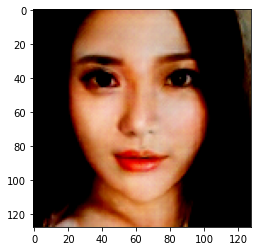

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


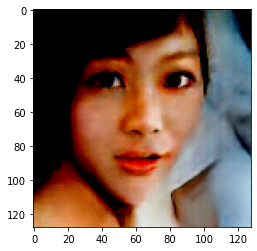

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


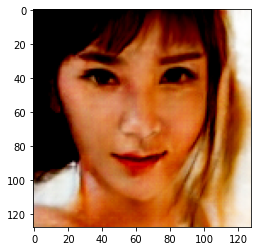

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


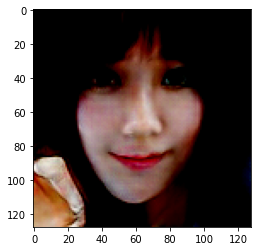

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


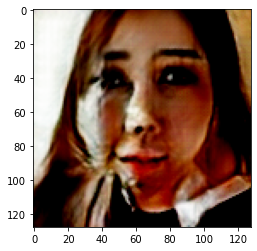

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


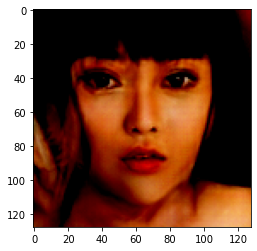

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


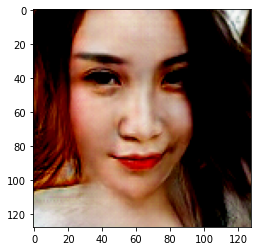

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


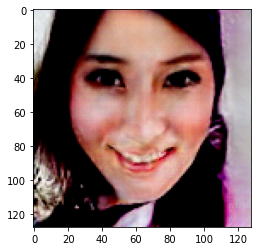

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


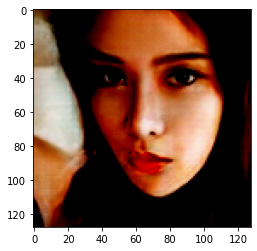

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


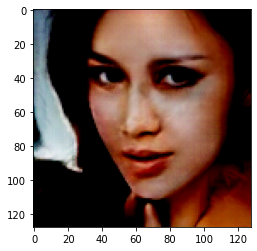

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


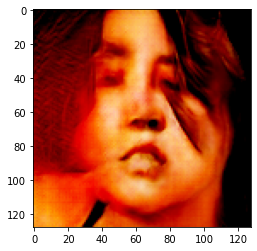

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


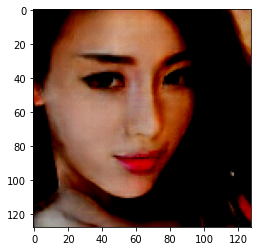

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


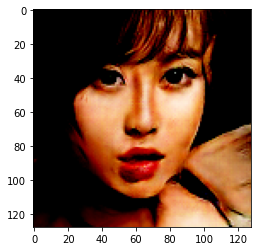

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


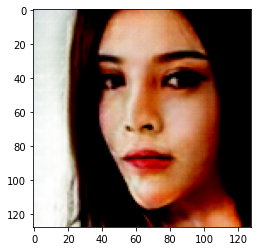

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


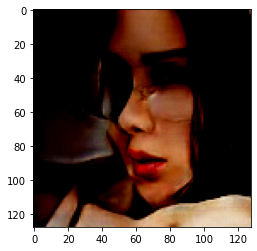

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


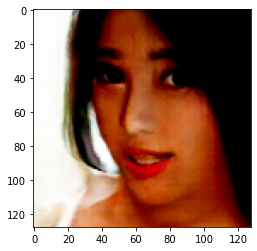

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


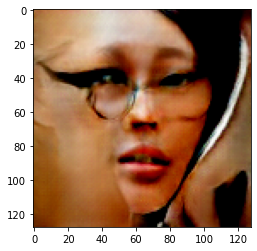

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


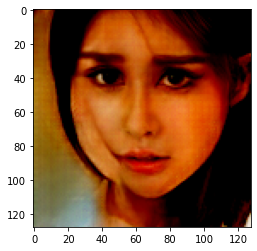

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


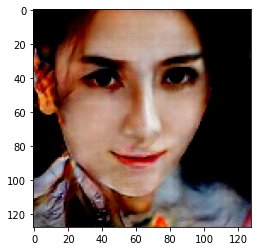

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


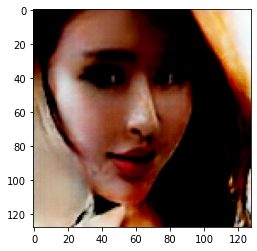

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


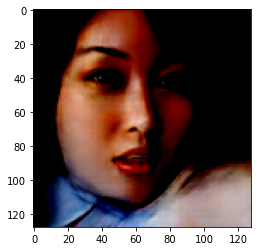

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


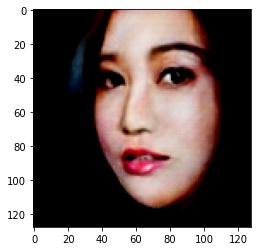

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


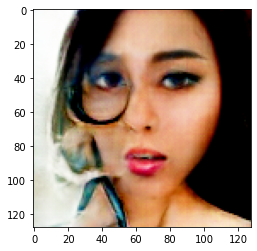

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


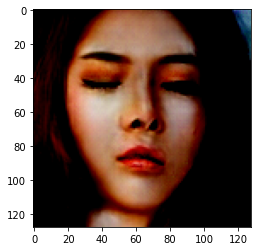

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


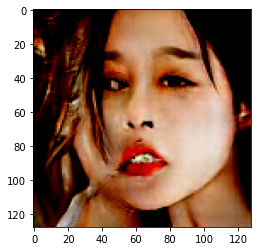

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


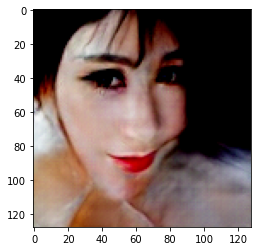

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


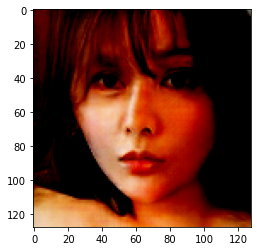

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


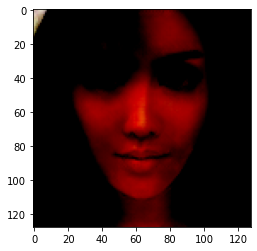

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


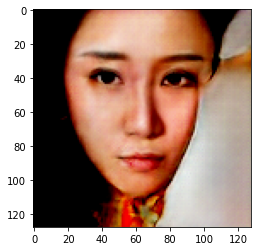

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


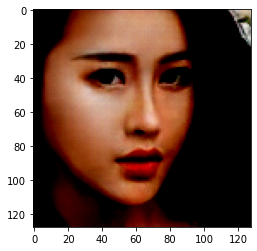

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


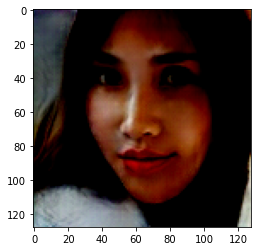

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


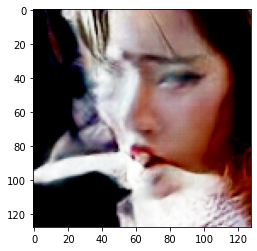

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


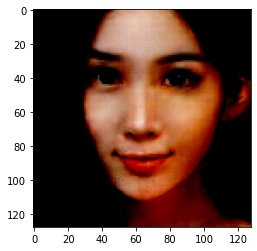

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


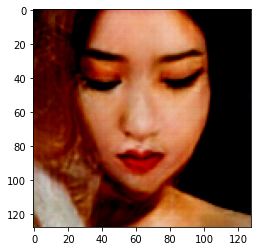

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


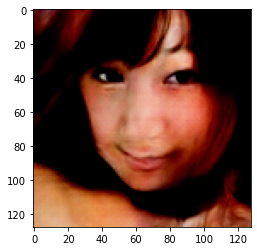

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


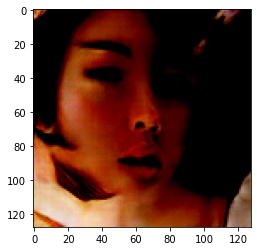

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


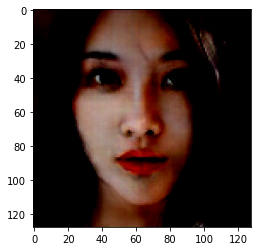

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


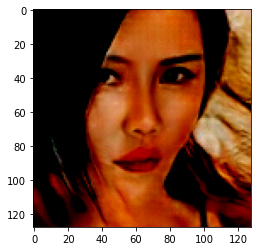

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


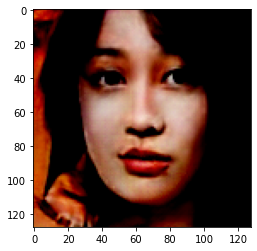

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


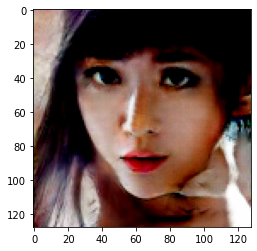

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


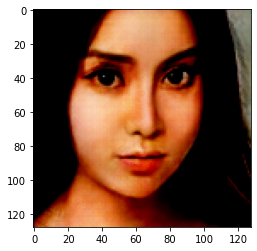

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


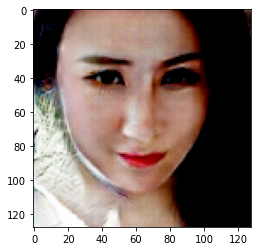

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


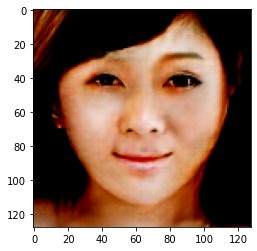

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


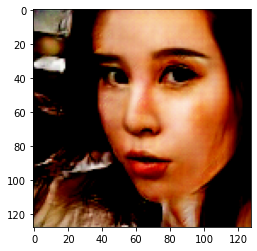

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


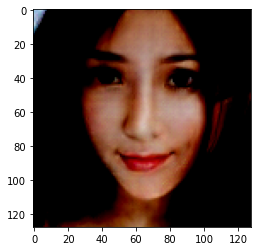

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


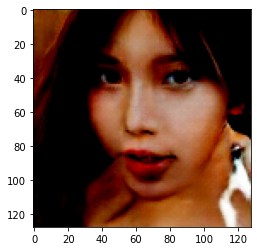

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


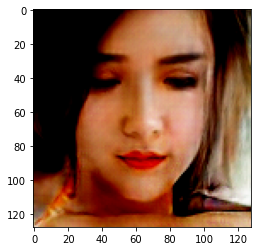

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


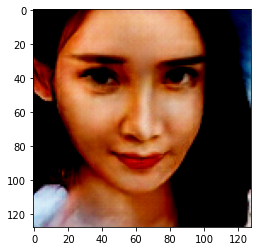

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


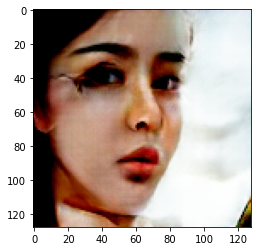

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


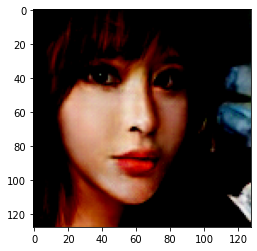

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


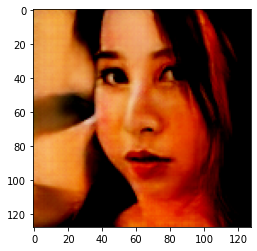

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


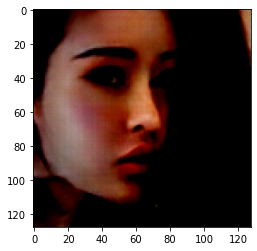

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


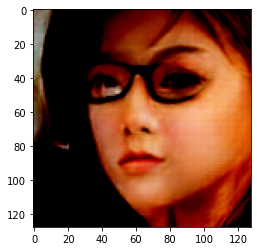

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


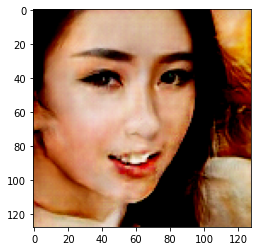

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


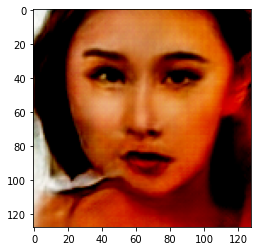

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


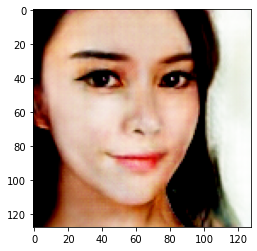

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


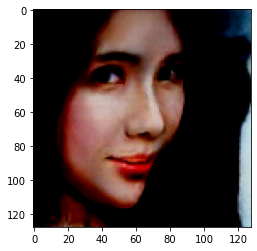

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


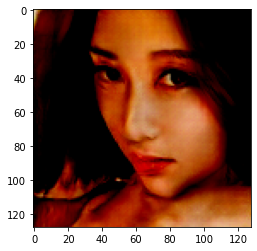

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


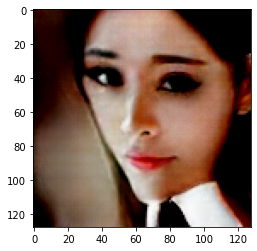

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


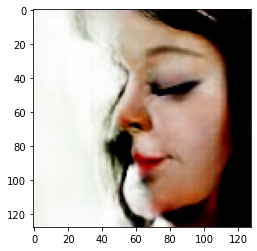

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


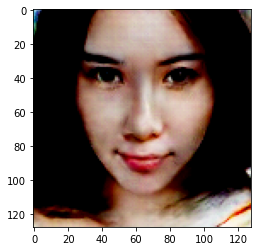

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


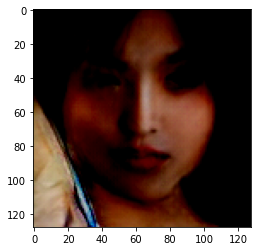

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


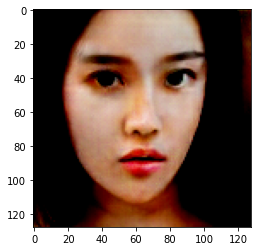

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


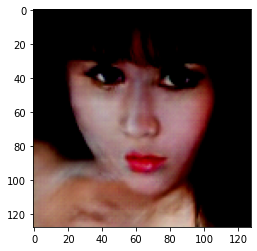

In [13]:
Gtest.load_weights('{}/G_human.npz'.format(flags.checkpoint_dir), format='npz')
Gtest.eval()
z = np.random.normal(loc=0.0, scale=1.0, size=[flags.batch_size, flags.z_dim]).astype(np.float32)
result = Gtest(z)
#tl.visualize.images2d(result)
for img in result:
    plt.imshow(img)
    plt.show()

## **12. Display individual Images**
---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


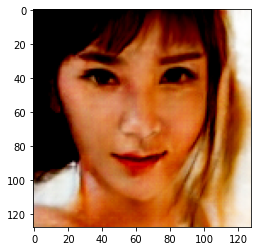

In [14]:
#tl.visualize.frame(result[3])
plt.imshow(result[2])
plt.show()

## **13. Save the images**
---

In [15]:
print(len(result))
i = 0
for img in result:
    i = i+1
    tl.visualize.save_image(img, '{}/Test{}.png'.format(flags.test_dir, i))

Lossy conversion from float32 to uint8. Range [-0.9882962107658386, 0.9802996516227722]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9874433875083923, 0.9584128260612488]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9812668561935425, 0.9986098408699036]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9335936307907104, 0.9697458148002625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9674267172813416, 0.9974046349525452]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9907854795455933, 0.961357831954956]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9039208889007568, 0.9767396

64


Lossy conversion from float32 to uint8. Range [-0.9899184107780457, 0.9637207984924316]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9833405017852783, 0.9735341668128967]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9888594746589661, 0.9806312918663025]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9938346147537231, 0.8975027203559875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9829990267753601, 0.9863805174827576]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9878646731376648, 0.9454045295715332]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9970856308937073, 0.885995